Climate Data: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-month?pageNum=1
<br>CO2 Data: https://gml.noaa.gov/dv/site/index.php?stacode=none

# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import glob
import os

# Import csv files

In [2]:
def read_csv(directory):
    path = directory
    all_files = glob.glob(os.path.join(path, '*.csv'))

    l = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        l.append(df)

    df = pd.concat(l, axis=0, ignore_index=True)
    
    return df

In [3]:
climate_df = read_csv('Climate_data')
carbon_df = read_csv('CO2_data')

# Manage columns

In [4]:
climate_df['DATE'] = pd.to_datetime(climate_df['DATE'])

In [5]:
columns = {'DATE':'Date',
           'ADPT':'Average Dew Point Temperature', 
           'AWND':'Average Wind Speed',
           'PRCP':'Total Monthly Precipitation',
           'PSUN':'Monthly Average of the daily percents of possible sunshine',
           'TAVG':'Average Monthly Temperature',
           'TMAX':'Monthly Maximum Temperature',
           'TMIN':'Monthly Minimum Temperature',
           'RHAV':'Relative Humidity'}

climate_df = climate_df.rename(columns=columns)

In [6]:
climate_df['NAME'].drop_duplicates()

0                             BOULDER, CO US
1510    HILO INTERNATIONAL AIRPORT 87, HI US
2401                    HOHENPEISSENBERG, GM
4441                      VESTMANNAEYJAR, IC
5250                     CAPE FLORIDA, FL US
5563         LOS ANGELES DOWNTOWN USC, CA US
6888           SAN FRANCISCO DOWNTOWN, CA US
8123             TEMPLE DRAUGHTON MIL, TX US
Name: NAME, dtype: object

In [7]:
cols = ['Date',
        'Average Dew Point Temperature',
        'Average Wind Speed',
        'Total Monthly Precipitation',
        'Monthly Average of the daily percents of possible sunshine',
        'Average Monthly Temperature',
        'Monthly Maximum Temperature',
        'Monthly Minimum Temperature',
        'Relative Humidity']

def create_df(name, column_names, dataframe, site='NAME'):
    df = dataframe[dataframe[site] == name]
    df = df[column_names]
    return df.set_index('Date')

In [8]:
carbon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39748 entries, 0 to 39747
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_code                39748 non-null  object 
 1   year                     39748 non-null  int64  
 2   month                    39748 non-null  int64  
 3   day                      39748 non-null  int64  
 4   hour                     39748 non-null  int64  
 5   minute                   39748 non-null  int64  
 6   second                   39748 non-null  int64  
 7   datetime                 39748 non-null  object 
 8   time_decimal             39748 non-null  float64
 9   air_sample_container_id  39748 non-null  object 
 10  value                    39748 non-null  float64
 11  latitude                 39748 non-null  float64
 12  longitude                39748 non-null  float64
 13  altitude                 39748 non-null  float64
 14  elevation             

In [9]:
bou = create_df('BOULDER, CO US', cols, climate_df)
hil = create_df('HILO INTERNATIONAL AIRPORT 87, HI US', cols, climate_df)
hoh = create_df('HOHENPEISSENBERG, GM', cols, climate_df)
cap = create_df('CAPE FLORIDA, FL US', cols, climate_df)
los = create_df('LOS ANGELES DOWNTOWN USC, CA US', cols, climate_df)
san = create_df('SAN FRANCISCO DOWNTOWN, CA US', cols, climate_df)
ice = create_df('VESTMANNAEYJAR, IC', cols, climate_df)
tem = create_df('TEMPLE DRAUGHTON MIL, TX US', cols, climate_df)

In [10]:
carbon_df[['year', 'month']] = carbon_df[['year', 'month']].astype(str)
carbon_df['Date'] = carbon_df[['year', 'month']].agg(''.join, axis=1)
carbon_df['Date'] = carbon_df['Date'].astype(int)
carbon_df['Date'] = pd.to_datetime(carbon_df['Date'], format='%Y%m')

In [11]:
cols_co2 = ['Date', 'site_code', 'latitude', 'longitude', 'value',]

bou_co2 = create_df('BAO', cols_co2, carbon_df, site='site_code')
hil_co2 = create_df('MLO', cols_co2, carbon_df, site='site_code')
hoh_co2 = create_df('HPB', cols_co2, carbon_df, site='site_code')
cap_co2 = create_df('KEY', cols_co2, carbon_df, site='site_code')
los_co2 = create_df('MWO', cols_co2, carbon_df, site='site_code')
san_co2 = create_df('STR', cols_co2, carbon_df, site='site_code')
ice_co2 = create_df('ICE', cols_co2, carbon_df, site='site_code')
tem_co2 = create_df('WKT', cols_co2, carbon_df, site='site_code')

WKT - Moody, TX
<br>MLO - Mauna Loa, HI

# Data analysis/visualization

In [12]:
def plot(y_value, df, x_value='Date', bin_num=100):    
    median = df[y_value].median()
    
    sns.set(rc={'figure.figsize':(10,10)})
    sns.set_style('white')
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), dpi=100)
    sns.scatterplot(data=df, x=x_value, y=y_value, ax=axs[0])
    sns.histplot(data=df[y_value], kde=True, bins=bin_num, ax=axs[1])
    axs[1].axvline(median, color='r')
    plt.tight_layout()

In [13]:
def outlier(df, column='value'):
    
    median = df[column].median()
    df.loc[df['value'] < 0, 'value'] = median
    
    std = df[column].std()
    outliers = (df[column] - median).abs() > 3*std

    df.loc[outliers] = np.nan
    df[column].fillna(median, inplace=True)
    
    return df

In [14]:
def Z_score(df):
    # get a sample of data from dataframe
    df_sample = df.sample(frac=0.5)
    
    # calculate the mean of that sample
    x = np.log(df_sample).mean()
    
    # calculate the mean of the whole dataframe
    mu = np.log(df).mean()
    
    # number of samples
    n = len(df)/2
    
    # calculate the standard deviation of the whole dataframe
    sigma = np.log(df).std()
    
    # translate the z-score formula into code
    Z = abs(x - mu)/ (sigma/np.sqrt(n))
    return Z

### Analysis of climate data

In [15]:
los.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1325 entries, 1906-04-01 to 2023-12-01
Data columns (total 8 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Average Dew Point Temperature                               207 non-null    float64
 1   Average Wind Speed                                          292 non-null    float64
 2   Total Monthly Precipitation                                 1299 non-null   float64
 3   Monthly Average of the daily percents of possible sunshine  144 non-null    float64
 4   Average Monthly Temperature                                 1316 non-null   float64
 5   Monthly Maximum Temperature                                 1316 non-null   float64
 6   Monthly Minimum Temperature                                 1317 non-null   float64
 7   Relative Humidity                                           209 non-nu

In [16]:
len(san['Monthly Average of the daily percents of possible sunshine'])

1235

In [17]:
cols_ = ['Average Dew Point Temperature',
        'Average Wind Speed',
        'Total Monthly Precipitation',
        'Monthly Average of the daily percents of possible sunshine',
        'Average Monthly Temperature',
        'Monthly Maximum Temperature',
        'Monthly Minimum Temperature',
        'Relative Humidity']

def plot_climate(df):
    for col in cols_:
        if len(df[col]) != df[col].isna().sum():
            plot(col, df)

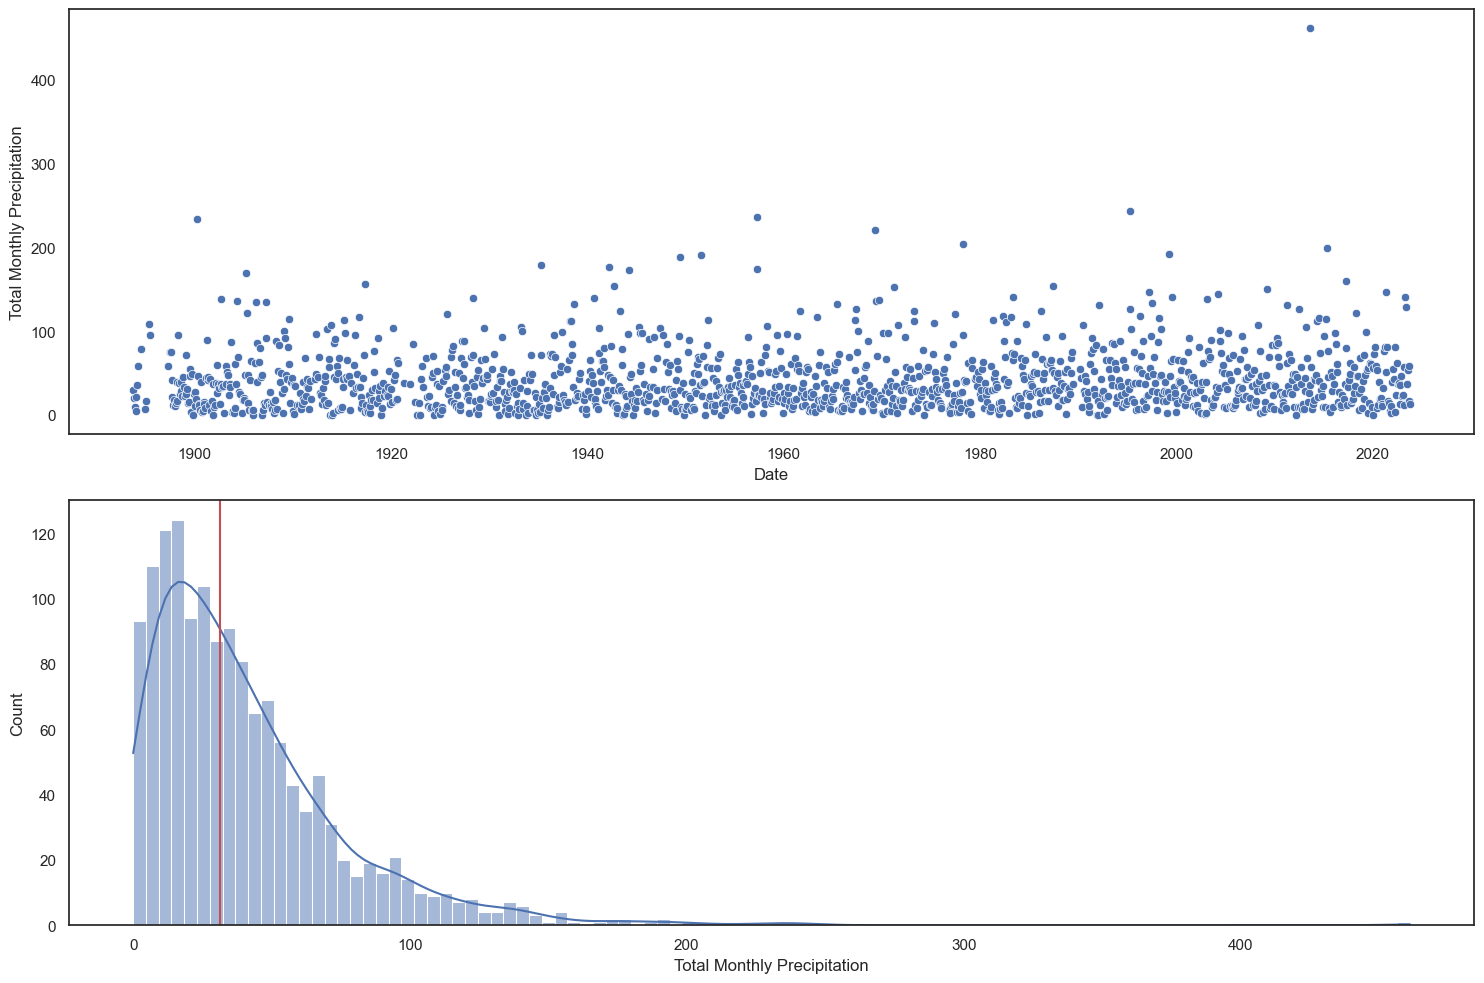

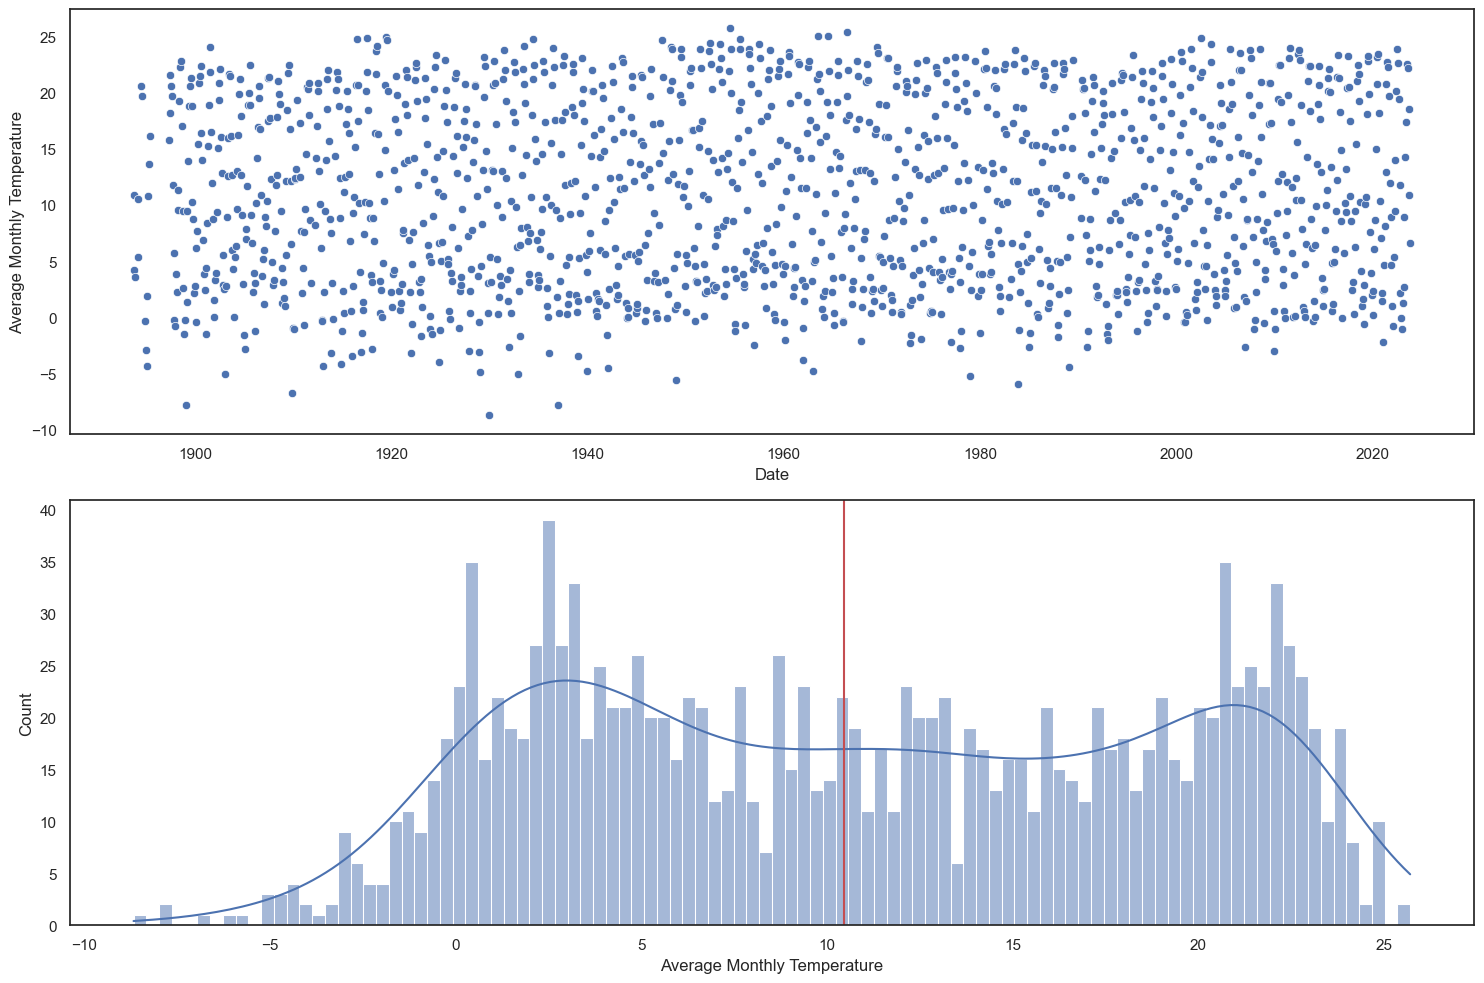

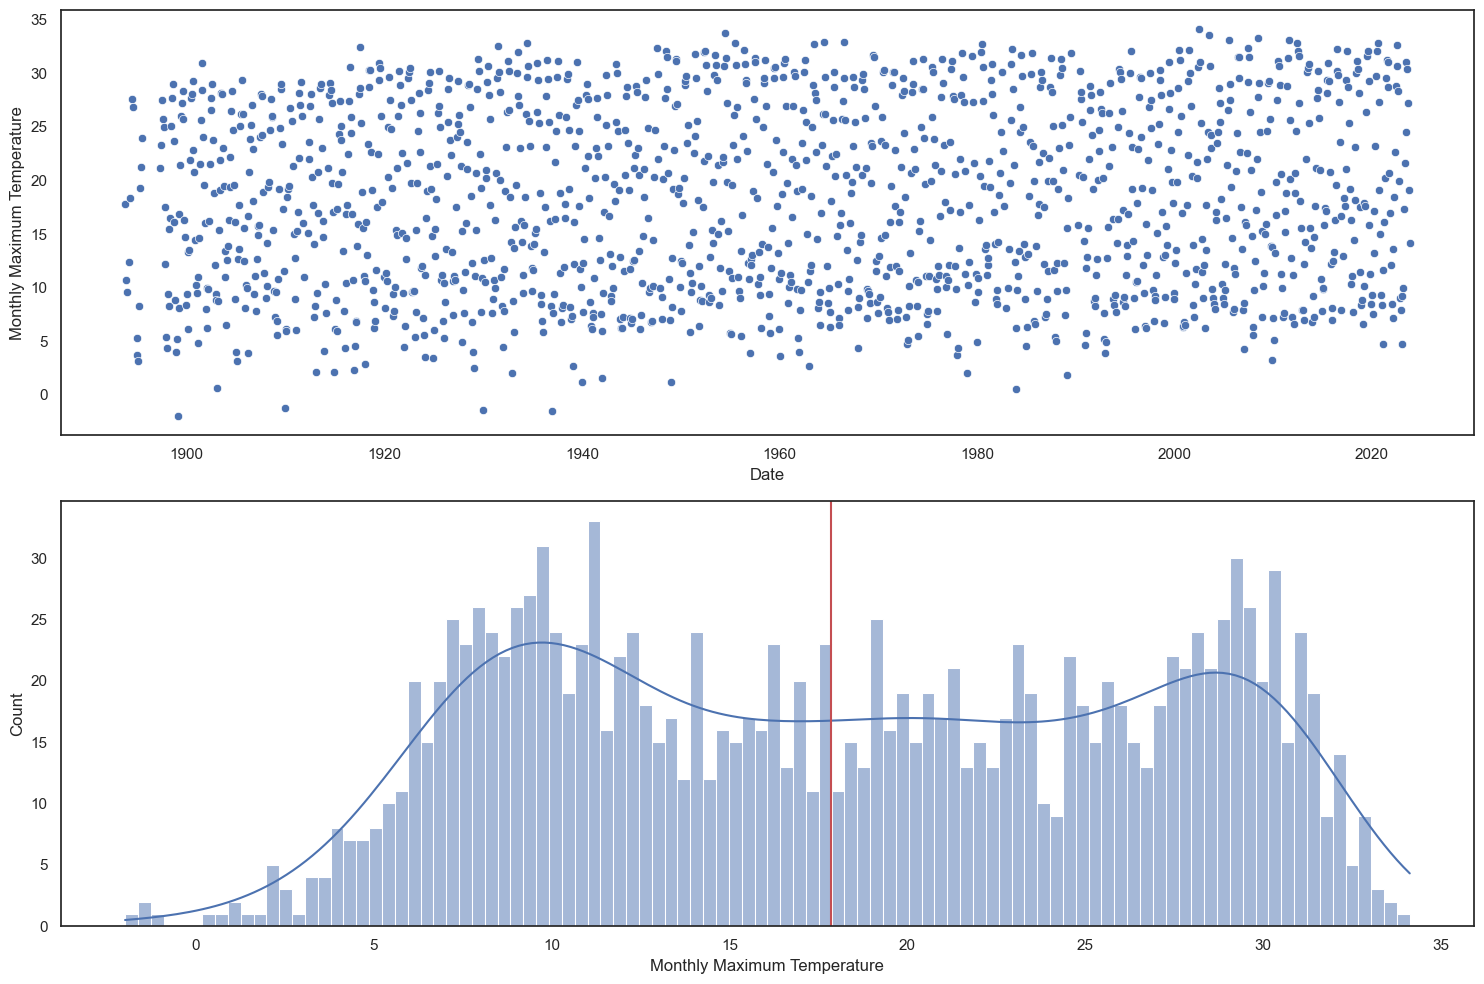

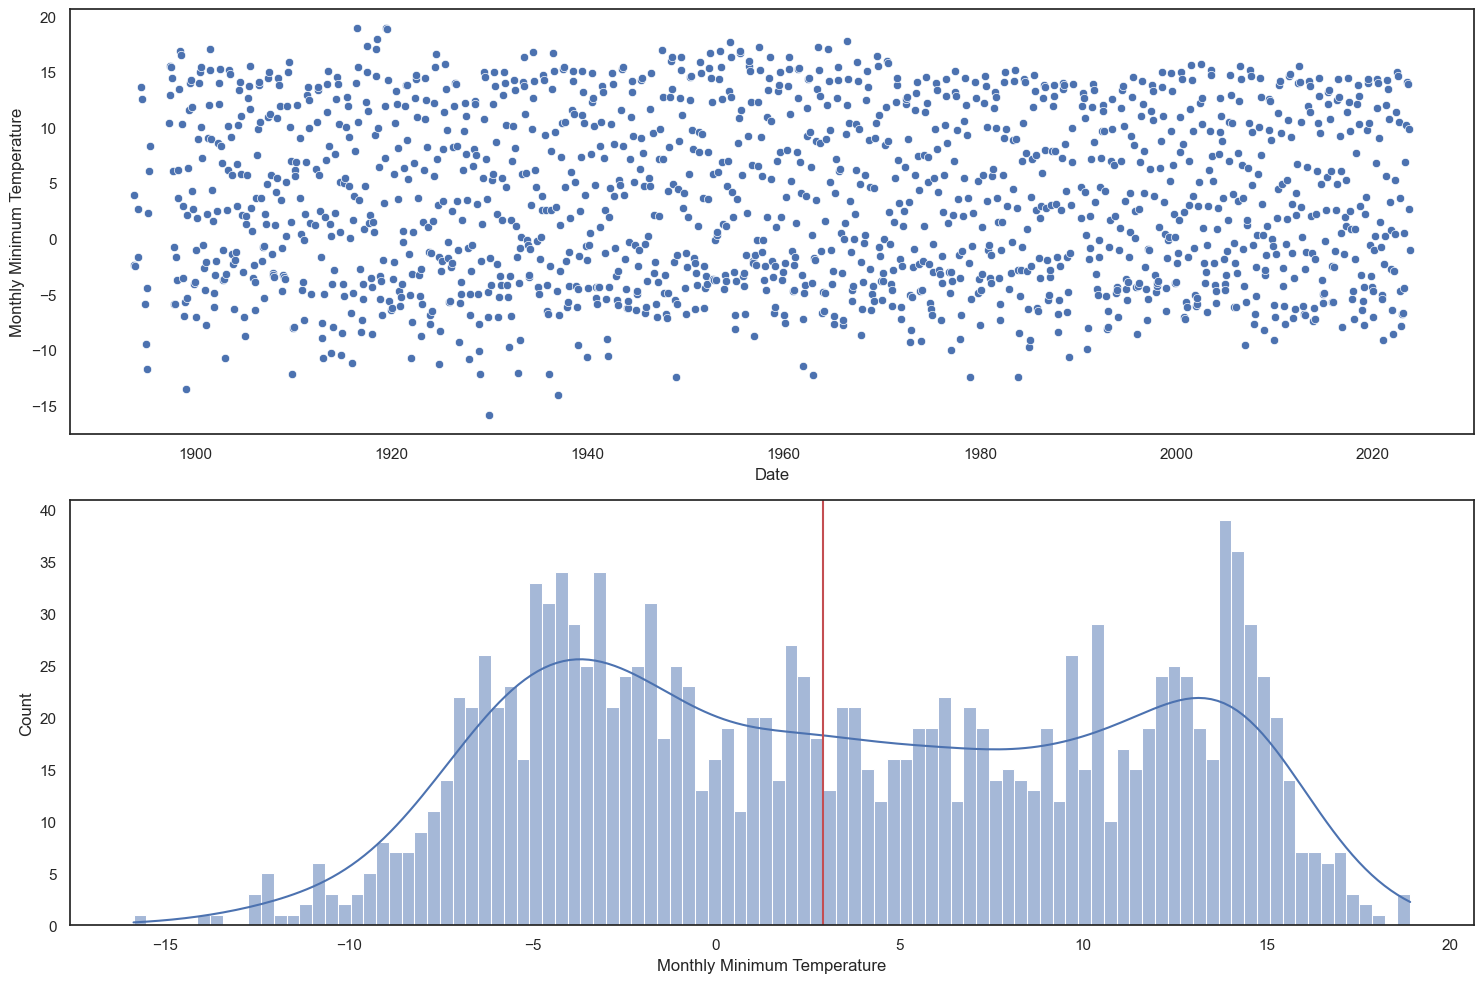

In [18]:
plot_climate(bou)

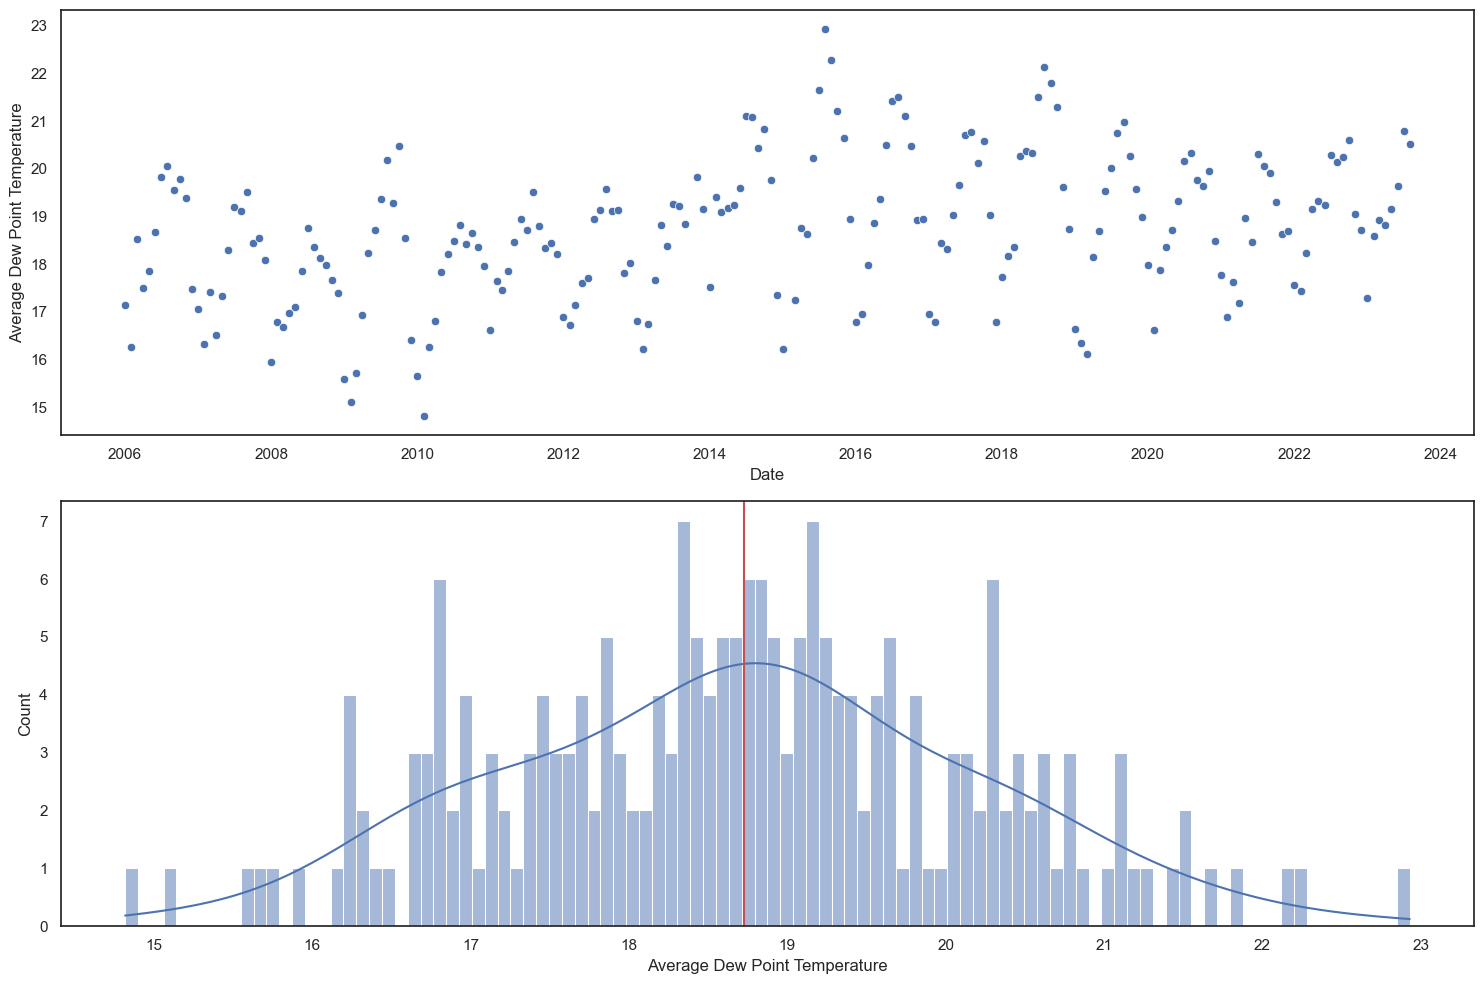

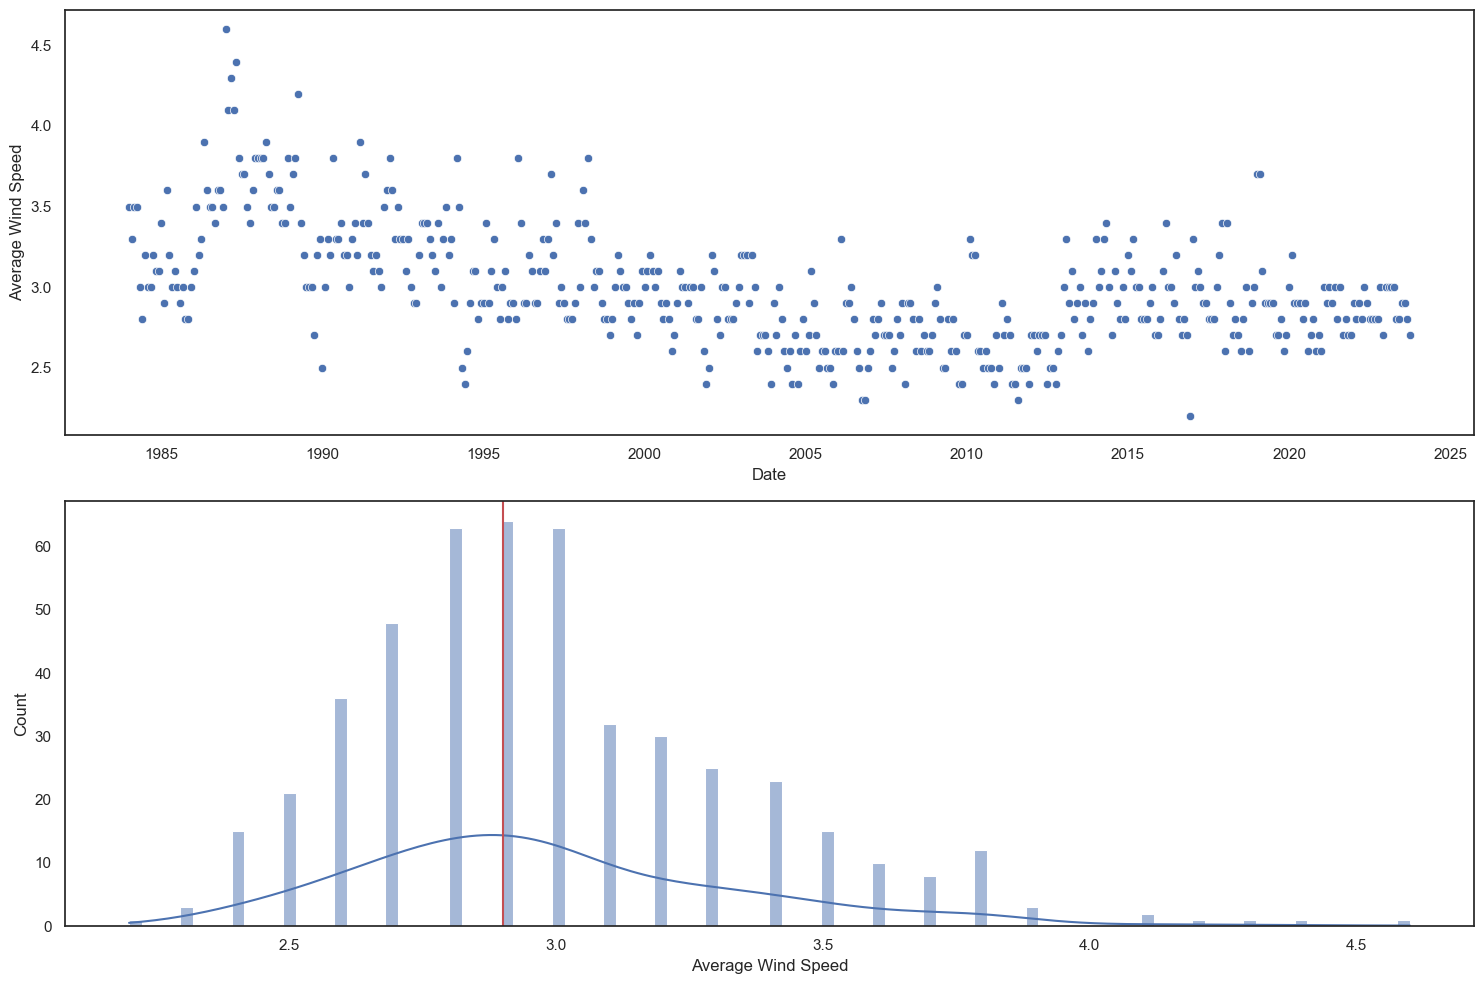

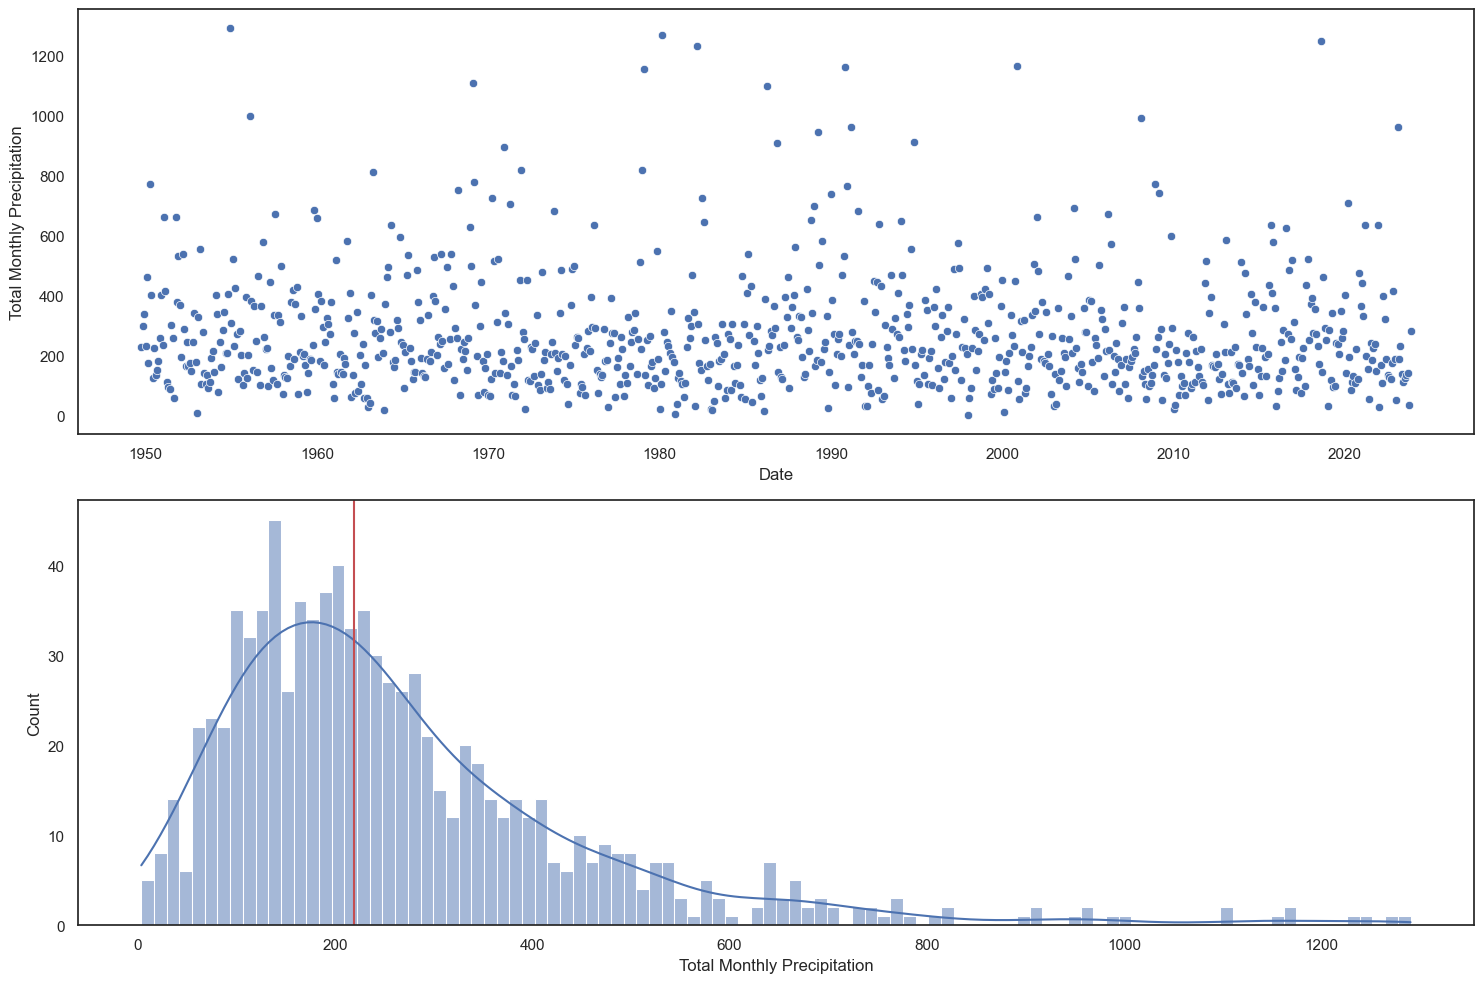

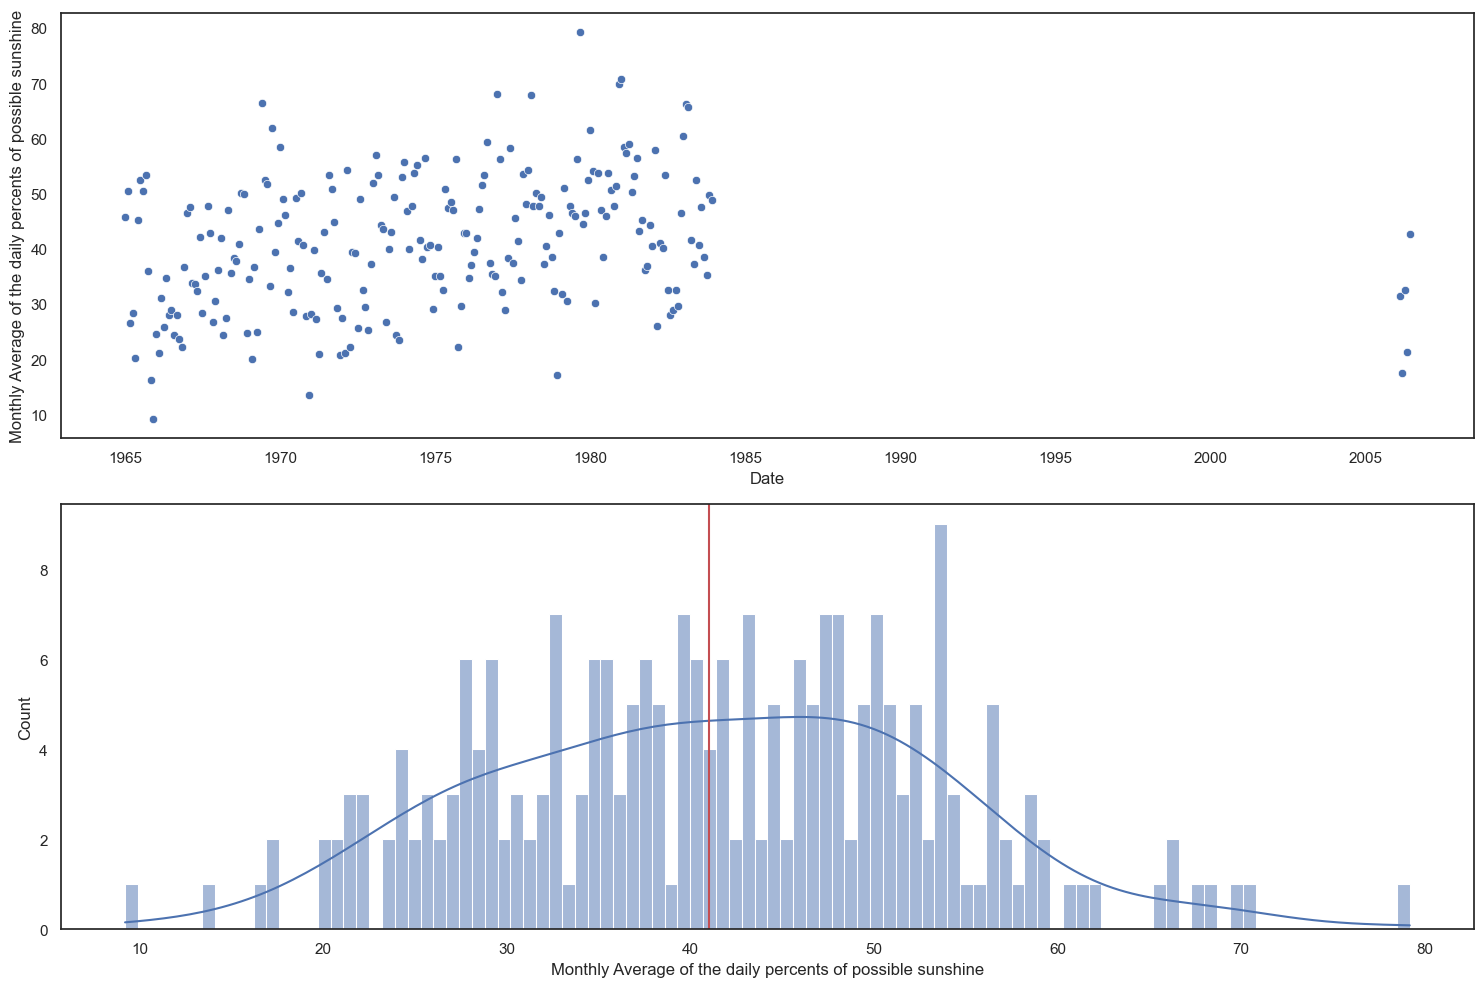

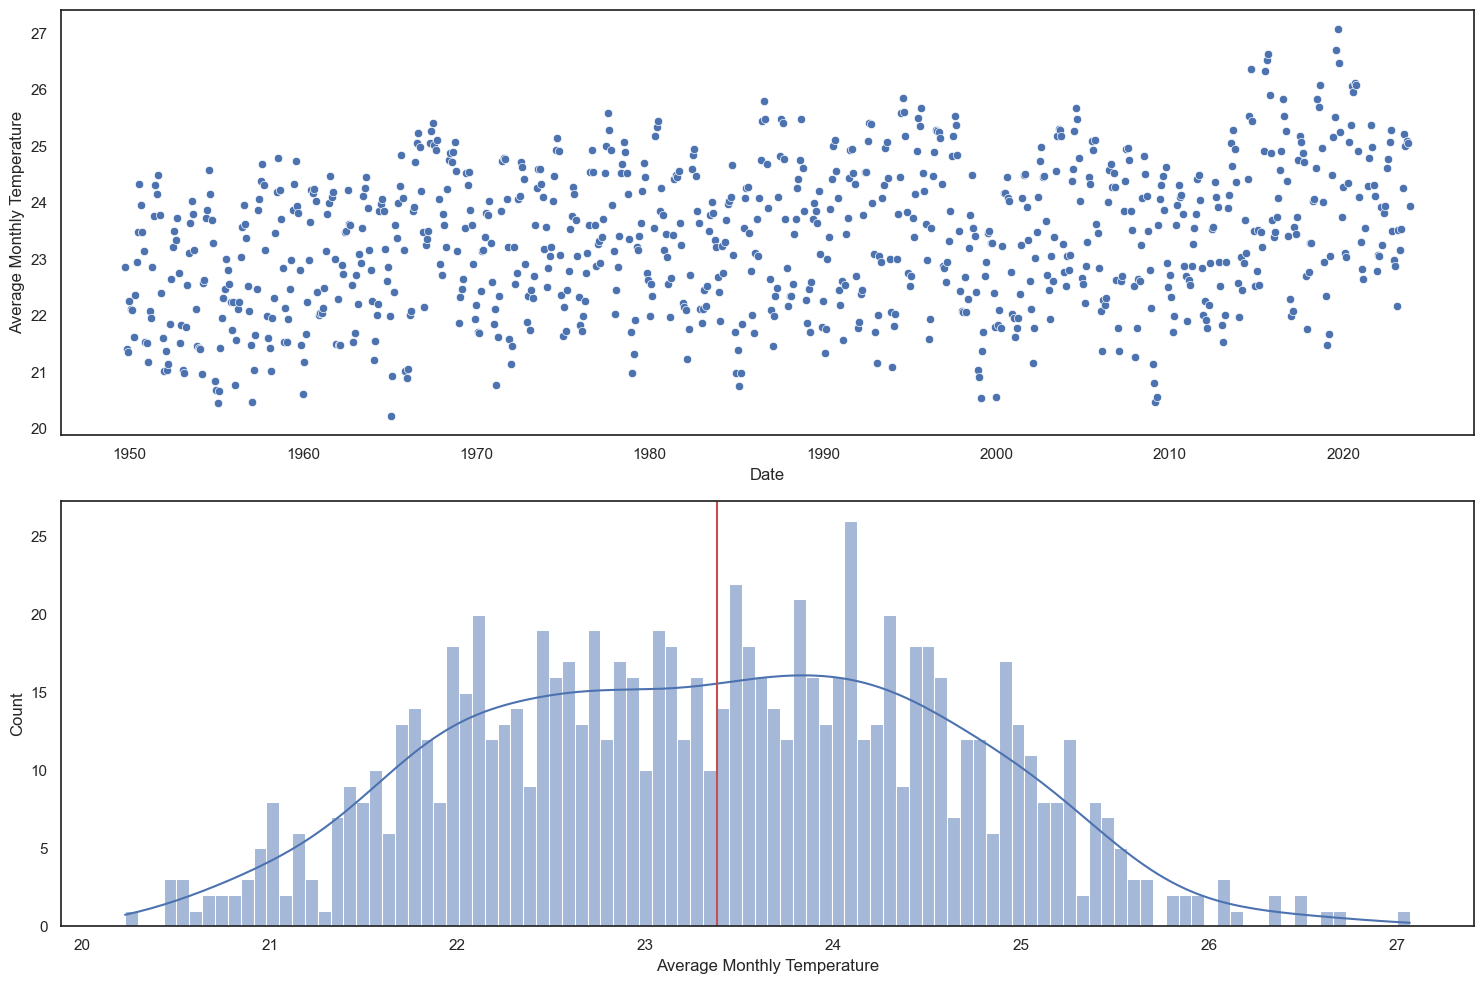

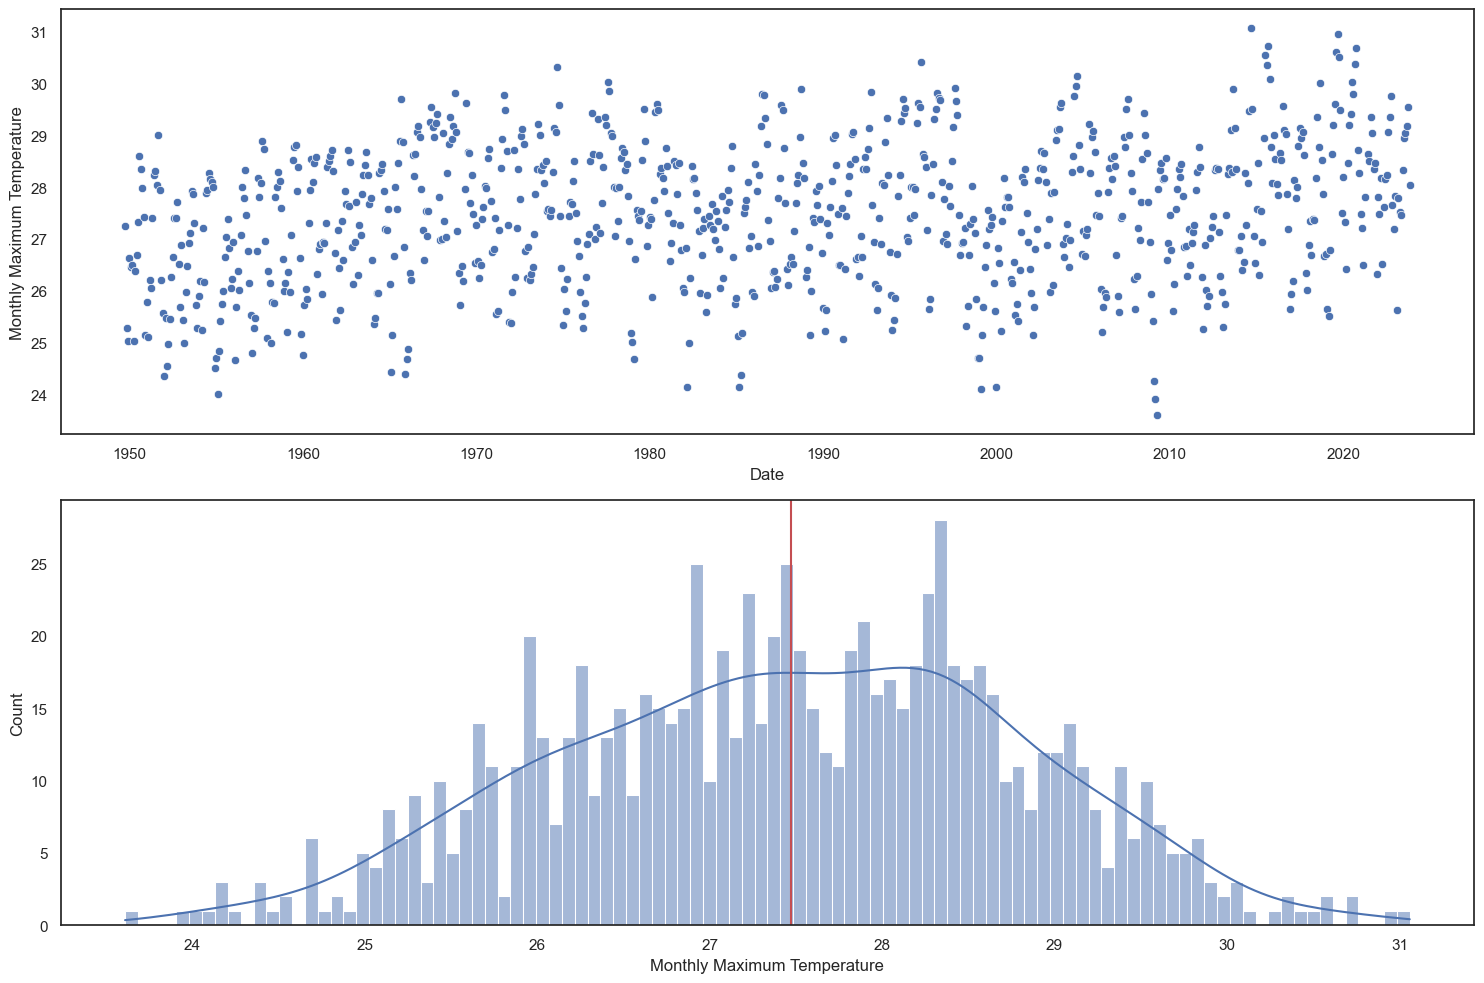

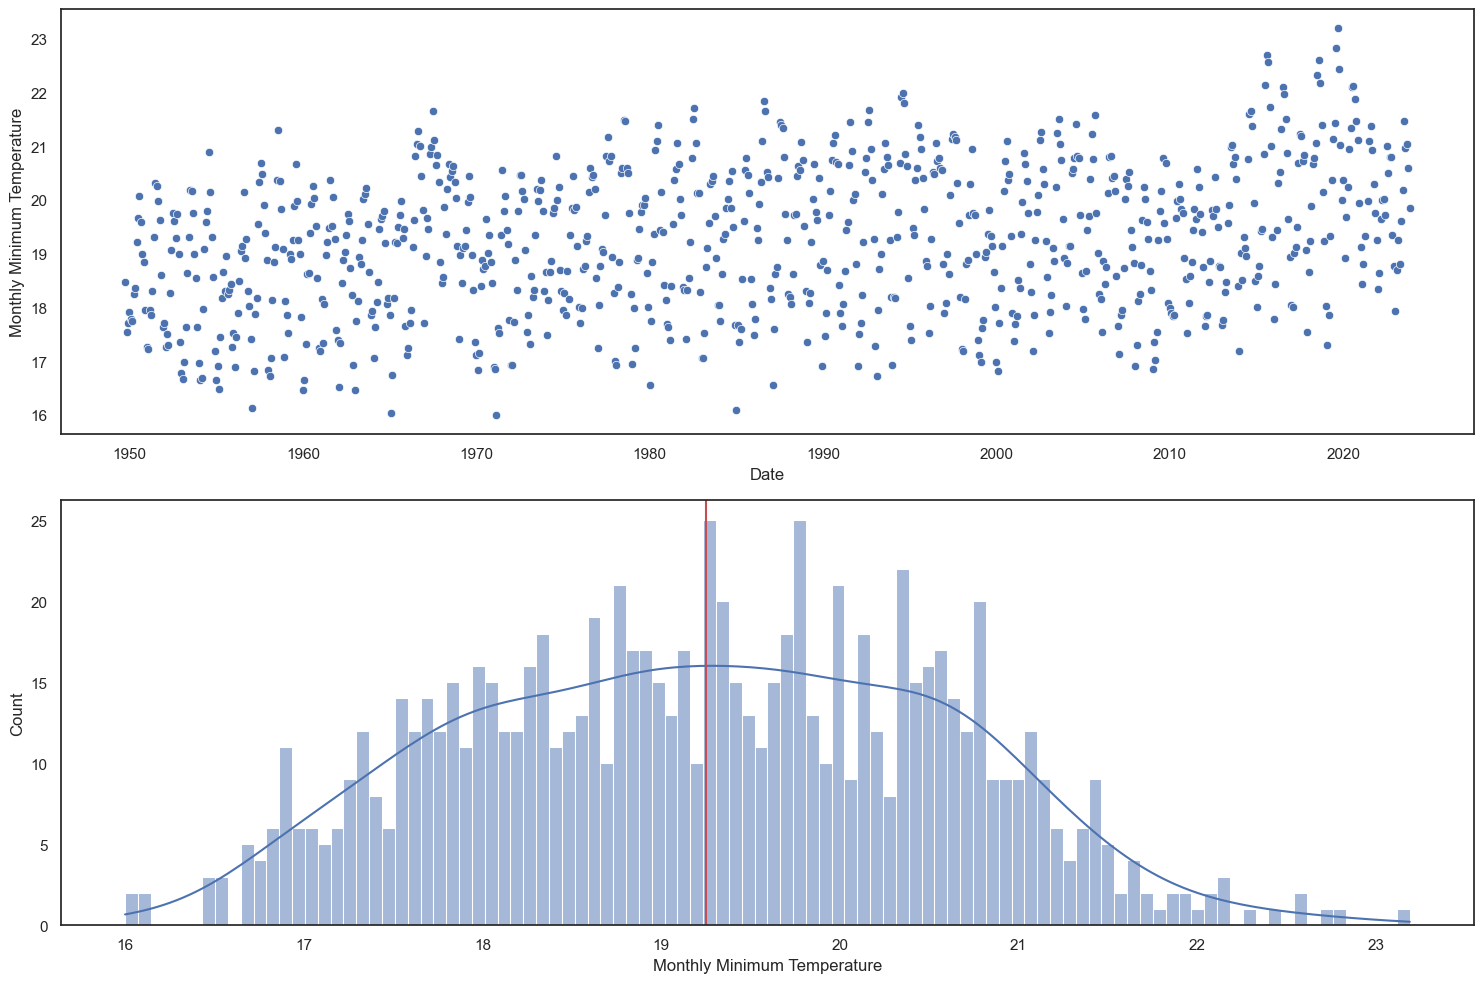

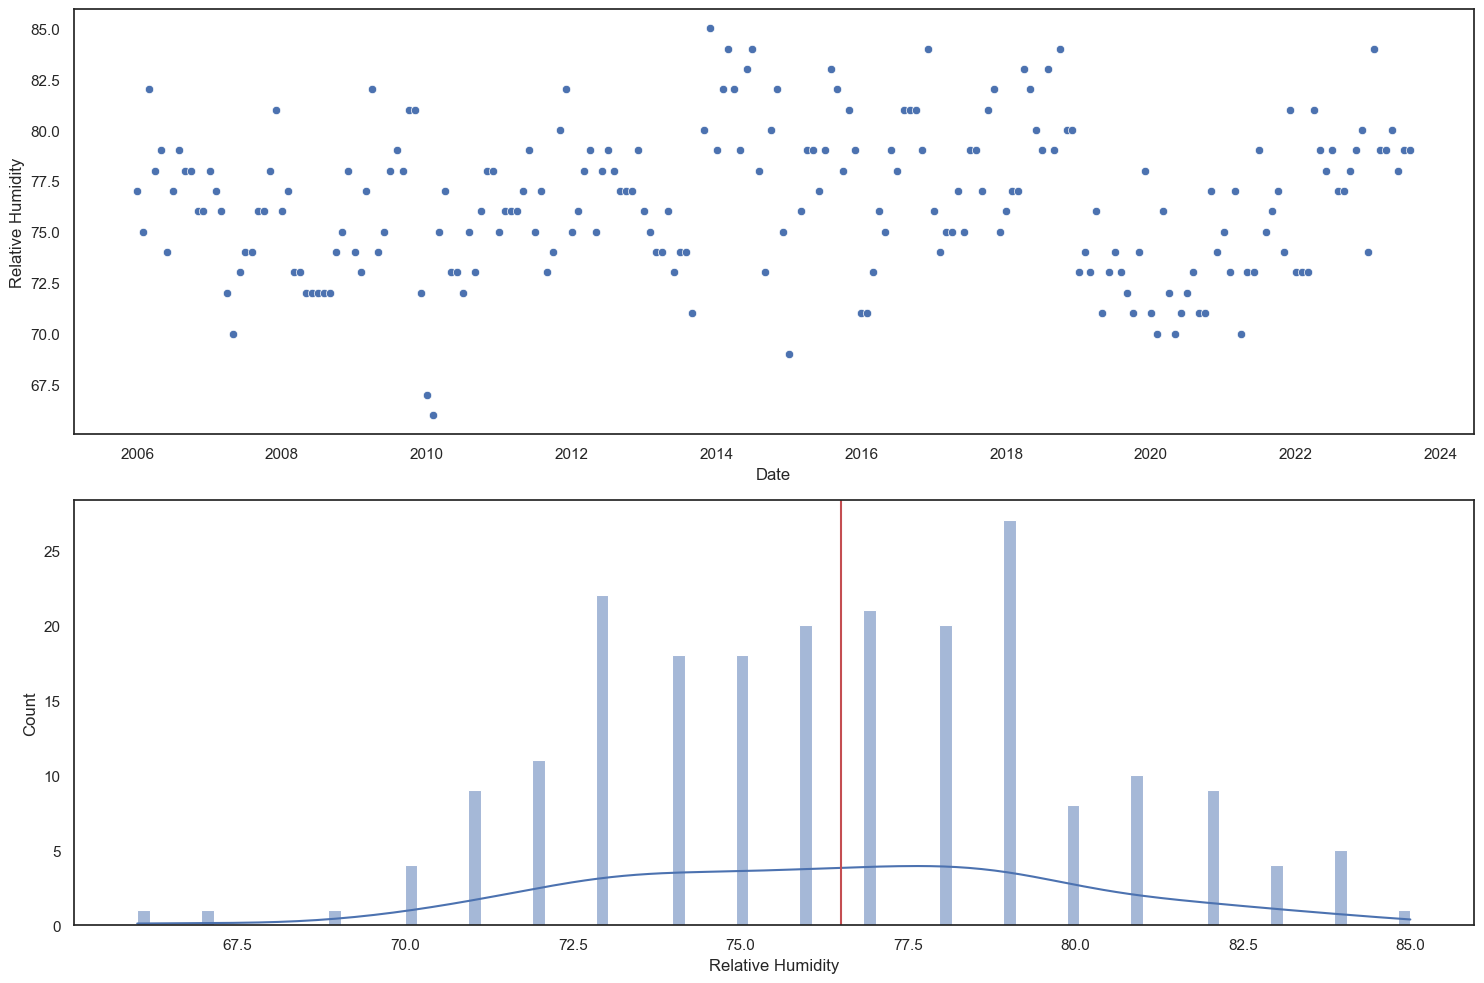

In [19]:
plot_climate(hil)

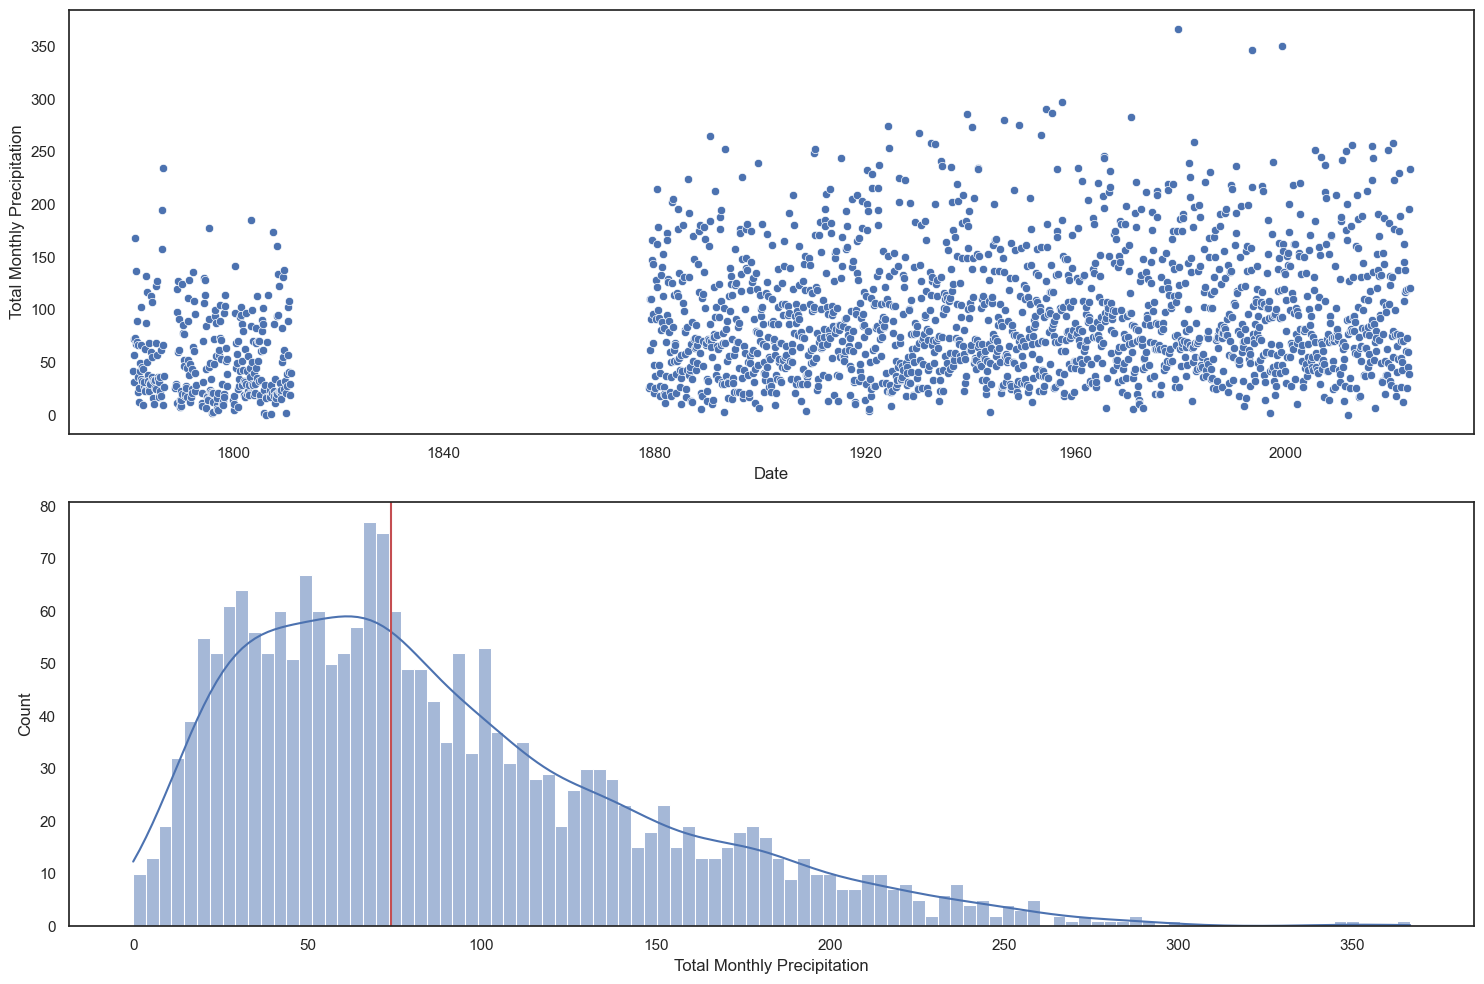

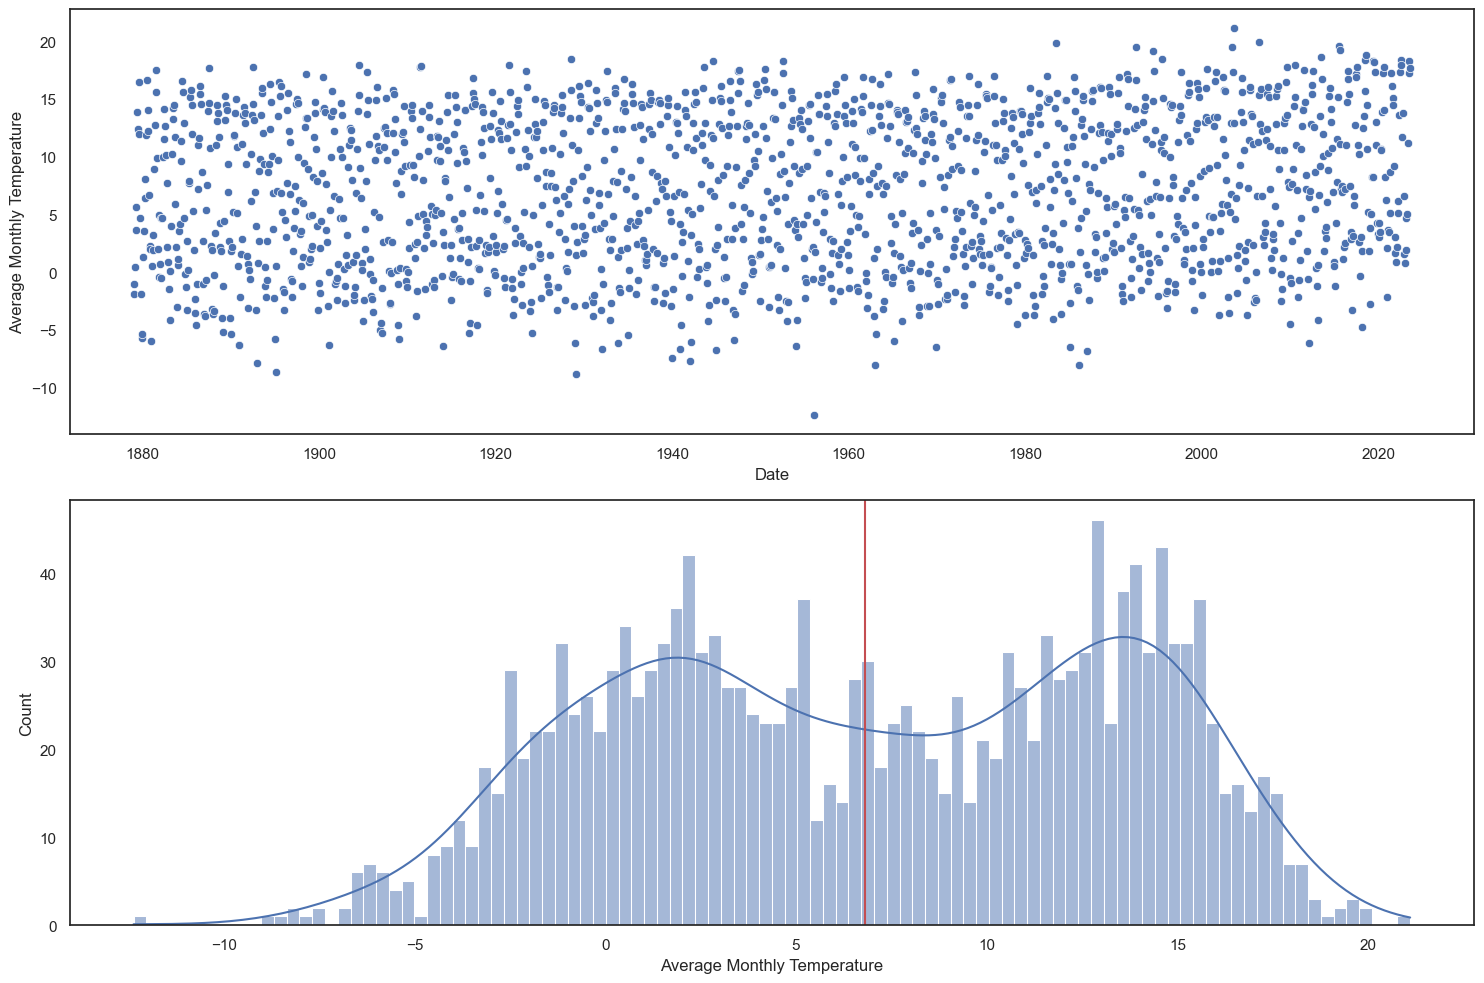

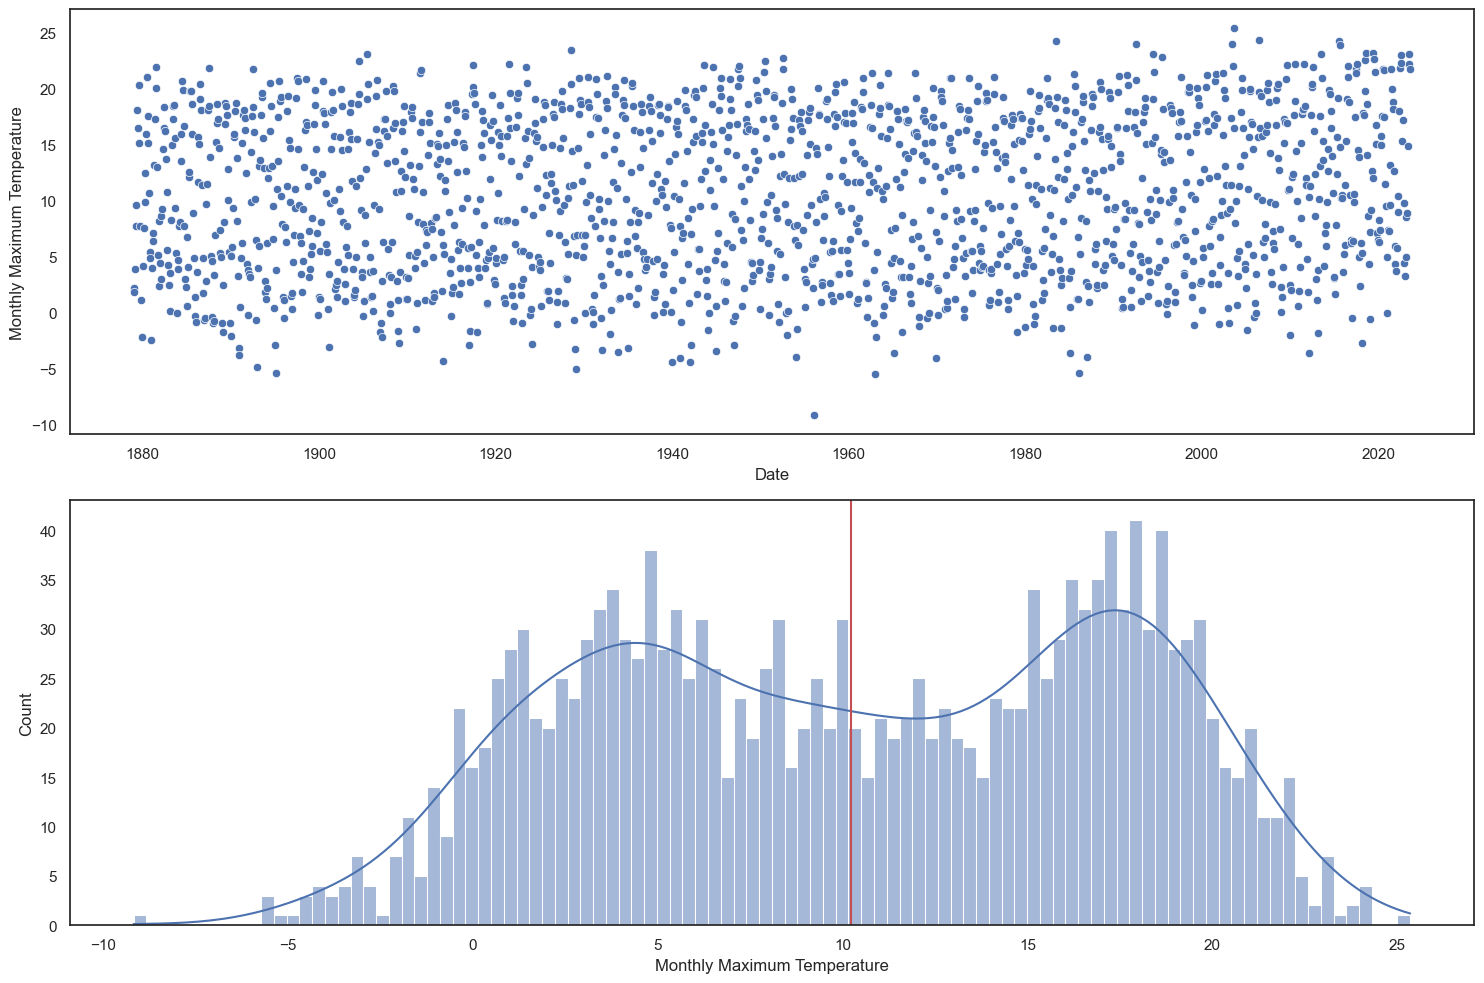

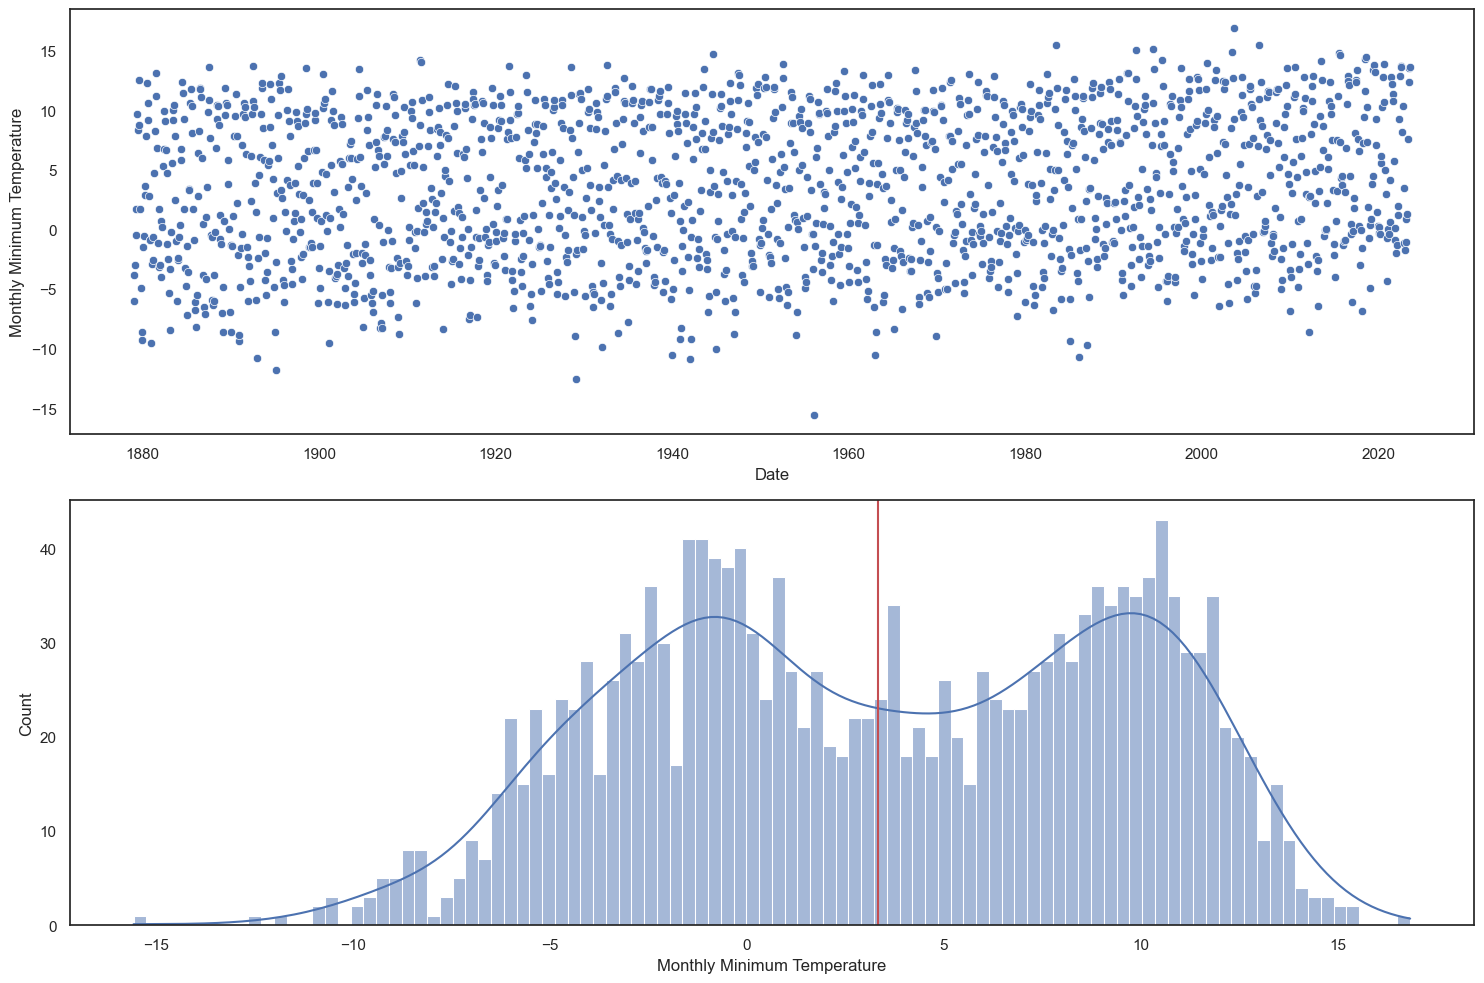

In [20]:
plot_climate(hoh)

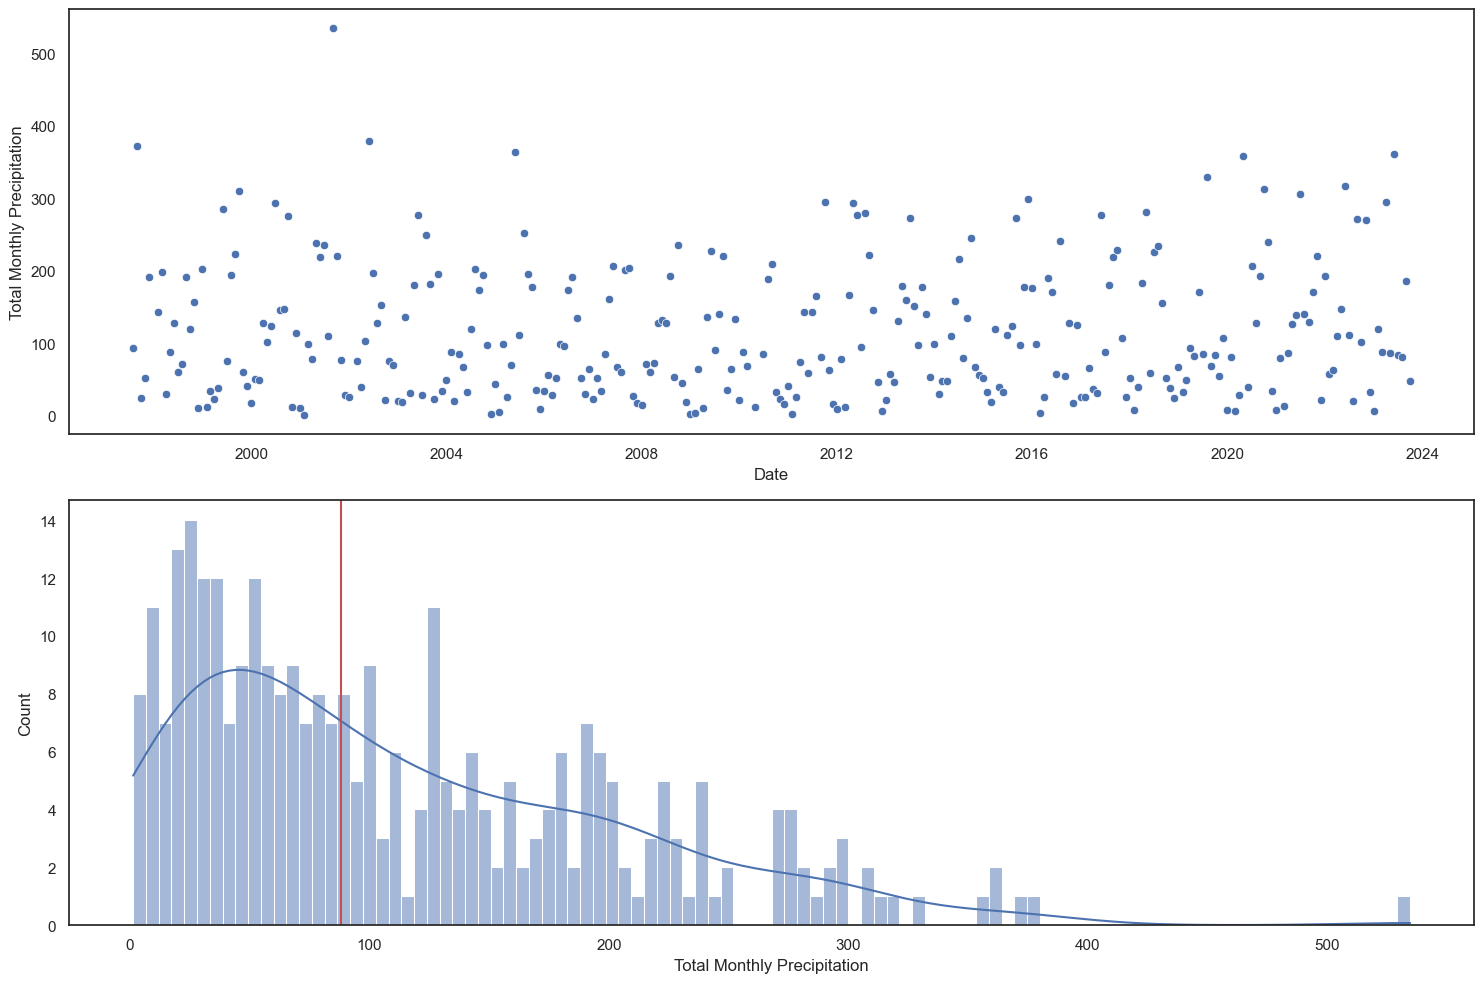

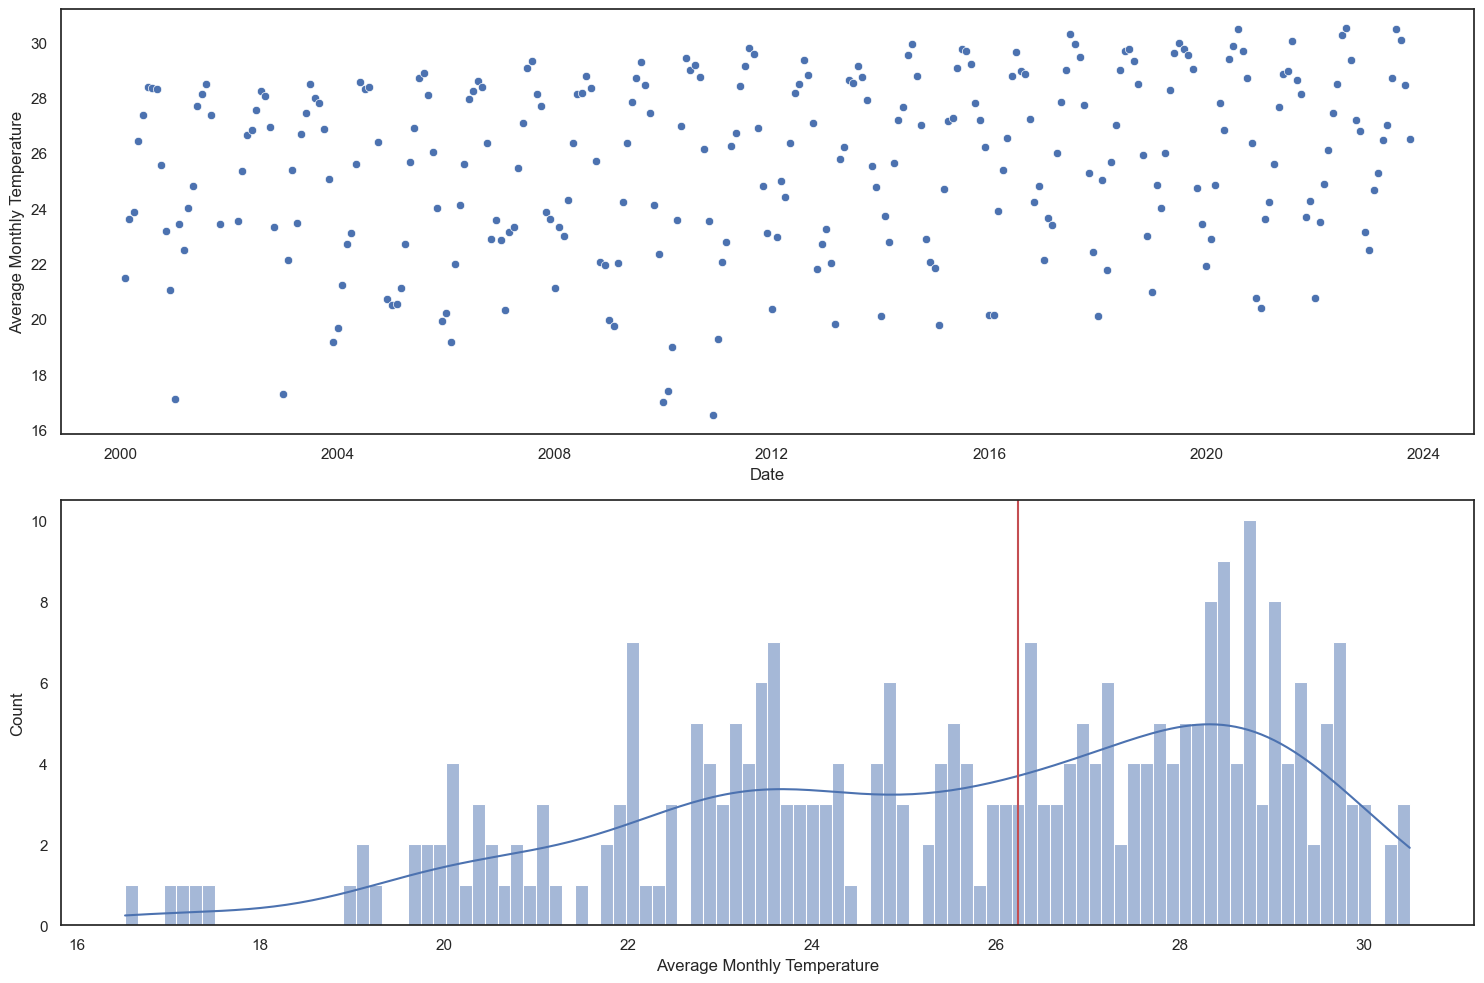

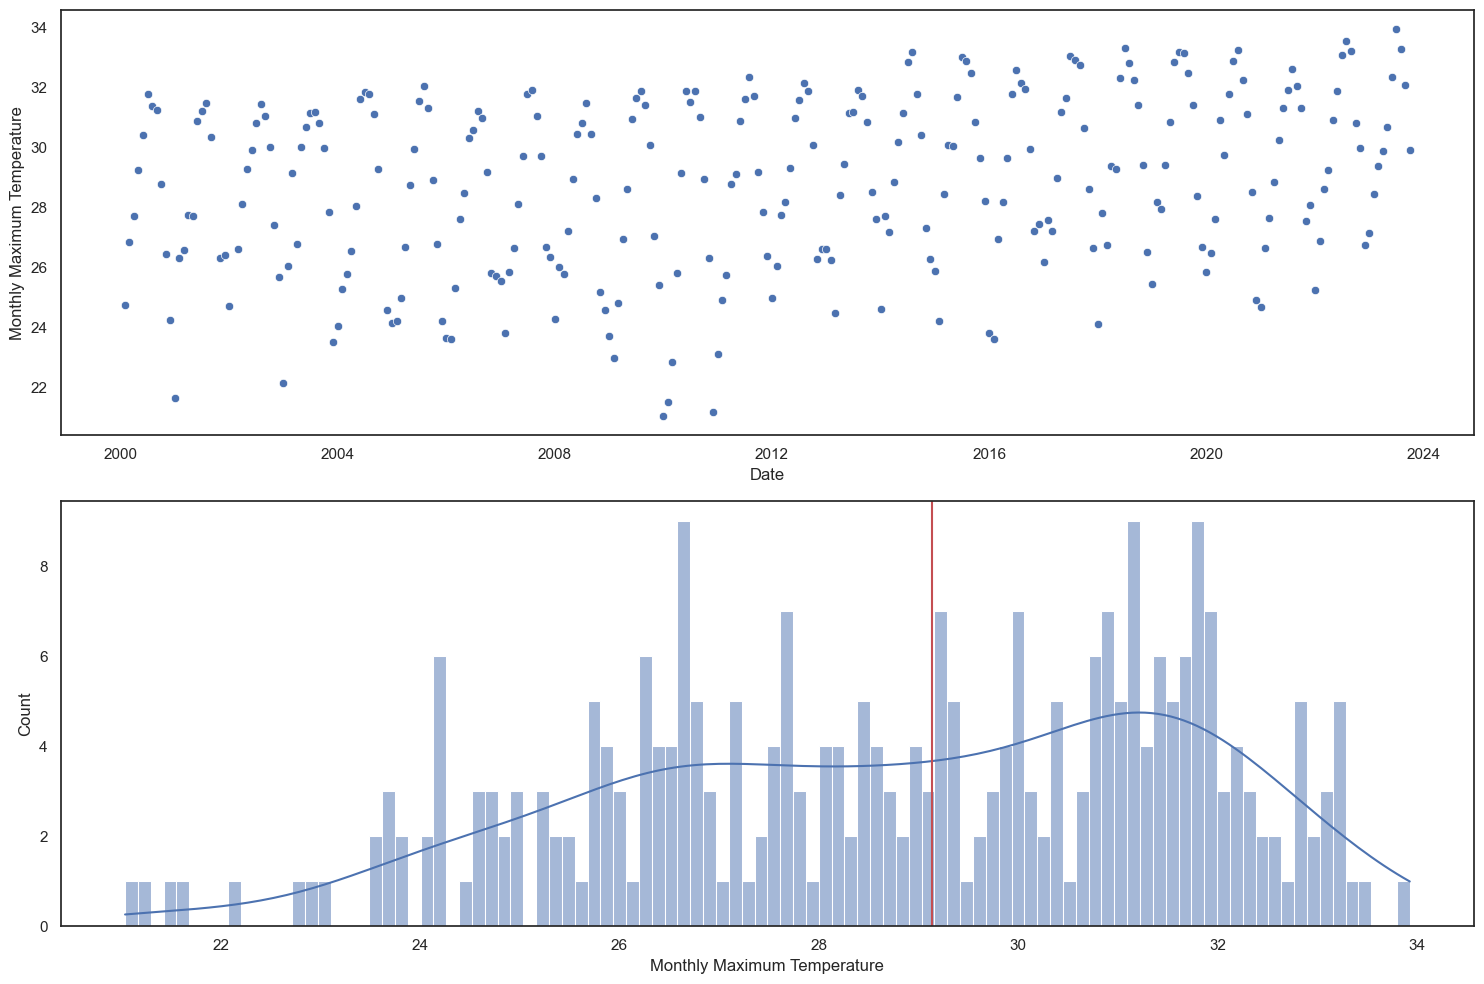

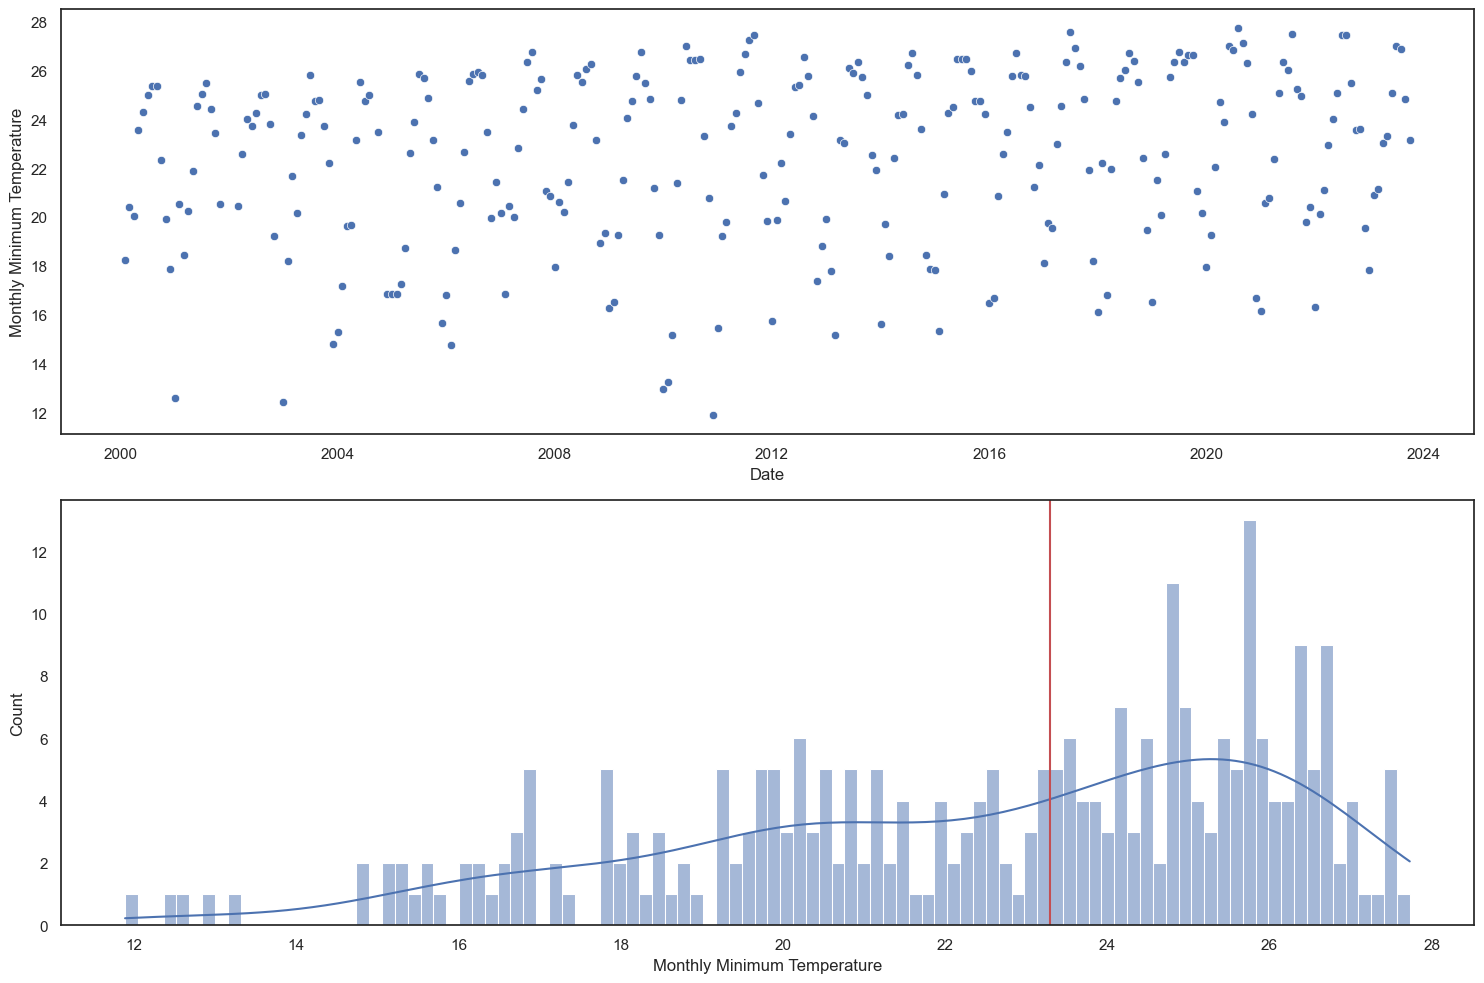

In [21]:
plot_climate(cap)

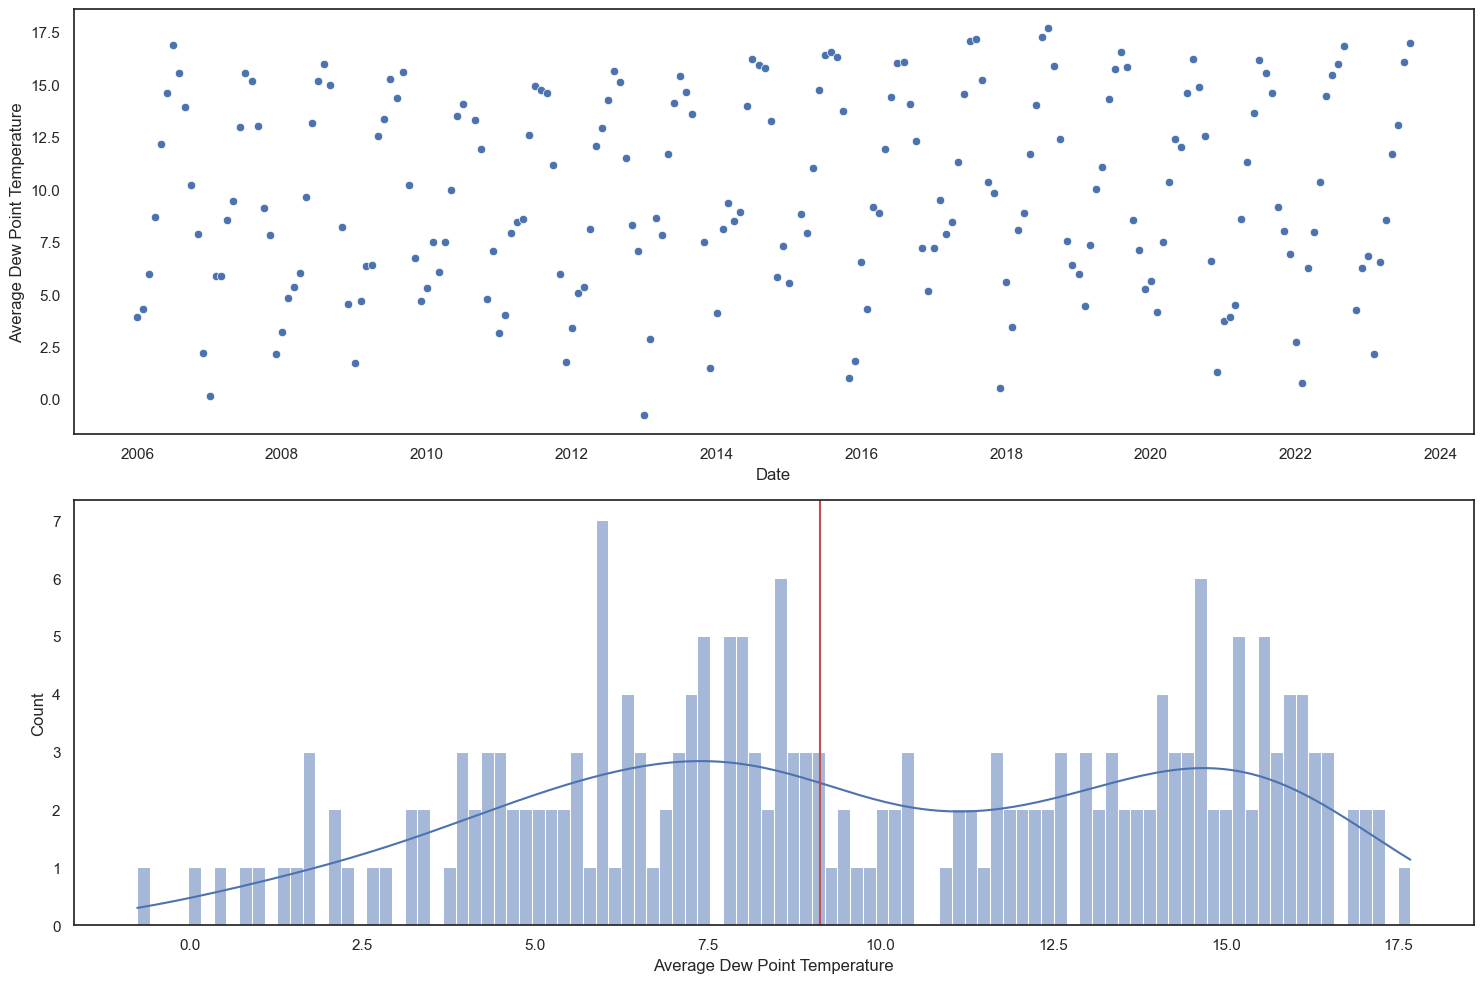

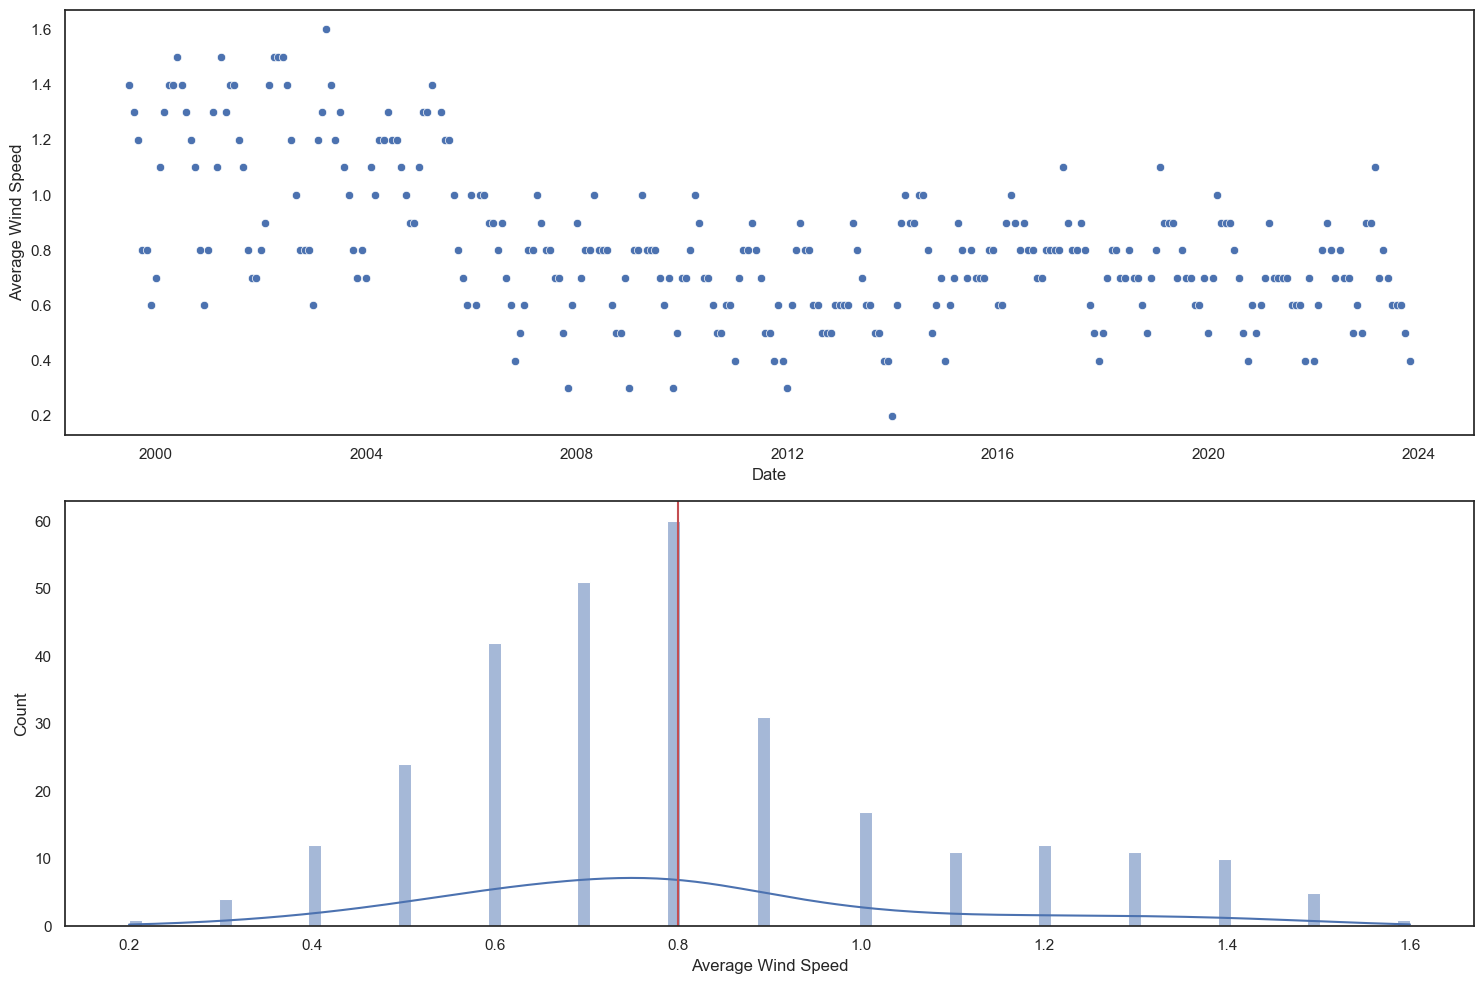

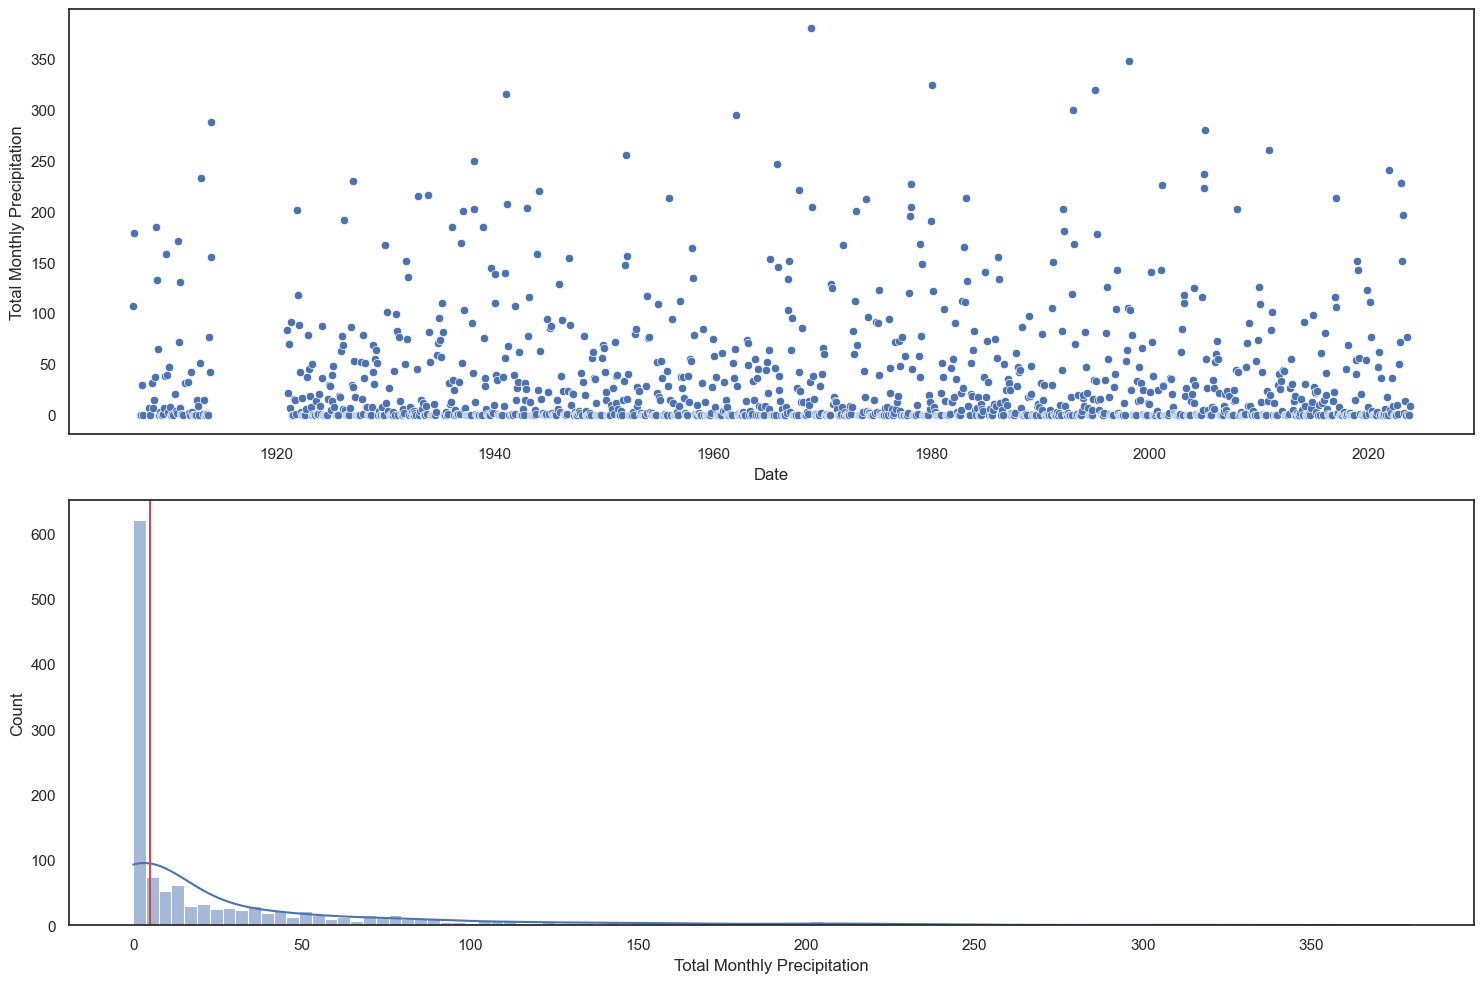

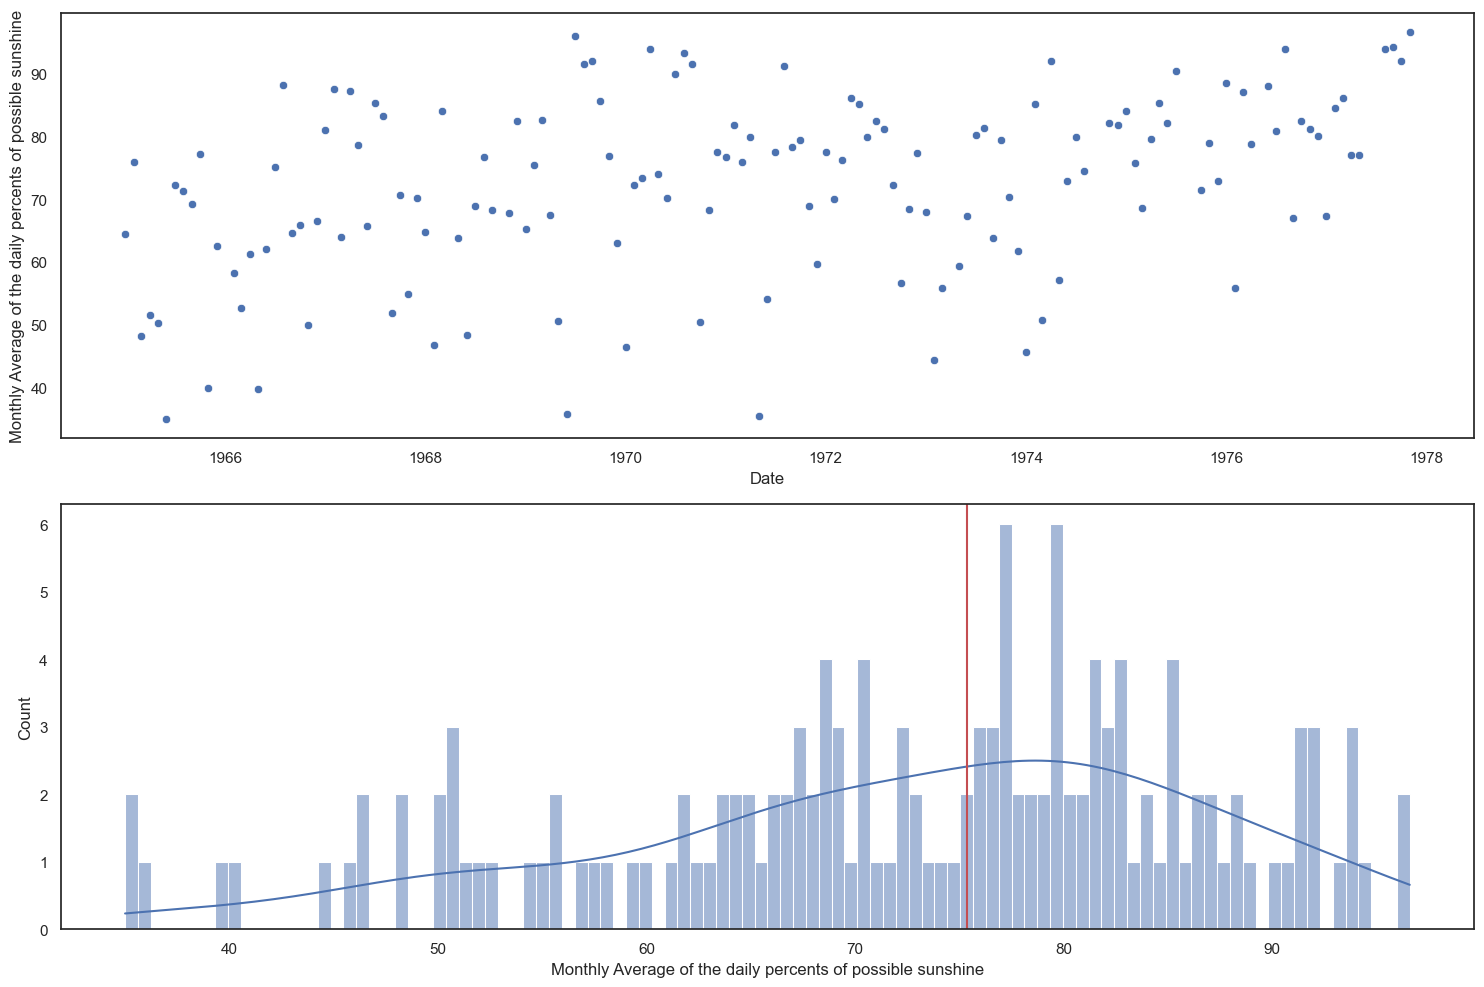

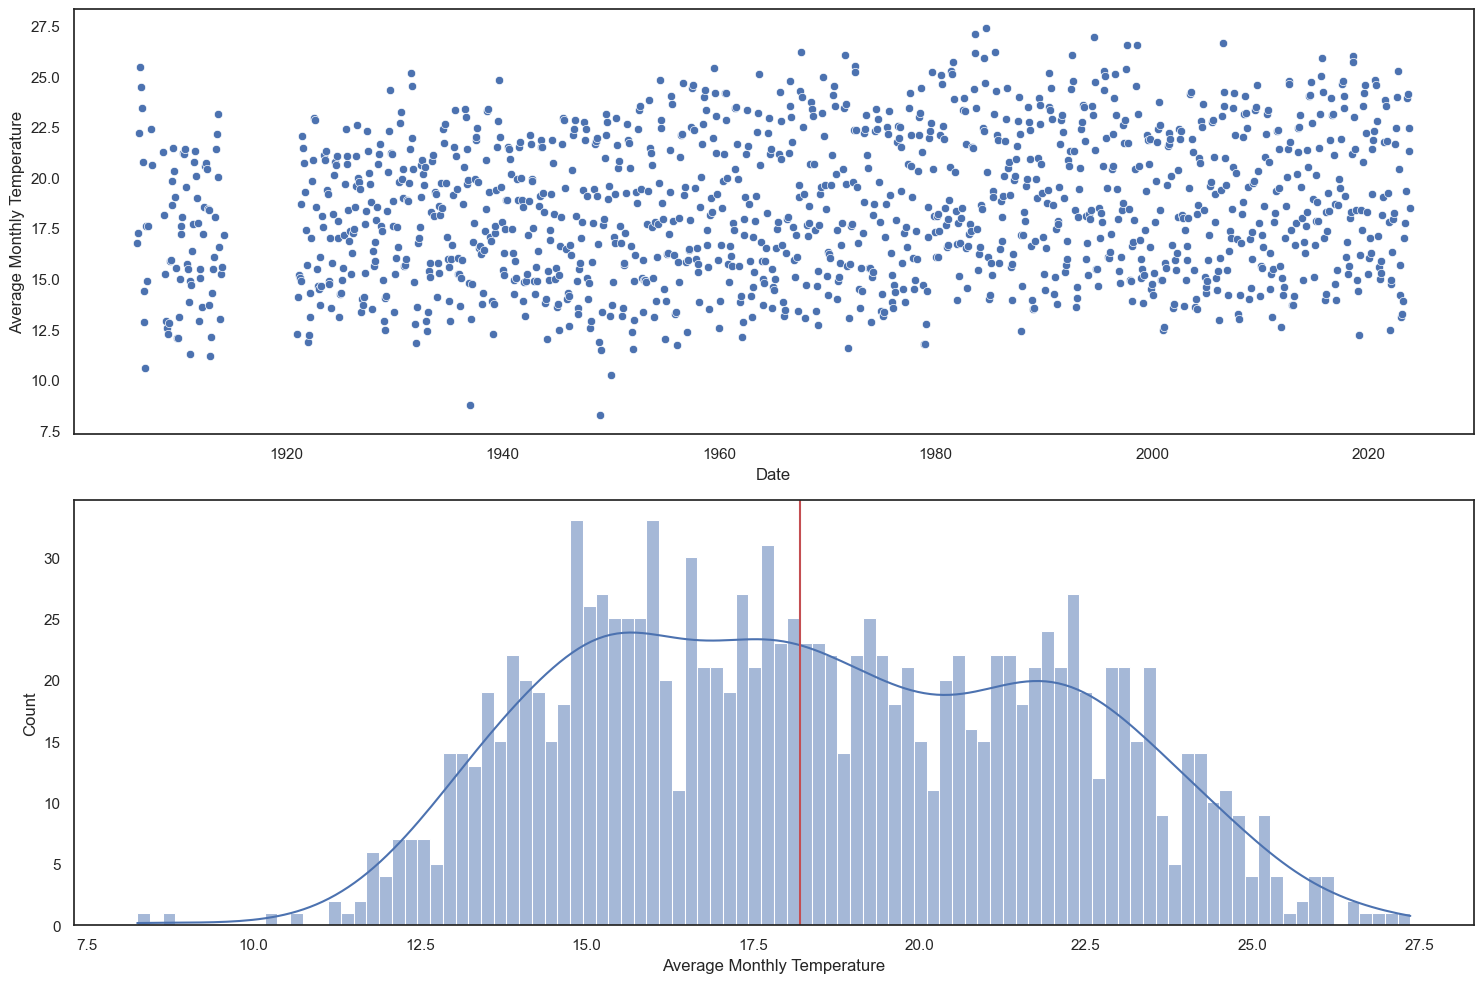

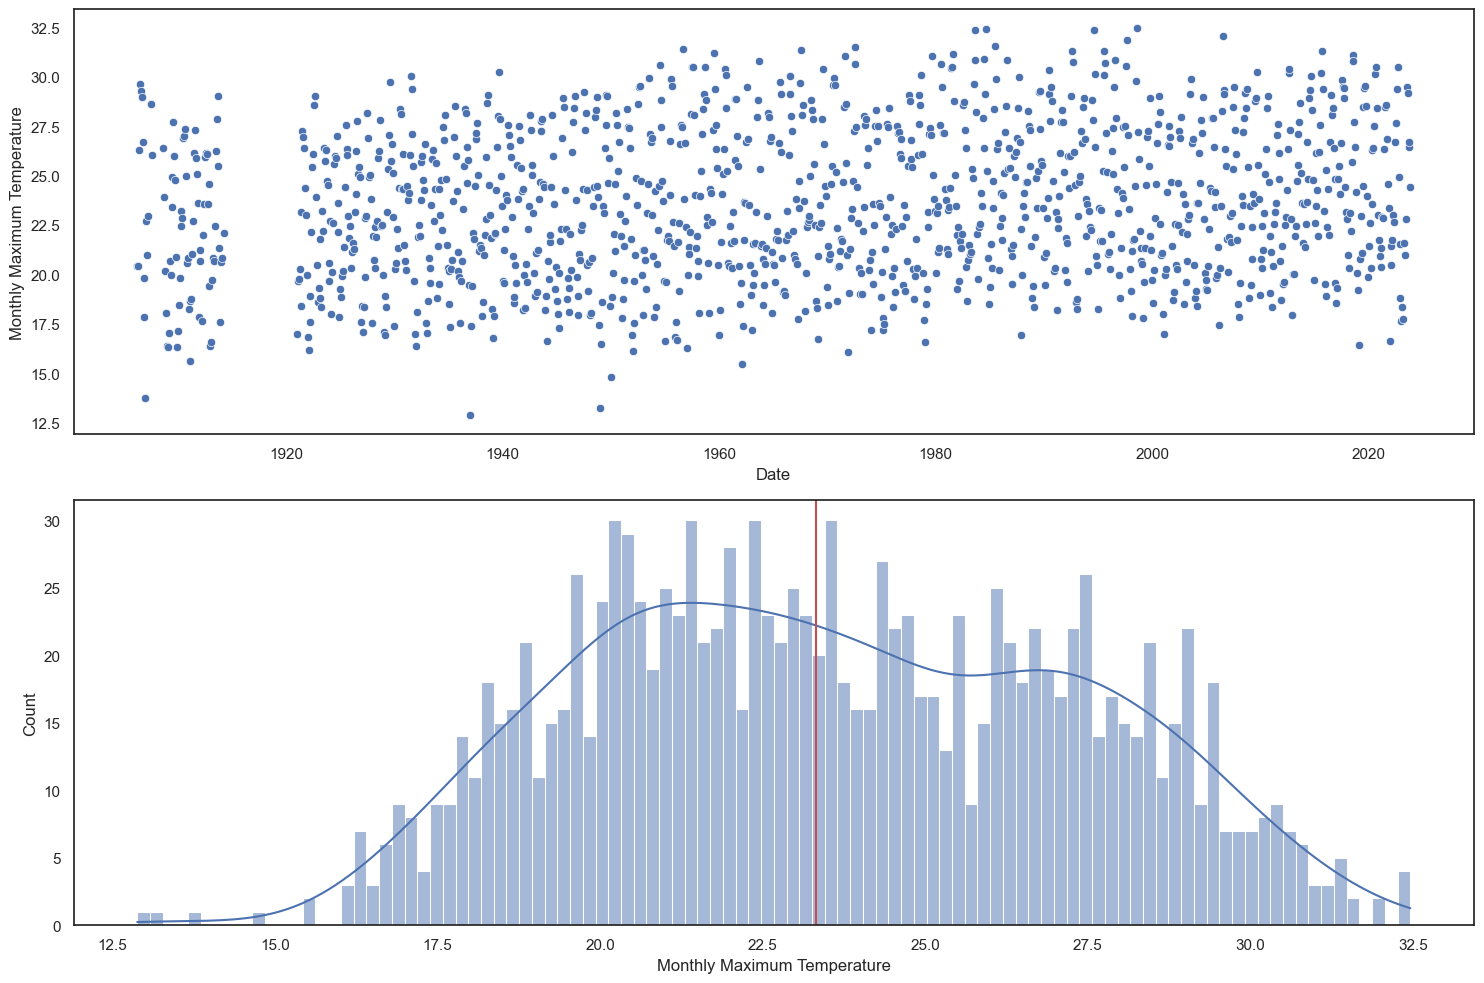

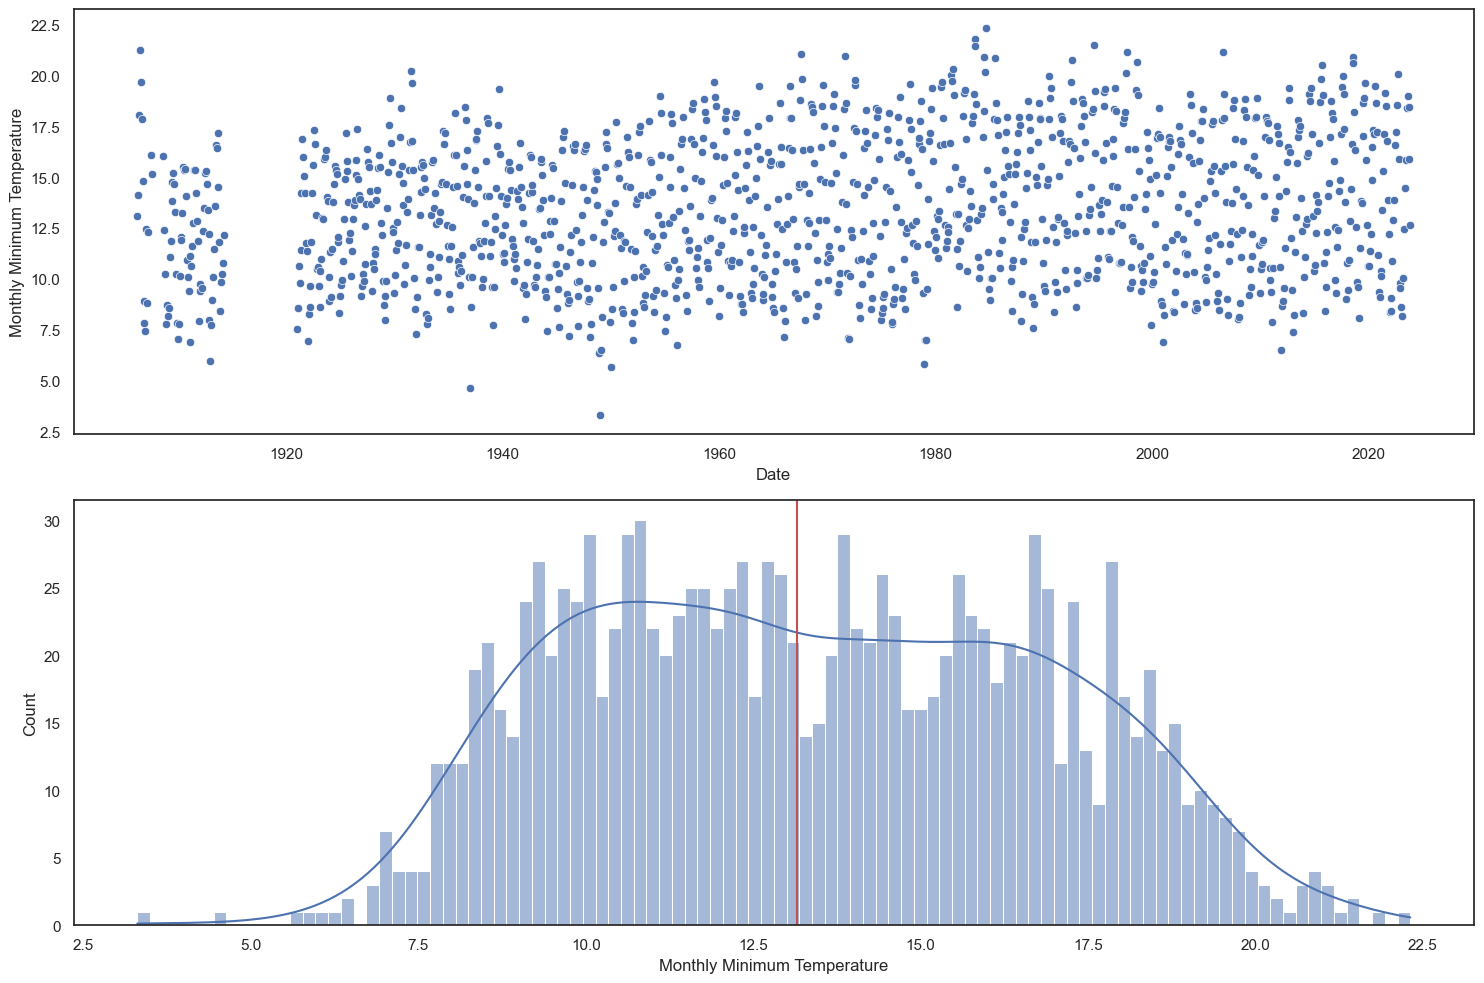

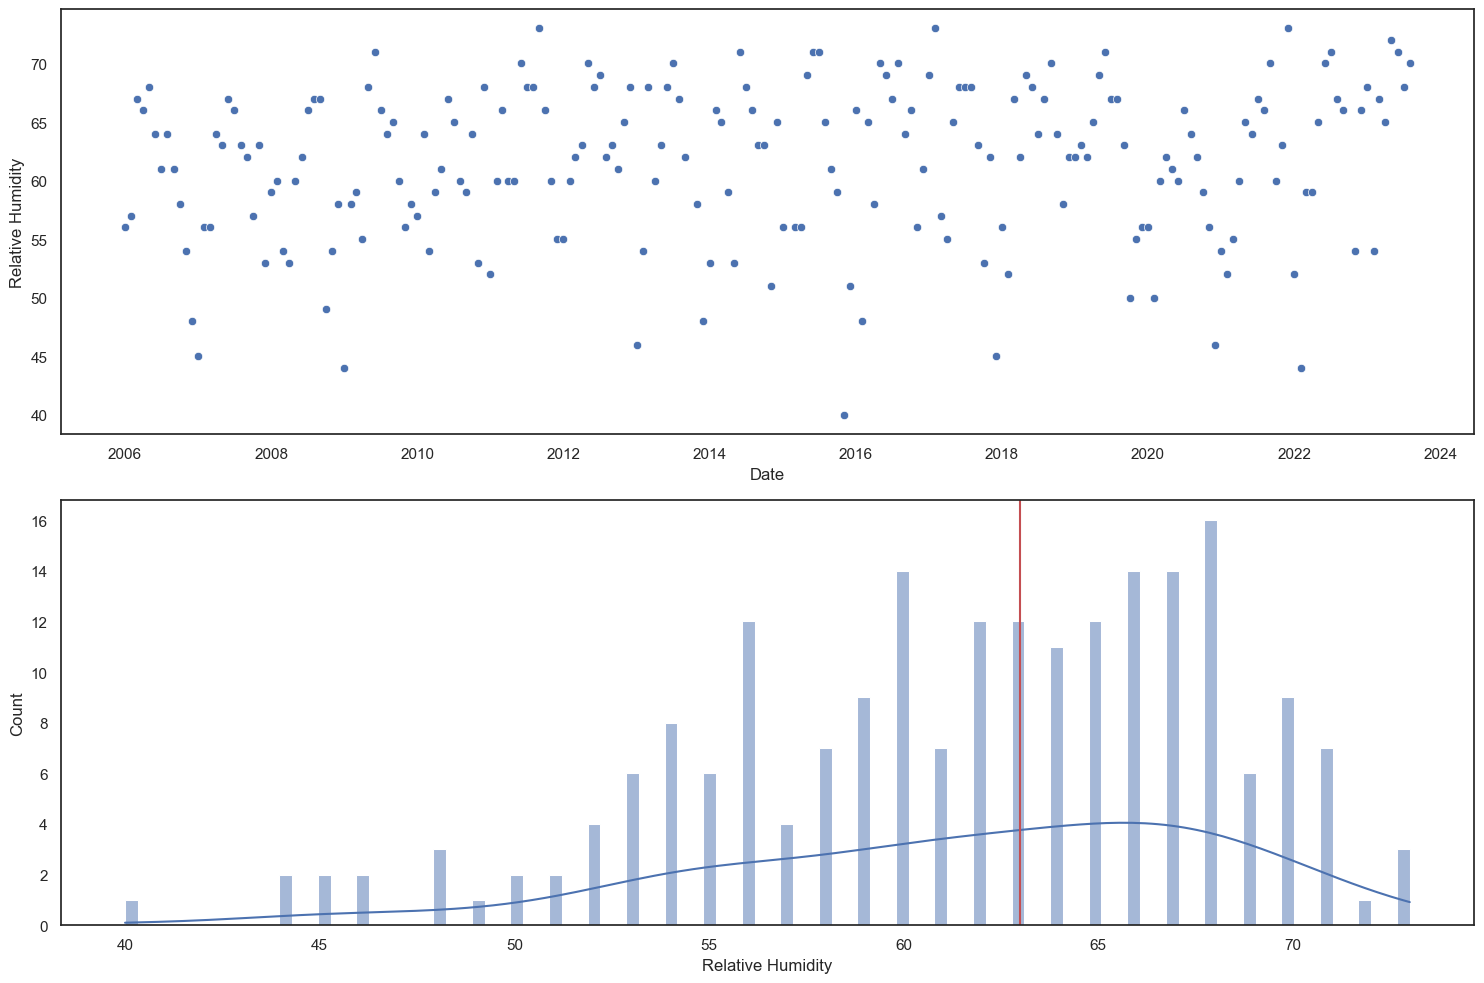

In [22]:
plot_climate(los)

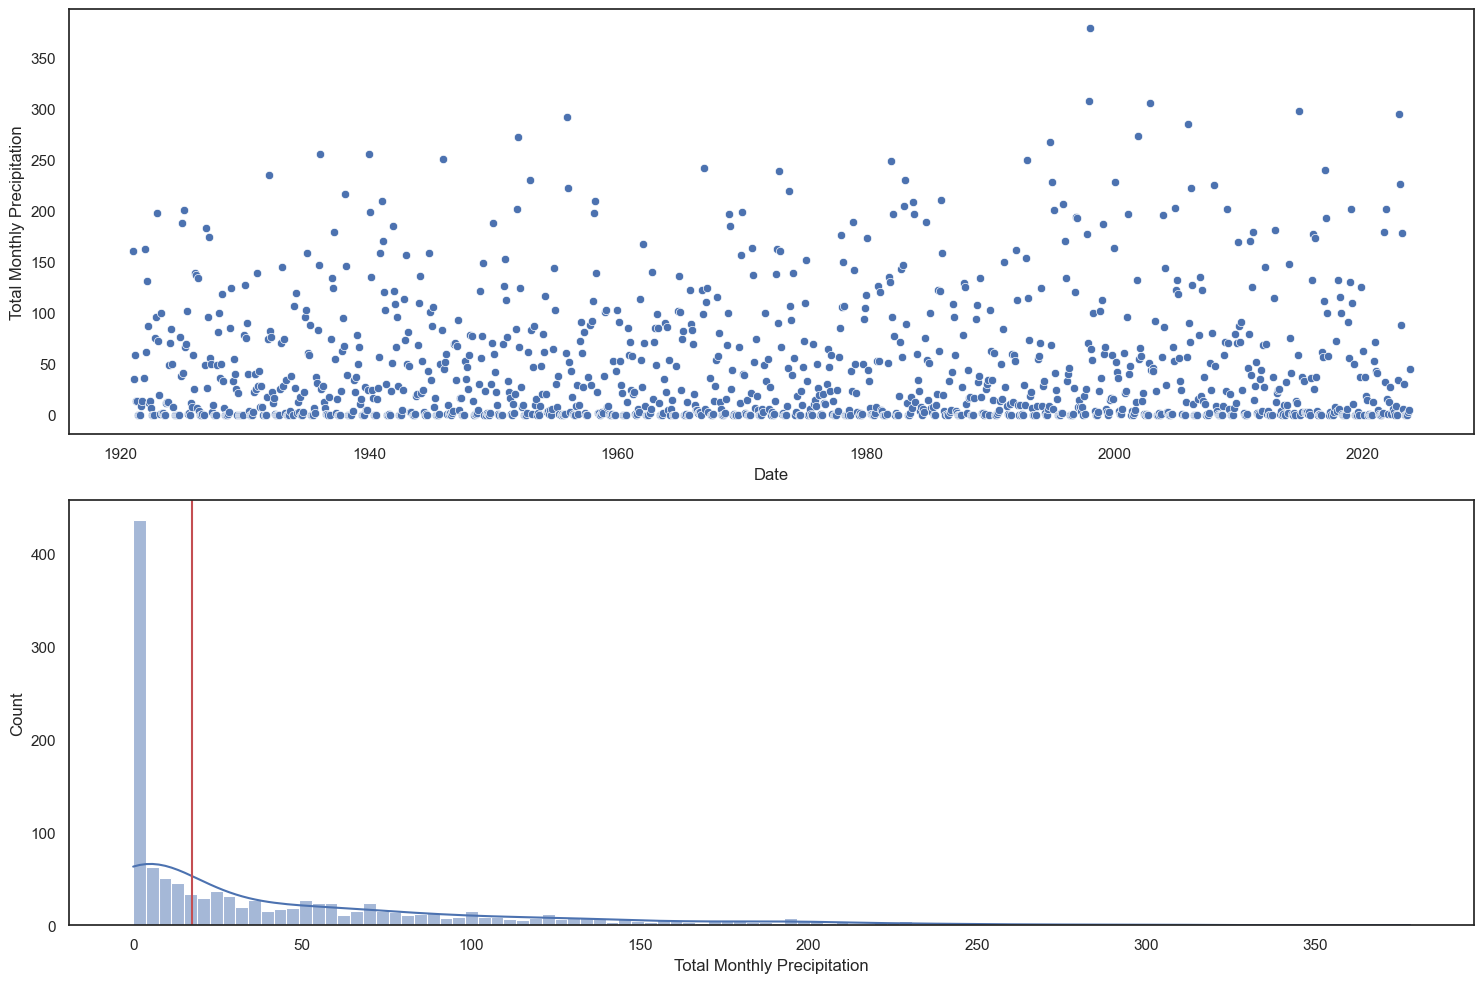

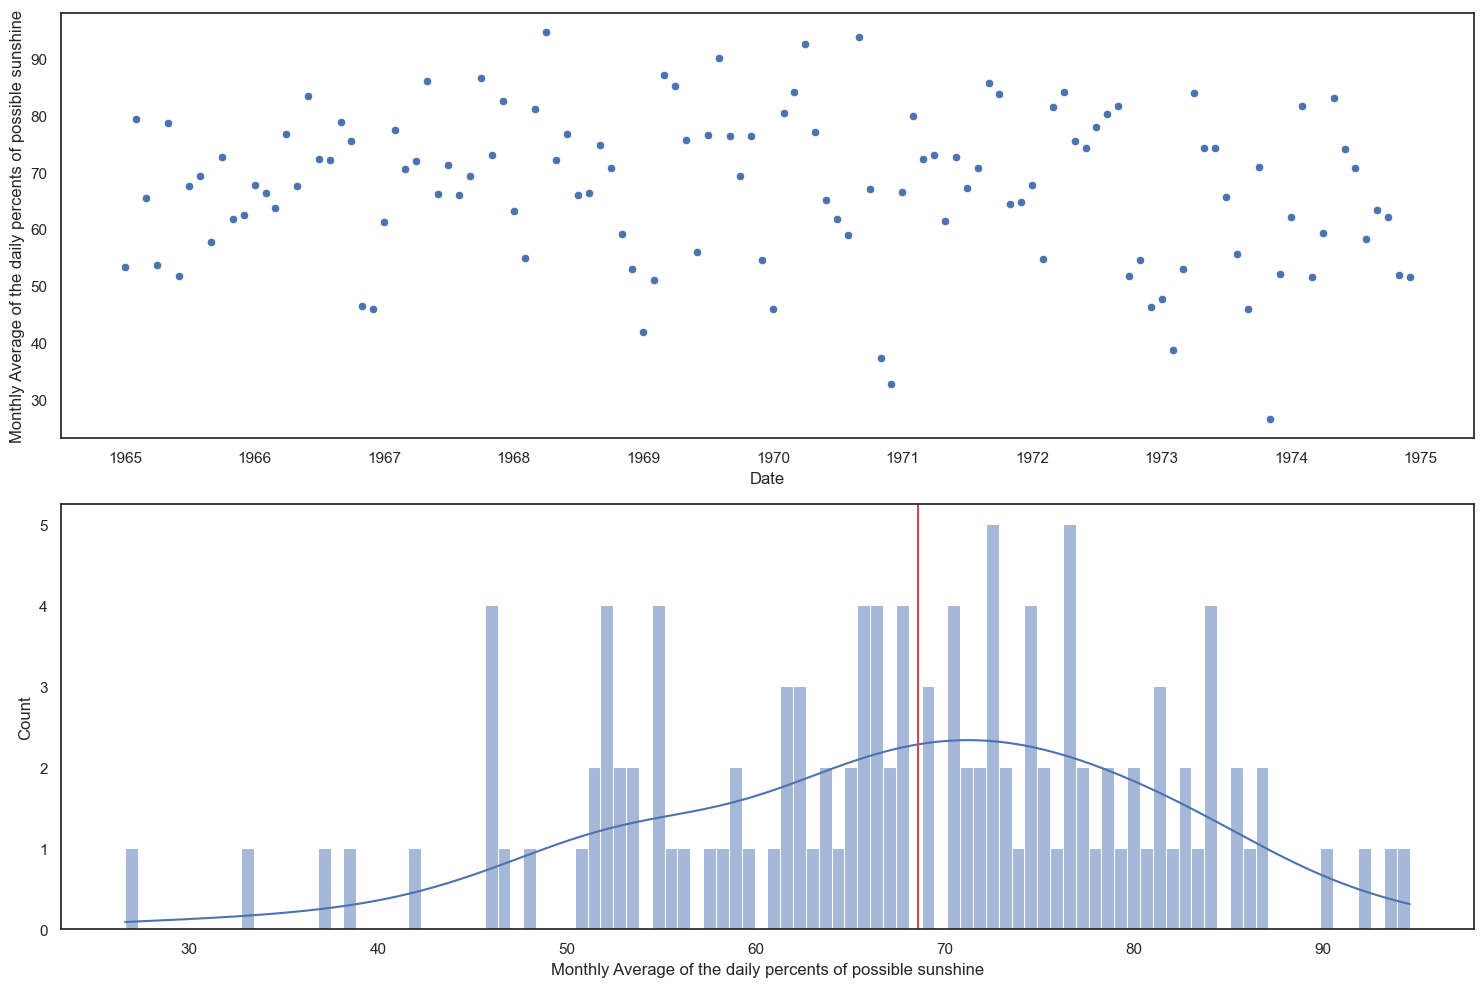

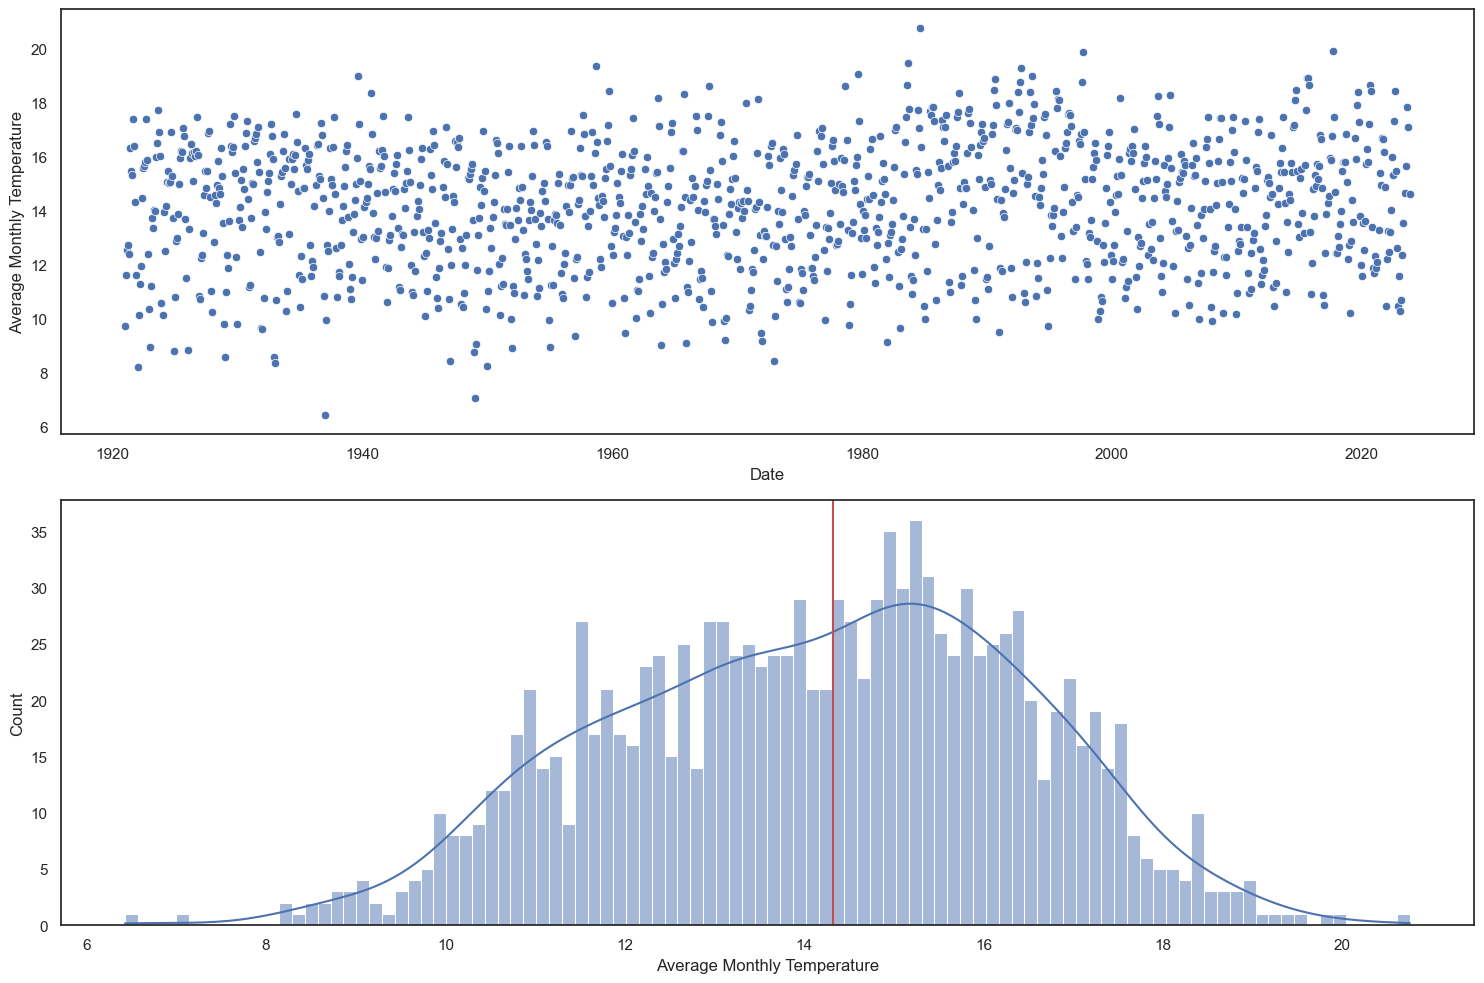

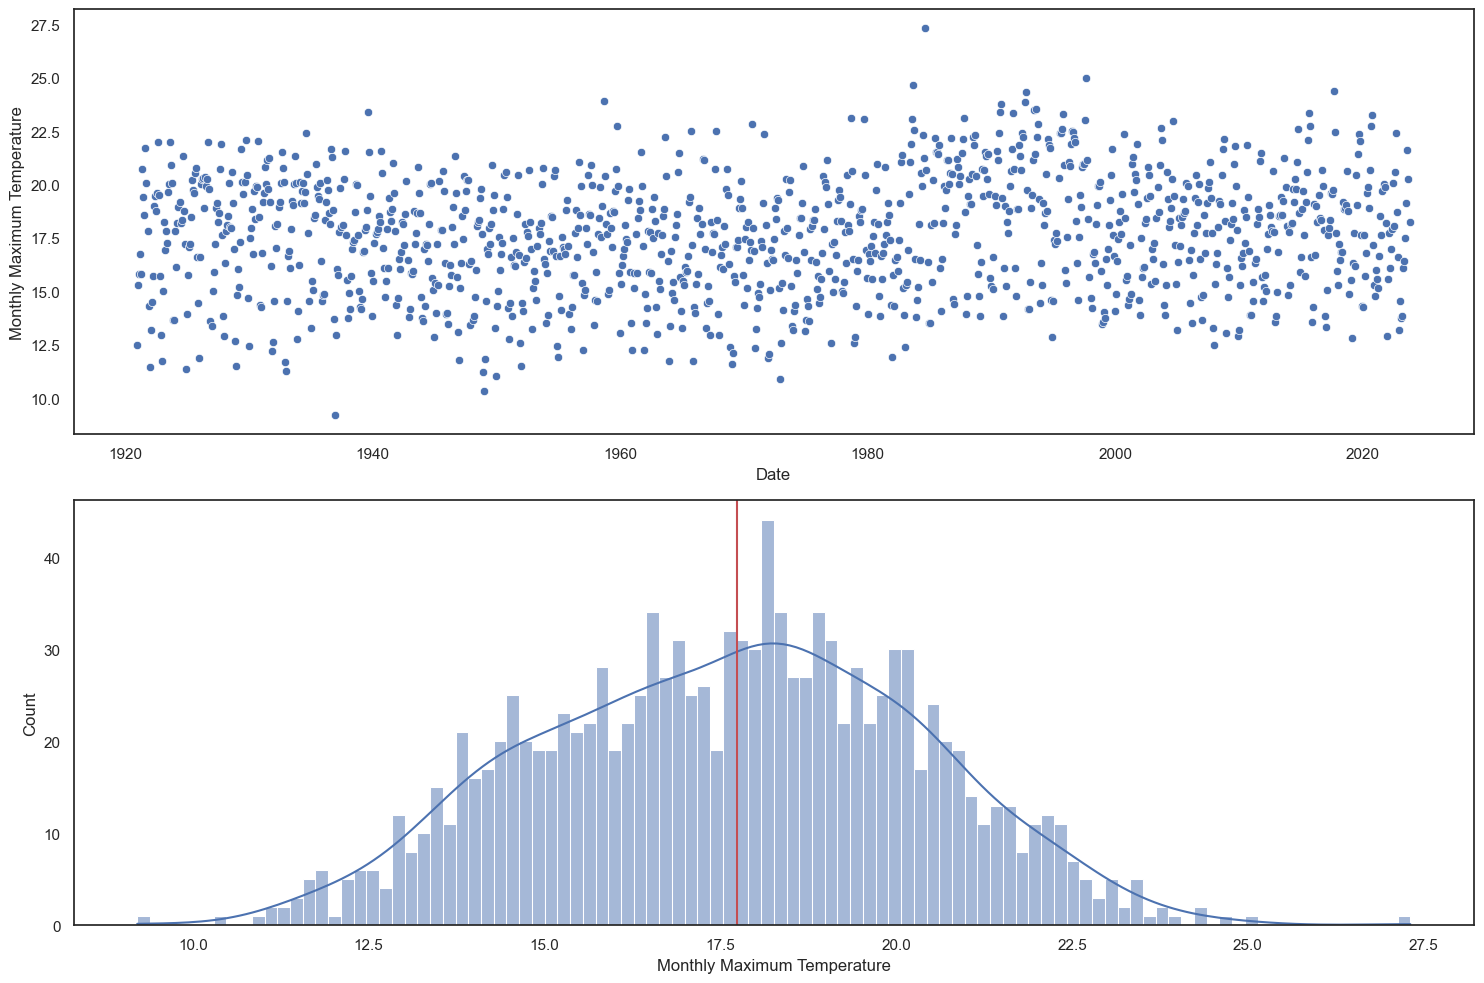

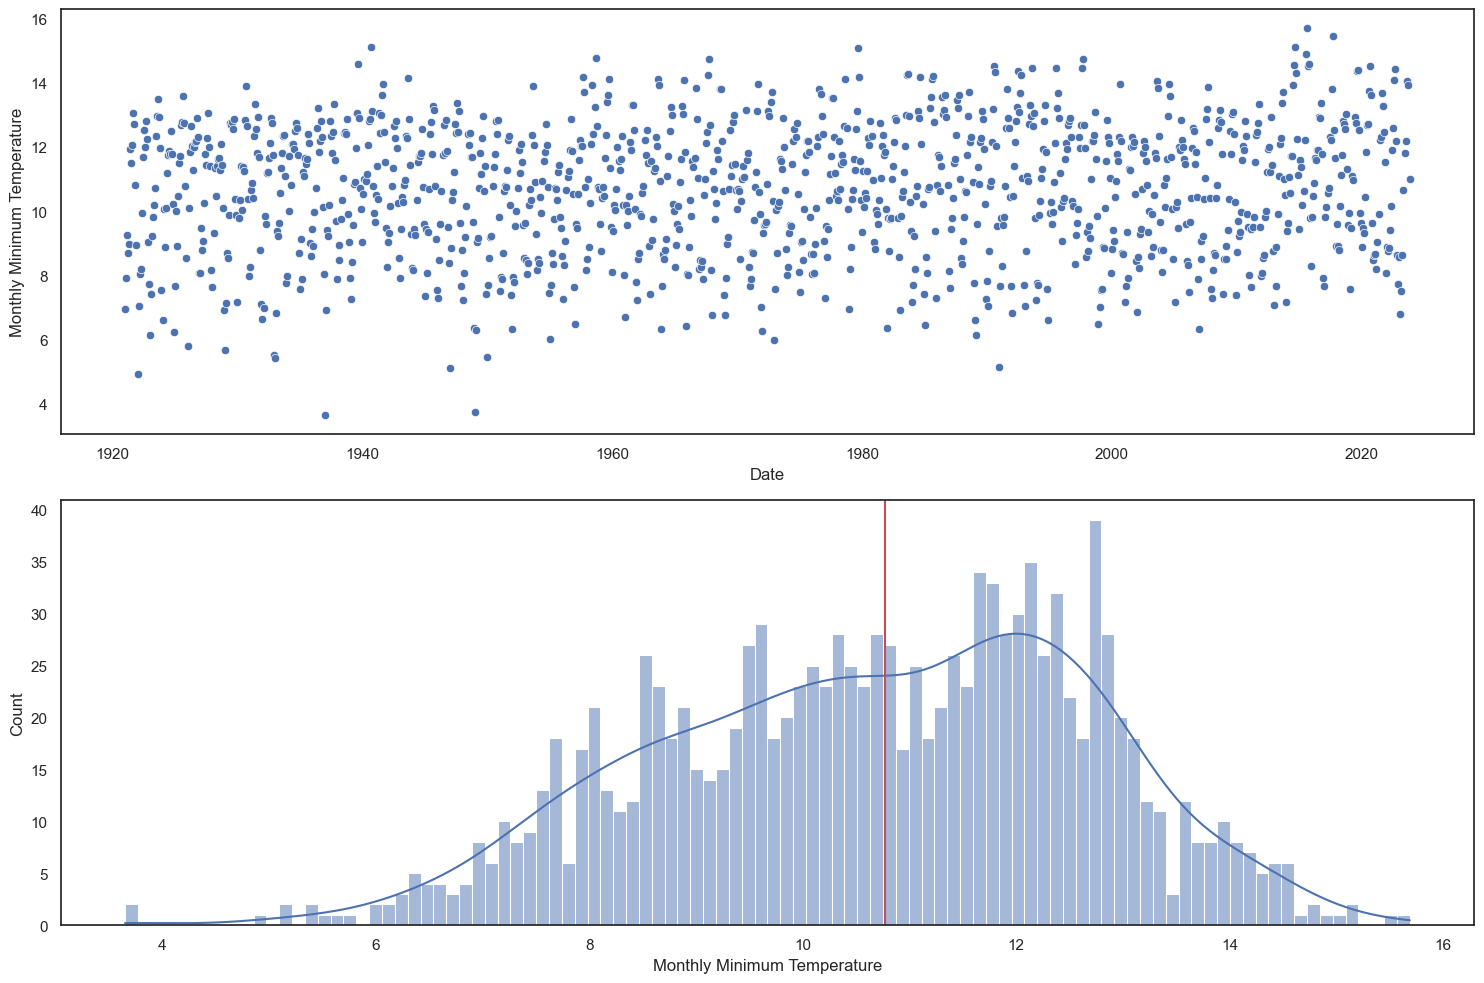

In [23]:
plot_climate(san)

In [125]:
ice_monthly[ice_monthly['Average Monthly Temperature'].notnull()].tail()

Average Dew Point Temperature  Average Wind Speed  \
Date                                                            
2010-07-31                            NaN                 NaN   
2010-08-31                            NaN                 NaN   
2010-09-30                            NaN                 NaN   
2010-10-31                            NaN                 NaN   
2010-12-31                            NaN                 NaN   

            Total Monthly Precipitation  \
Date                                      
2010-07-31                          NaN   
2010-08-31                          NaN   
2010-09-30                          NaN   
2010-10-31                          NaN   
2010-12-31                          NaN   

            Monthly Average of the daily percents of possible sunshine  \
Date                                                                     
2010-07-31                                                NaN            
2010-08-31                                                NaN            
2010-09-30                                                NaN            
2010-10-31                                                NaN            
2010-12-31                                                NaN            

            Average Monthly Temperature  Monthly Maximum Temperature  \
Date                                                                   
2010-07-31                       285.00                       287.10   
2010-08-31                       284.76                       286.68   
2010-09-30                       282.88                       284.20   
2010-10-31                       280.18                       281.71   
2010-12-31                       275.41                       277.93   

            Monthly Minimum Temperature  Relative Humidity      value  
Date                                                                   
2010-07-31                       282.90                NaN  387.42625  
2010-08-31                       282.84                NaN  382.29600  
2010-09-30                       281.57                NaN  384.20000  
2010-10-31                       278.65                NaN  389.51625  
2010-12-31                       272.88                NaN  396.52875

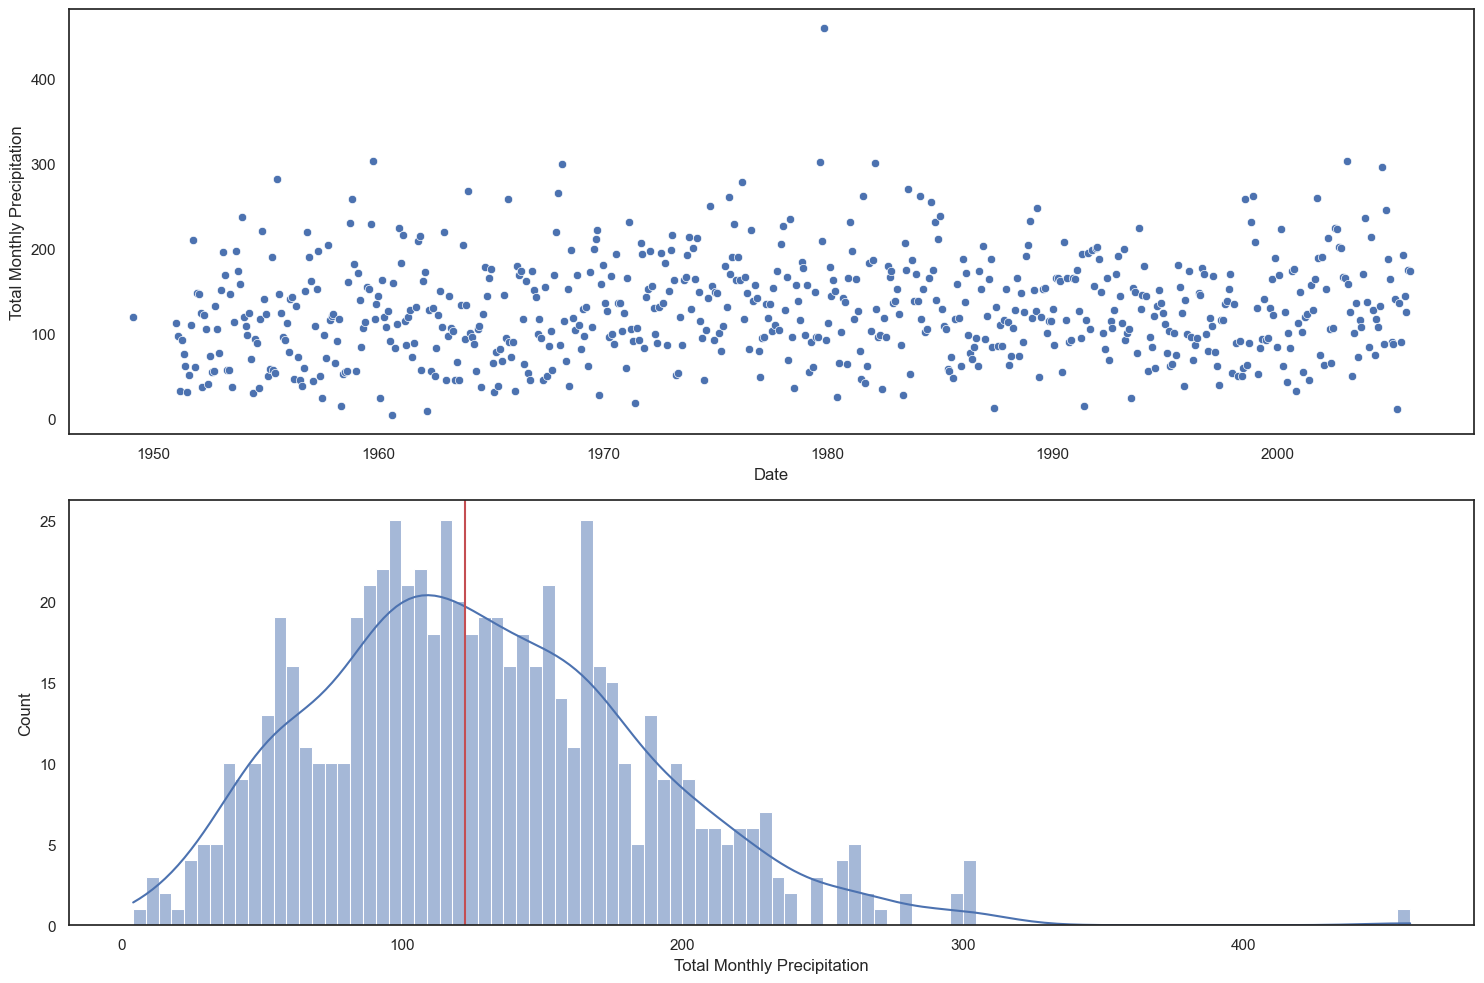

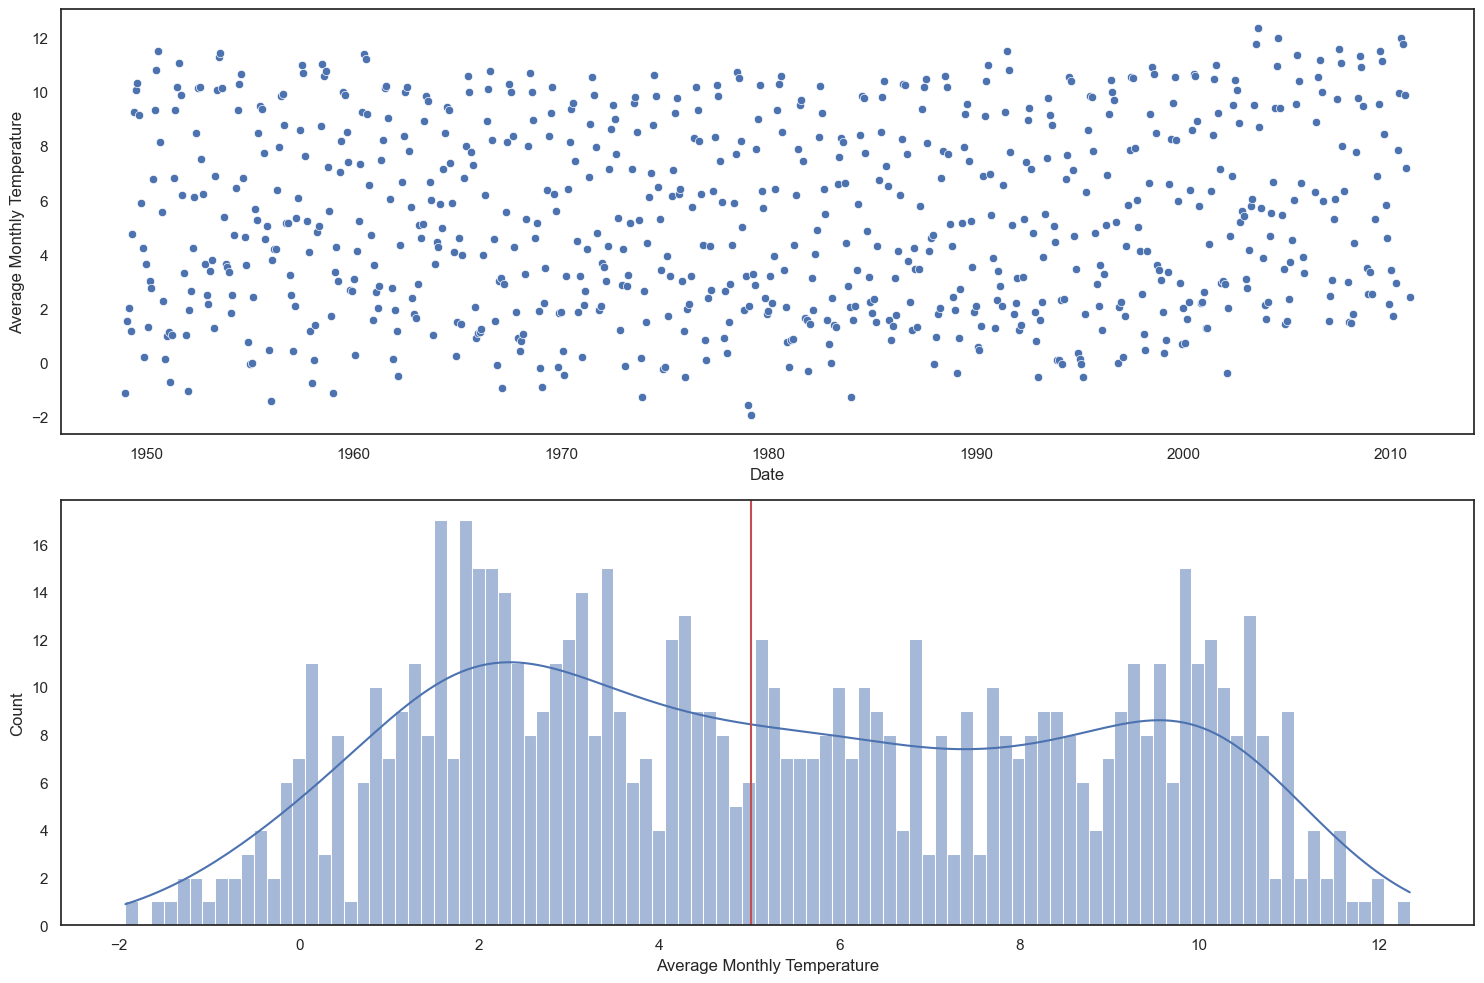

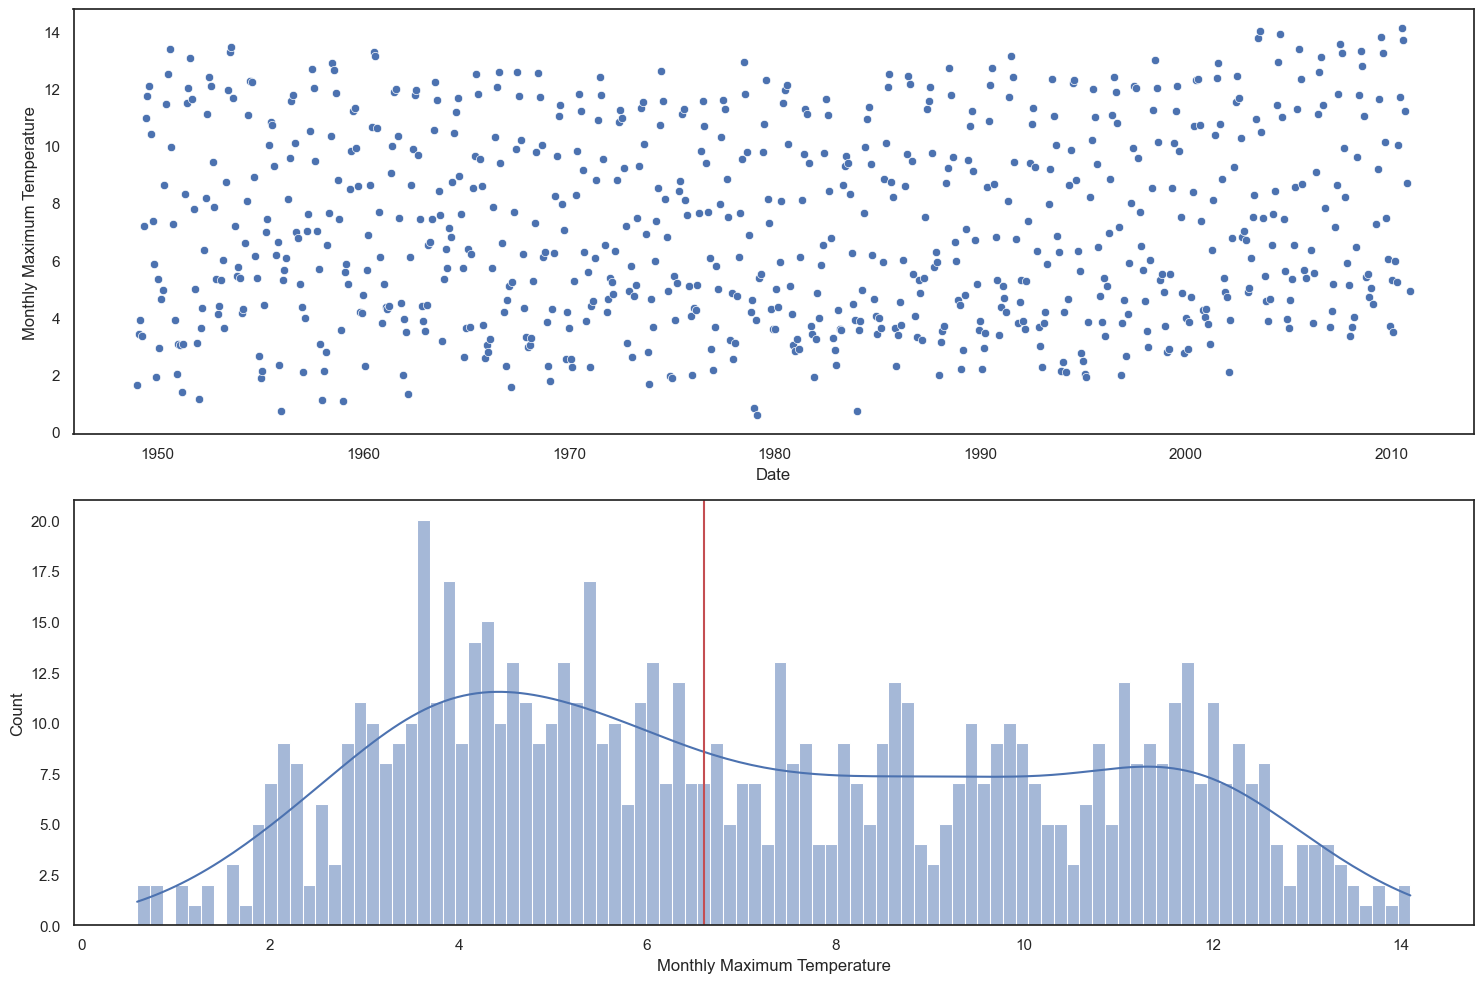

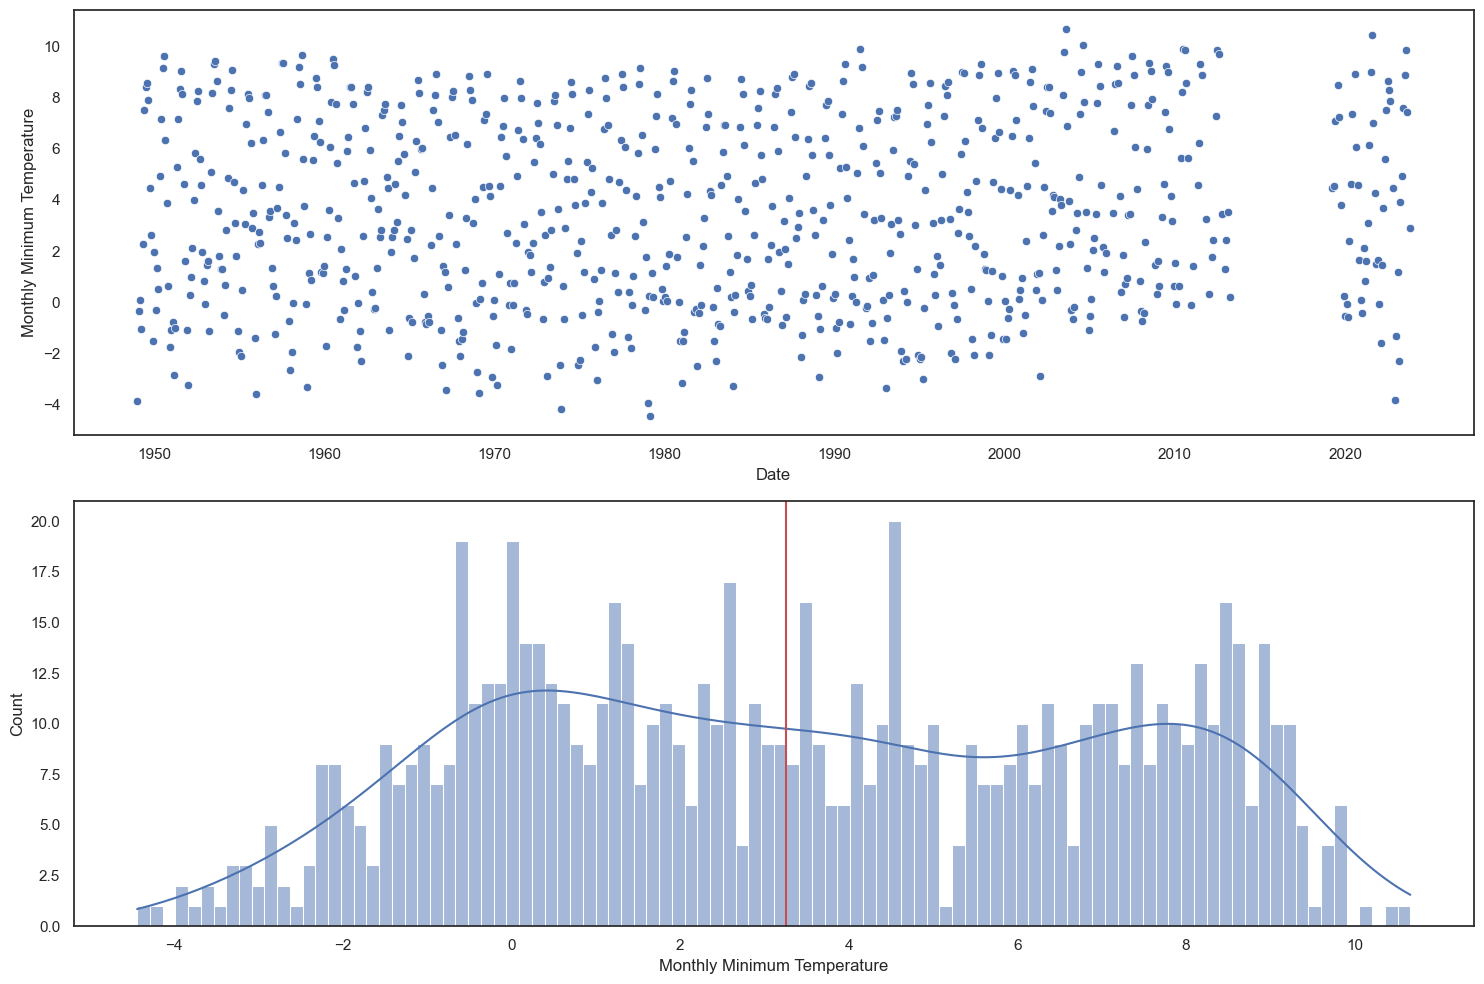

In [24]:
plot_climate(ice)

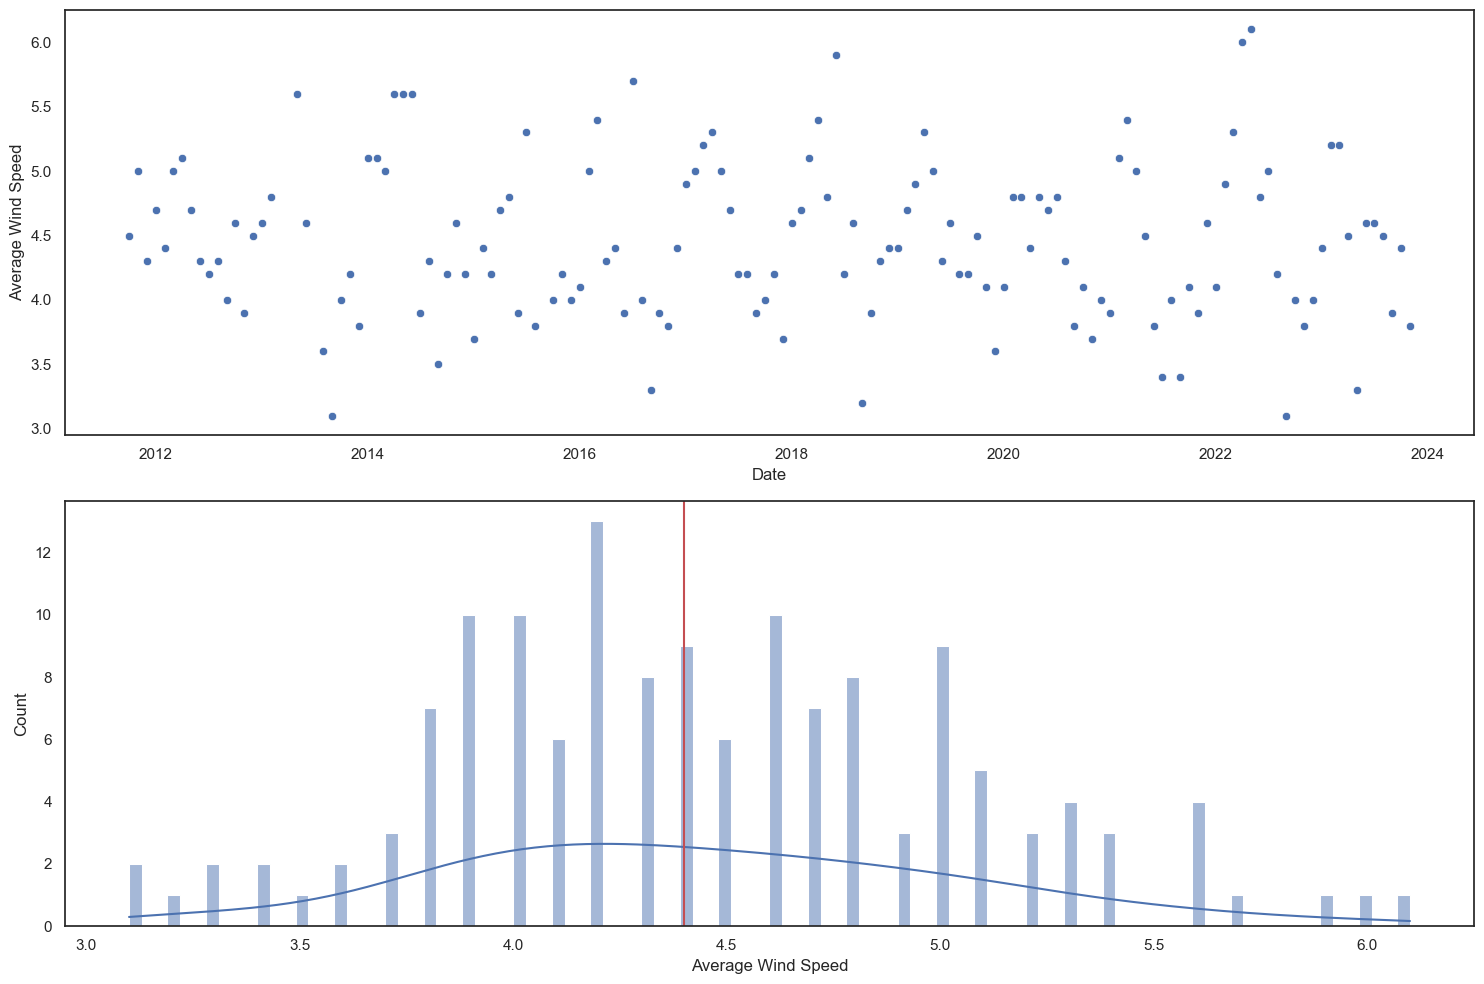

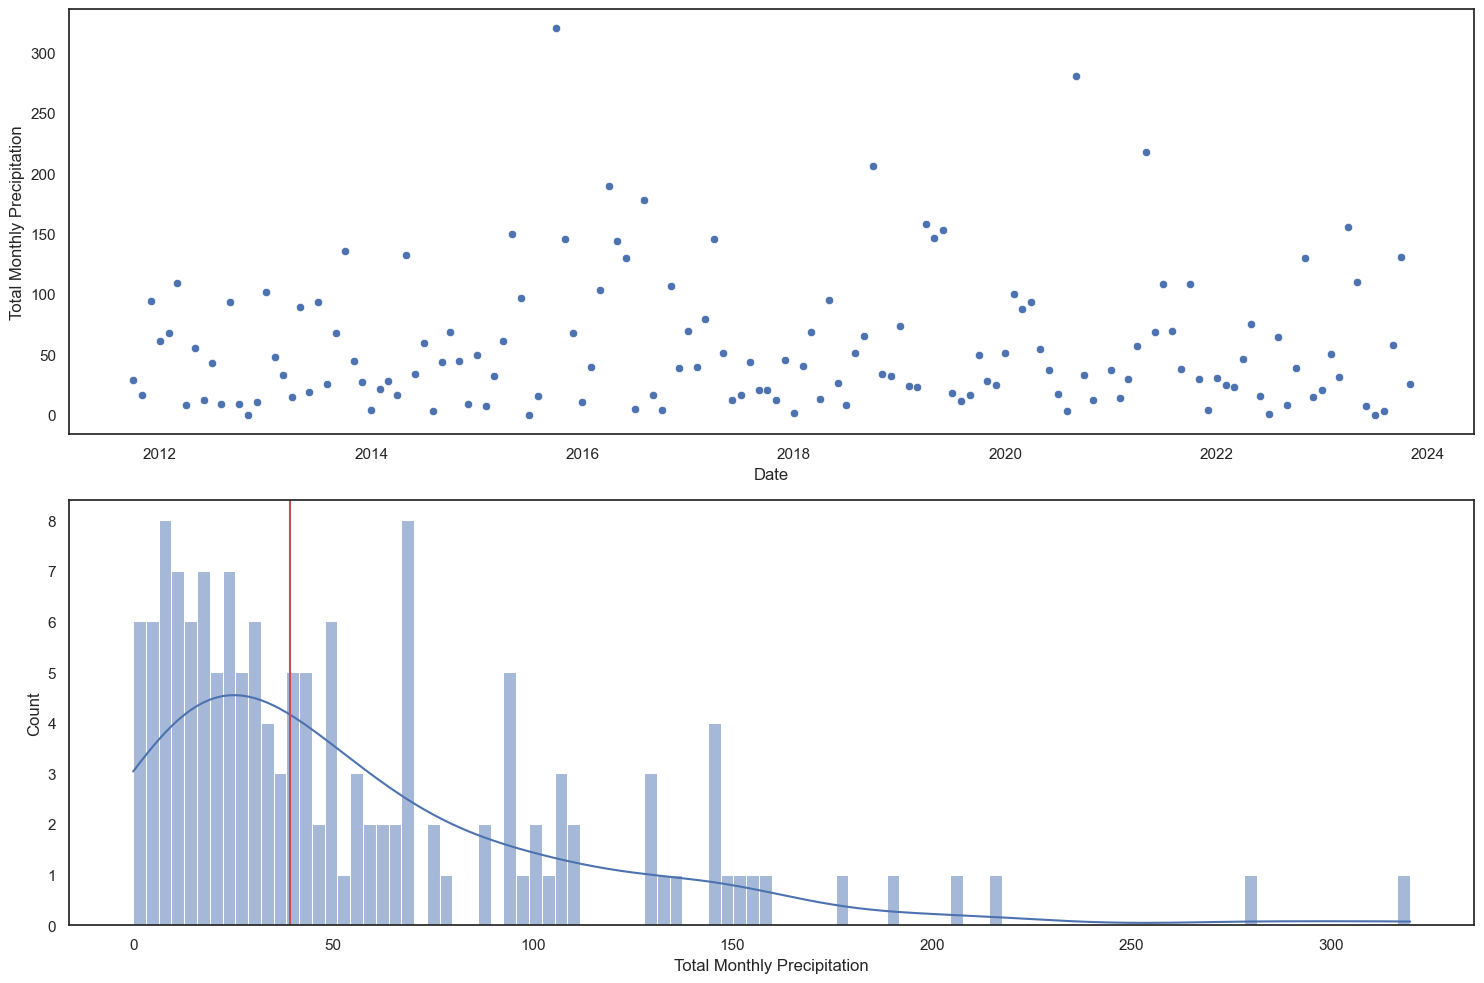

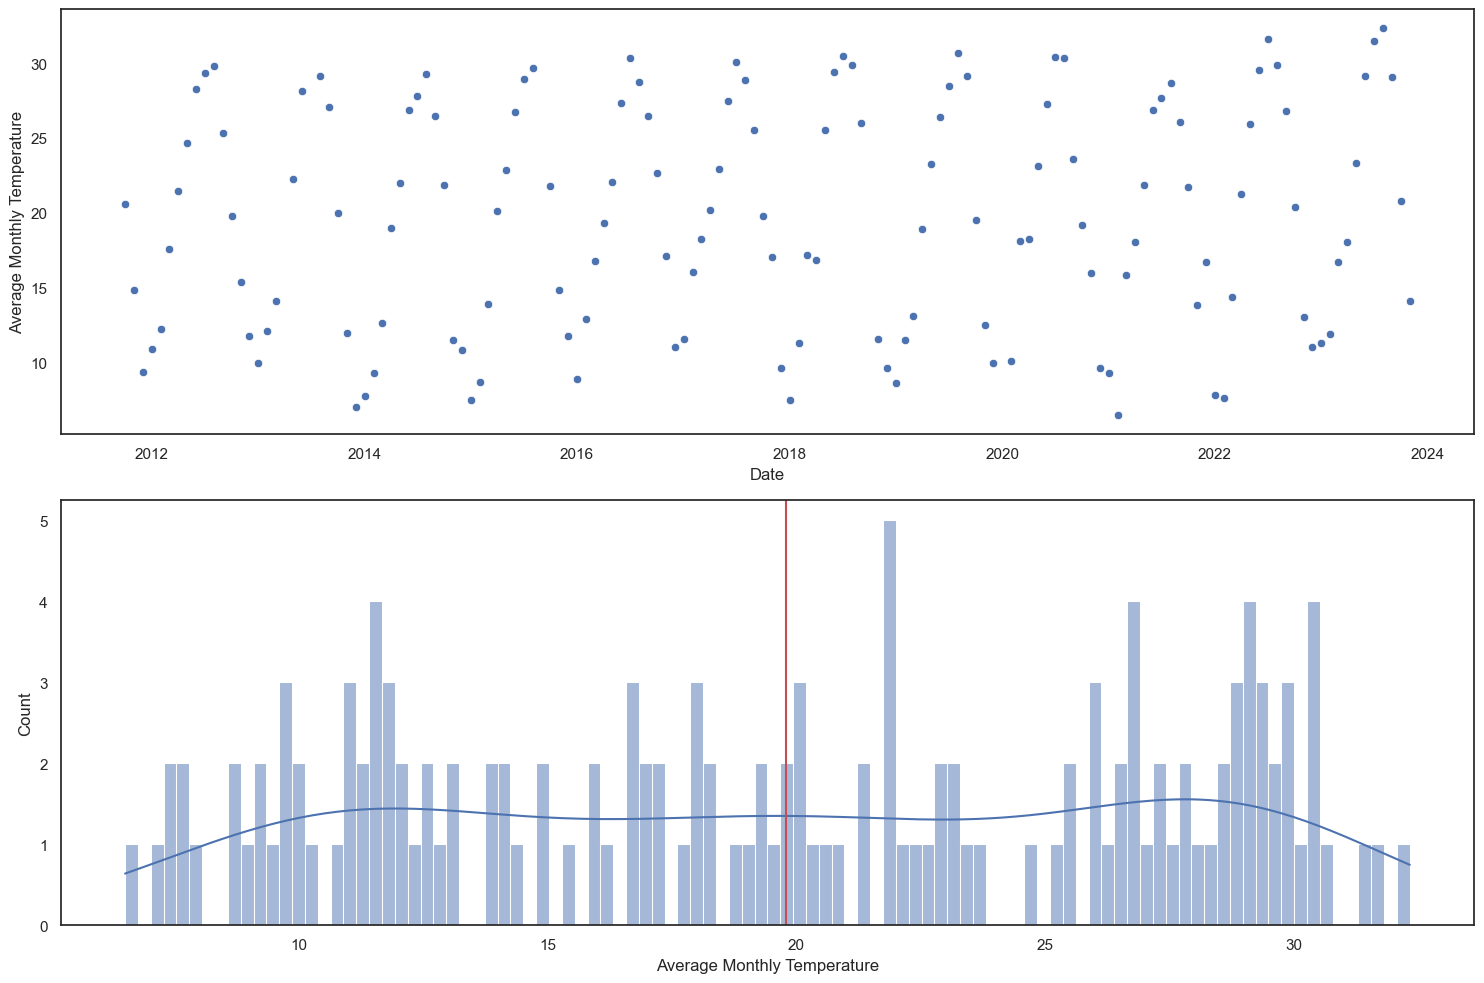

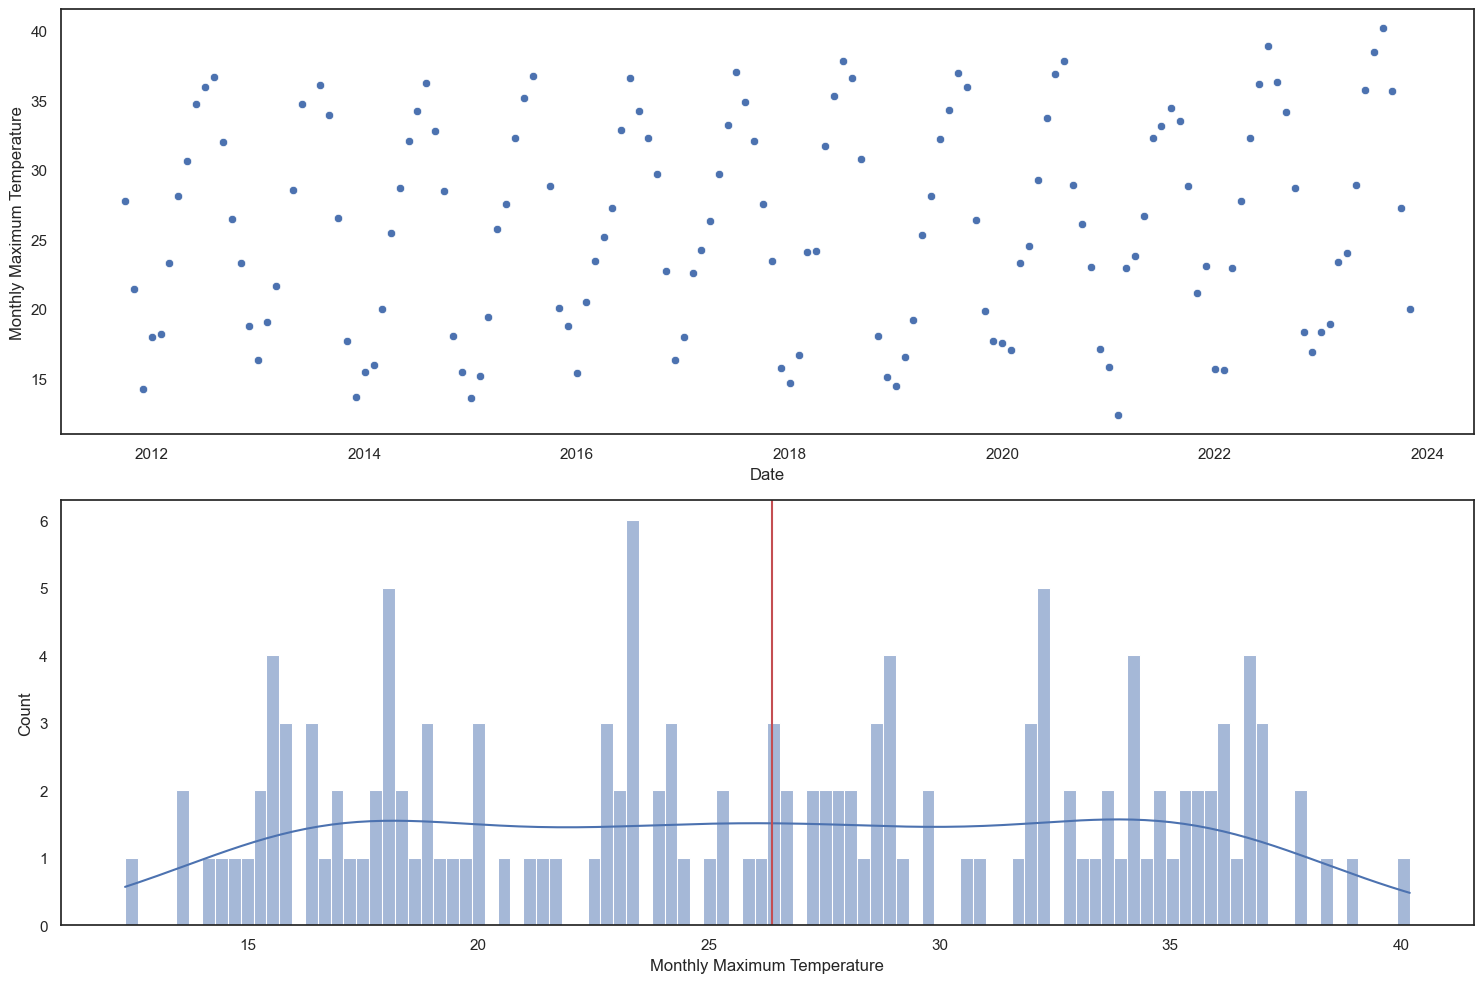

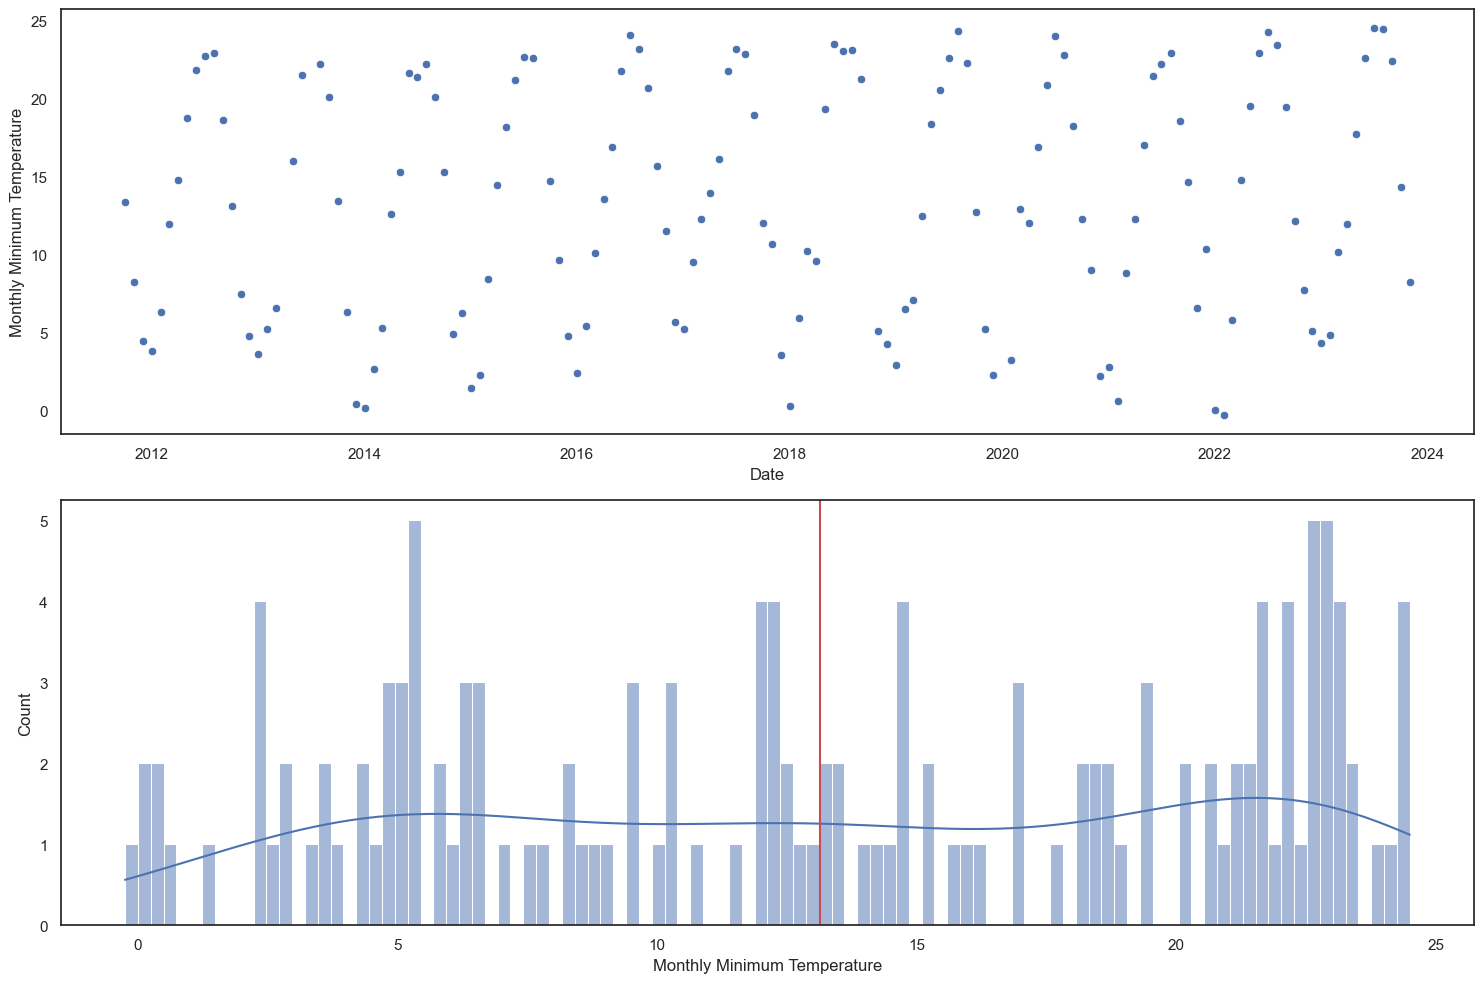

In [25]:
plot_climate(tem)

### Analysis of CO2 data

In [103]:
ice_co2

site_code  latitude  longitude   value
Date                                             
1992-10-01       ICE   63.3998   -20.2884  352.01
1992-10-01       ICE   63.3998   -20.2884  351.95
1992-10-01       ICE   63.3998   -20.2884  350.37
1992-10-01       ICE   63.3998   -20.2884  351.65
1992-10-01       ICE   63.3998   -20.2884  351.64
...              ...       ...        ...     ...
2022-11-01       ICE   63.3998   -20.2884  422.55
2022-12-01       ICE   63.3998   -20.2884  422.66
2022-12-01       ICE   63.3998   -20.2884  422.68
2022-12-01       ICE   63.3998   -20.2884  424.49
2022-12-01       ICE   63.3998   -20.2884  424.56

[2770 rows x 4 columns]

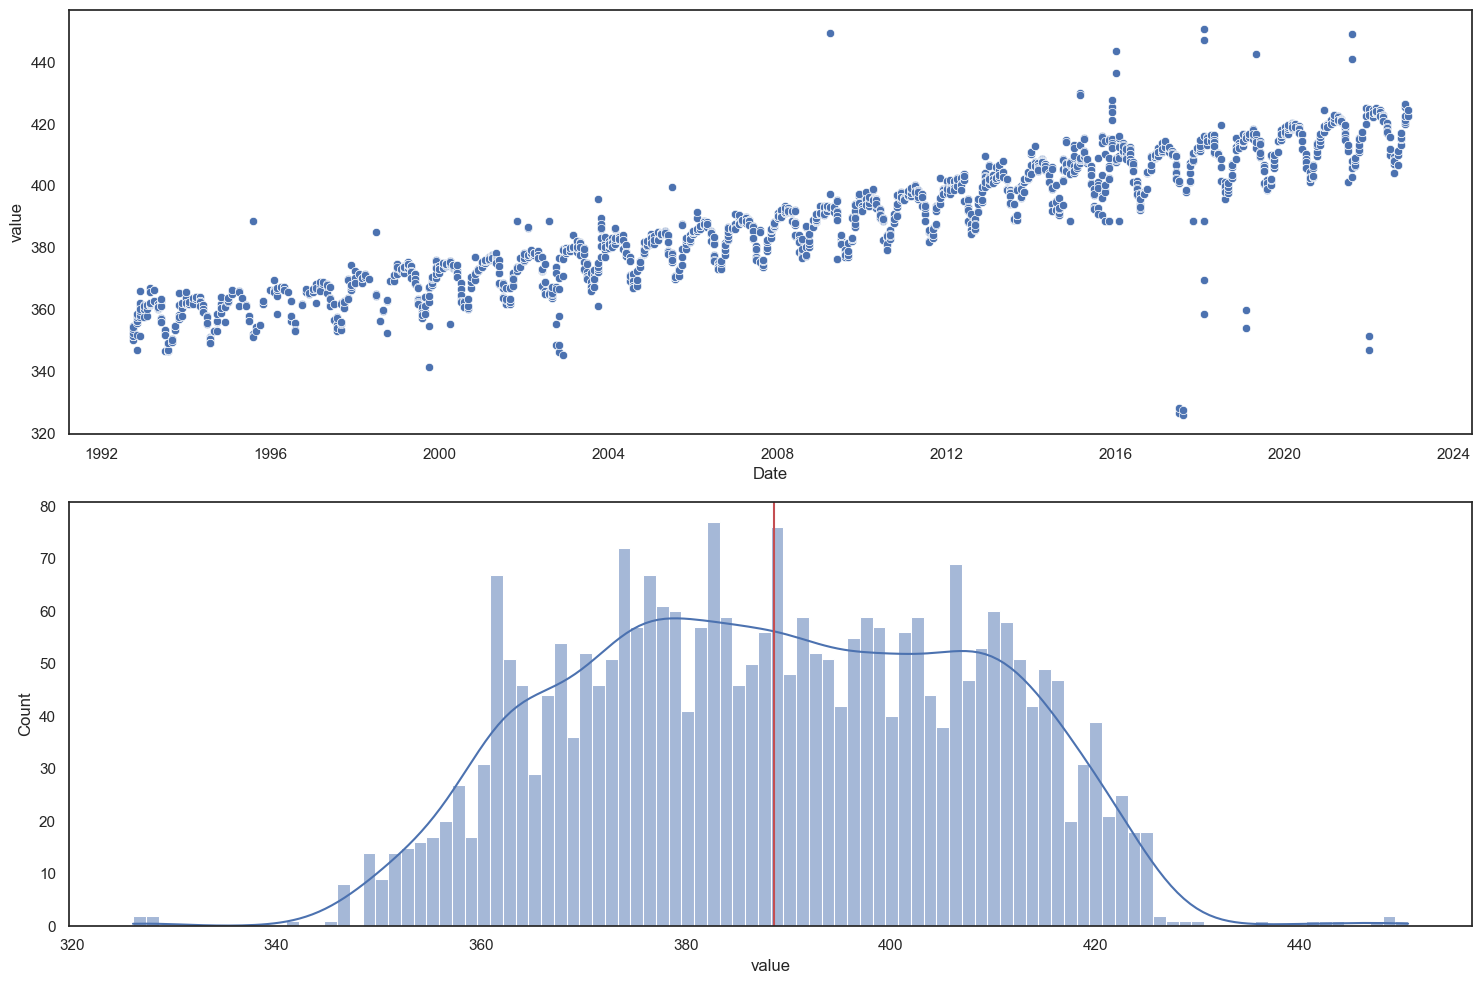

In [98]:
plot('value', df=ice_co2)

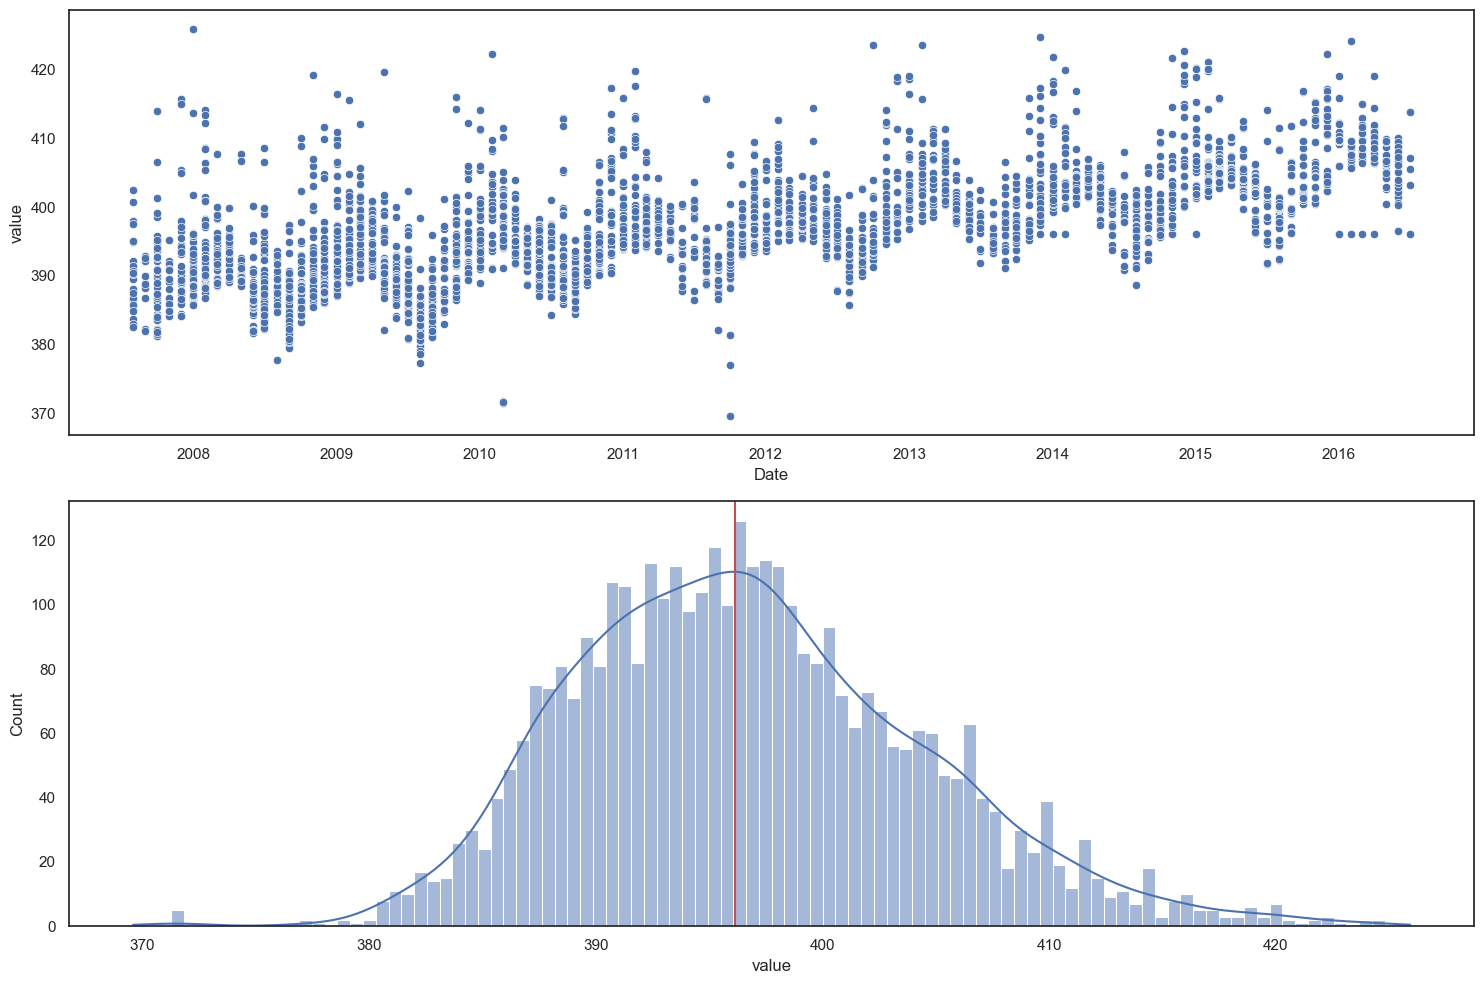

In [27]:
bou_co2 = outlier(bou_co2)

plot('value', df=bou_co2)

In [28]:
hil_co2 = outlier(hil_co2)
hoh_co2 = outlier(hoh_co2)
cap_co2 = outlier(cap_co2)
los_co2 = outlier(los_co2)
san_co2 = outlier(san_co2)
ice_co2 = outlier(ice_co2)
tem_co2 = outlier(tem_co2)

In [29]:
print(
    'Z-score of CO2 values of Boulder:', Z_score(bou_co2['value']),
    '\nZ-score of CO2 values of Hilo International:', Z_score(hil_co2['value']),
    '\nZ-score of CO2 values of Hohpeissenberg:', Z_score(hoh_co2['value']),
    '\nZ-score of CO2 values of Cape Florida:', Z_score(cap_co2['value']),
    '\nZ-score of CO2 values of Los Angeles:', Z_score(los_co2['value']),
    '\nZ-score of CO2 values of San Francisco:', Z_score(san_co2['value']),
    '\nZ-score of CO2 values of Iceland:', Z_score(ice_co2['value']),
    '\nZ-score of CO2 values of Moody:', Z_score(tem_co2['value'])
)

Z-score of CO2 values of Boulder: 0.23117399232059263 
Z-score of CO2 values of Hilo International: 0.47760382093152465 
Z-score of CO2 values of Hohpeissenberg: 0.4253315515684668 
Z-score of CO2 values of Cape Florida: 1.206942593685808 
Z-score of CO2 values of Los Angeles: 0.5247437433336416 
Z-score of CO2 values of San Francisco: 0.6728577398170772 
Z-score of CO2 values of Iceland: 0.41000183796122436 
Z-score of CO2 values of Moody: 1.1738197053449395


Data is skewed more to the right.

In [30]:
def boxplot(y_value, df, title):
    sns.set(rc={'figure.figsize':(15,8)})
    sns.set_style('white')
    sns.boxplot(data=df, x=df.index, y=y_value).set_title(title, fontsize=25)
    plt.ylabel('CO2 Emissions')
    plt.xticks(rotation=90)

In [31]:
print(
    'Start and end time of CO2 data of Boulder, CO:', bou_co2.index[0],'-',bou_co2.index[-1],
    '\nStart and end time of CO2 data of Hilo International, HI:', hil_co2.index[0],'-',hil_co2.index[-1],
    '\nStart and end time of CO2 data of Hohenpeissenberg, GM:', hoh_co2.index[0],'-',hoh_co2.index[-1],
    '\nStart and end time of CO2 data of Cape Florida, FL:', cap_co2.index[0],'-',cap_co2.index[-1],
    '\nStart and end time of CO2 data of Los Angeles, CA:', los_co2.index[0],'-',los_co2.index[-1],
    '\nStart and end time of CO2 data of San Francisco, CA:', san_co2.index[0],'-',san_co2.index[-1],
    '\nStart and end time of CO2 data of Vestmannaeyjar, IC:', ice_co2.index[0],'-',ice_co2.index[-1],
    '\nStart and end time of CO2 data of Temple, TX:', tem_co2.index[0],'-',tem_co2.index[-1]
)

Start and end time of CO2 data of Boulder, CO: 2007-08-01 00:00:00 - 2016-07-01 00:00:00 
Start and end time of CO2 data of Hilo International, HI: 1969-08-01 00:00:00 - 2022-12-01 00:00:00 
Start and end time of CO2 data of Hohenpeissenberg, GM: 2006-04-01 00:00:00 - 2022-12-01 00:00:00 
Start and end time of CO2 data of Cape Florida, FL: 1972-12-01 00:00:00 - 2022-12-01 00:00:00 
Start and end time of CO2 data of Los Angeles, CA: 2010-04-01 00:00:00 - 2022-12-01 00:00:00 
Start and end time of CO2 data of San Francisco, CA: 2007-10-01 00:00:00 - 2022-12-01 00:00:00 
Start and end time of CO2 data of Vestmannaeyjar, IC: 1992-10-01 00:00:00 - 2022-12-01 00:00:00 
Start and end time of CO2 data of Temple, TX: 2006-07-01 00:00:00 - 2022-12-01 00:00:00


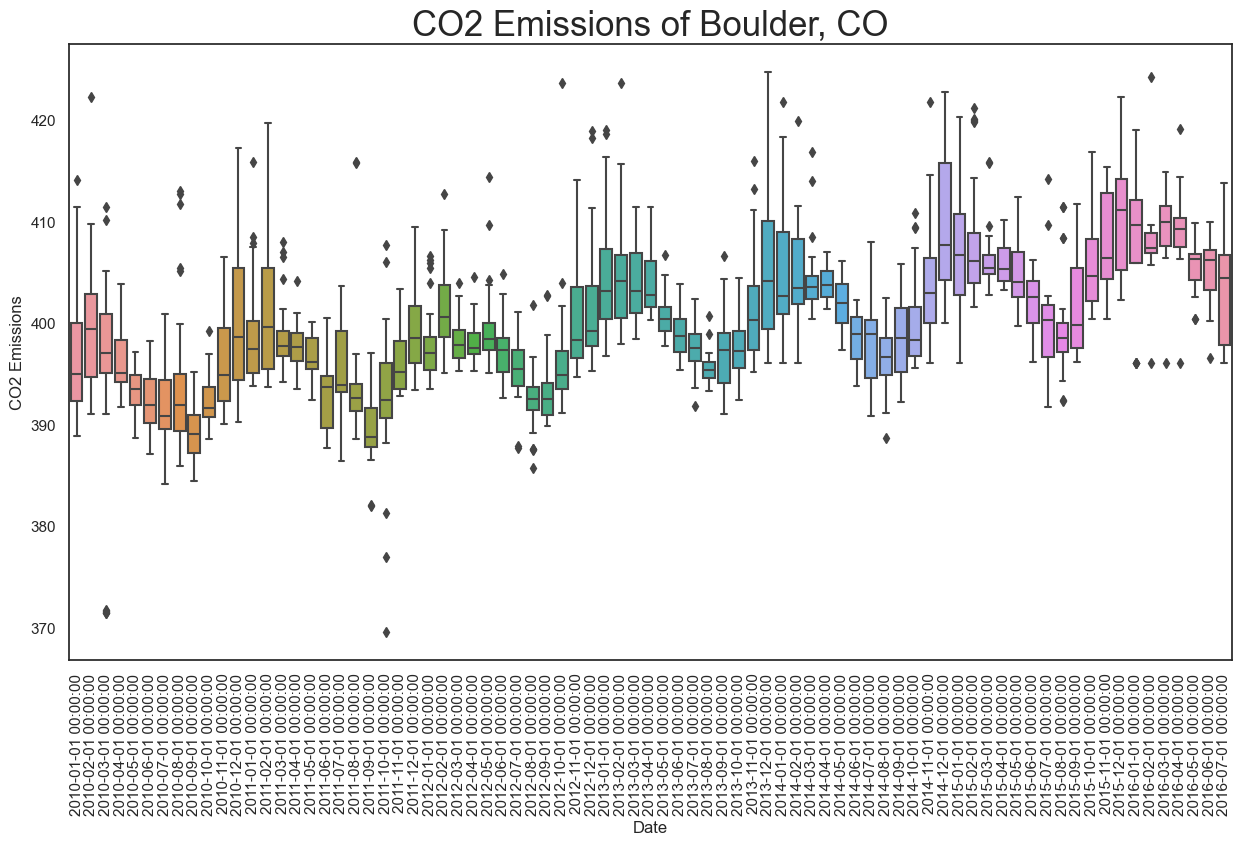

In [32]:
boxplot('value', bou_co2['2010-01-01':'2016-07-01'], title='CO2 Emissions of Boulder, CO')

In [33]:
def monthly_averages(climate_df, co2_df):
    grouper = pd.Grouper(level='Date', freq='M')
    df = climate_df.groupby(grouper).mean()
    df1 = co2_df.groupby(grouper).mean()
    return df.join(df1, lsuffix='_left', rsuffix='_right', how='outer')

In [34]:
bou_monthly = monthly_averages(bou, bou_co2)
hil_monthly = monthly_averages(hil, hil_co2)
hoh_monthly = monthly_averages(hoh, hoh_co2)
cap_monthly = monthly_averages(cap, cap_co2)
los_monthly = monthly_averages(los, los_co2)
san_monthly = monthly_averages(san, san_co2)
ice_monthly = monthly_averages(ice, ice_co2)
tem_monthly = monthly_averages(tem, tem_co2)

In [35]:
list_df = [bou_monthly, hil_monthly,
           hoh_monthly, cap_monthly,
           los_monthly, san_monthly,
           ice_monthly, tem_monthly]

for df in list_df:
    df.dropna(subset=['value'],how='any',inplace=True)

    df[['Average Dew Point Temperature',
        'Average Monthly Temperature',
        'Monthly Maximum Temperature',
        'Monthly Minimum Temperature']] += 273

In [36]:
def exp_rolling_mean(df, target='value'):
    # a sqrt transformation is used due to the presence of zero values
    data = pd.Series(np.sqrt(df[target]), index=df.index)
    exp_roll_mean = data.ewm(halflife=2).mean()
    data_minus_exp_roll_mean = data - exp_roll_mean
    return data_minus_exp_roll_mean

In [97]:
print('bou', bou_monthly[['Average Monthly Temperature', 'value']].corr())
print('hil', hil_monthly[['Average Monthly Temperature', 'value']].corr())
print('hoh', hoh_monthly[['Average Monthly Temperature', 'value']].corr())
print('cap', cap_monthly[['Average Monthly Temperature', 'value']].corr())
print('los', los_monthly[['Average Monthly Temperature', 'value']].corr())
print('san', san_monthly[['Average Monthly Temperature', 'value']].corr())
print('ice', ice_monthly[['Average Monthly Temperature', 'value']].corr())
print('tem', tem_monthly[['Average Monthly Temperature', 'value']].corr())

bou                              Average Monthly Temperature     value
Average Monthly Temperature                     1.000000 -0.407633
value                                          -0.407633  1.000000
hil                              Average Monthly Temperature     value
Average Monthly Temperature                     1.000000  0.128729
value                                           0.128729  1.000000
hoh                              Average Monthly Temperature     value
Average Monthly Temperature                     1.000000 -0.490213
value                                          -0.490213  1.000000
cap                              Average Monthly Temperature     value
Average Monthly Temperature                     1.000000  0.005746
value                                           0.005746  1.000000
los                              Average Monthly Temperature     value
Average Monthly Temperature                     1.000000 -0.077809
value                                     

In [37]:
features = ['year', 'quarter', 'month', 'season']
target = ['Average Dew Point Temperature',
          'Average Wind Speed',
          'Total Monthly Precipitation',
          'Monthly Average of the daily percents of possible sunshine',
          'Average Monthly Temperature',
          'Monthly Maximum Temperature',
          'Monthly Minimum Temperature',
          'Relative Humidity',
          'value']

In [38]:
bou_monthly = bou_monthly.drop(columns=['longitude', 'latitude'])
hil_monthly = hil_monthly.drop(columns=['longitude', 'latitude'])
hoh_monthly = hoh_monthly.drop(columns=['longitude', 'latitude'])
cap_monthly = cap_monthly.drop(columns=['longitude', 'latitude'])
los_monthly = los_monthly.drop(columns=['longitude', 'latitude'])
san_monthly = san_monthly.drop(columns=['longitude', 'latitude'])
ice_monthly = ice_monthly.drop(columns=['longitude', 'latitude'])
tem_monthly = tem_monthly.drop(columns=['longitude', 'latitude'])

In [39]:
bou_rol = pd.DataFrame(index=bou_monthly.index)
hil_rol = pd.DataFrame(index=hil_monthly.index)
hoh_rol = pd.DataFrame(index=hoh_monthly.index)
cap_rol = pd.DataFrame(index=cap_monthly.index)
los_rol = pd.DataFrame(index=los_monthly.index)
san_rol = pd.DataFrame(index=san_monthly.index)
ice_rol = pd.DataFrame(index=ice_monthly.index)
tem_rol = pd.DataFrame(index=tem_monthly.index)

for x in target:
    bou_rol[x] = exp_rolling_mean(bou_monthly, target=x)
    hil_rol[x] = exp_rolling_mean(hil_monthly, target=x)
    hoh_rol[x] = exp_rolling_mean(hoh_monthly, target=x)
    cap_rol[x] = exp_rolling_mean(cap_monthly, target=x)
    los_rol[x] = exp_rolling_mean(los_monthly, target=x)
    san_rol[x] = exp_rolling_mean(san_monthly, target=x)
    ice_rol[x] = exp_rolling_mean(ice_monthly, target=x)
    tem_rol[x] = exp_rolling_mean(tem_monthly, target=x)

In [40]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(df):
    
    dftest = adfuller(df)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [86]:
hil_monthly.corr()['value']

Average Dew Point Temperature                                 0.259104
Average Wind Speed                                           -0.467177
Total Monthly Precipitation                                  -0.033420
Monthly Average of the daily percents of possible sunshine   -0.200429
Average Monthly Temperature                                   0.128729
Monthly Maximum Temperature                                   0.091551
Monthly Minimum Temperature                                   0.150459
Relative Humidity                                            -0.017511
value                                                         1.000000
Name: value, dtype: float64

In [83]:
san_monthly.index

DatetimeIndex(['2007-10-31', '2007-11-30', '2007-12-31', '2008-01-31',
               '2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31',
               '2008-06-30', '2008-07-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=182, freq=None)

In [42]:
stationarity_check(bou_rol['value'])

Test Statistic                 -2.642763
p-value                         0.084477
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [48]:
stationarity_check(hil_rol['value'])

Test Statistic                -6.467190e+00
p-value                        1.395783e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.560000e+02
Critical Value (1%)           -3.442166e+00
Critical Value (5%)           -2.866752e+00
Critical Value (10%)          -2.569546e+00
dtype: float64


In [49]:
stationarity_check(hoh_rol['value'])

Test Statistic                -5.905691e+00
p-value                        2.712087e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.890000e+02
Critical Value (1%)           -3.465431e+00
Critical Value (5%)           -2.876957e+00
Critical Value (10%)          -2.574988e+00
dtype: float64


In [50]:
stationarity_check(cap_rol['value'])

Test Statistic                -8.207529e+00
p-value                        6.959442e-13
#Lags Used                     1.900000e+01
Number of Observations Used    5.500000e+02
Critical Value (1%)           -3.442296e+00
Critical Value (5%)           -2.866809e+00
Critical Value (10%)          -2.569576e+00
dtype: float64


In [51]:
stationarity_check(los_rol['value'])

Test Statistic                  -3.918775
p-value                          0.001901
#Lags Used                      14.000000
Number of Observations Used    137.000000
Critical Value (1%)             -3.479007
Critical Value (5%)             -2.882878
Critical Value (10%)            -2.578149
dtype: float64


In [52]:
stationarity_check(san_rol['value'])

Test Statistic                  -4.613099
p-value                          0.000122
#Lags Used                      12.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.469648
Critical Value (5%)             -2.878799
Critical Value (10%)            -2.575971
dtype: float64


In [53]:
stationarity_check(ice_rol['value'])

Test Statistic                -6.407394e+00
p-value                        1.928097e-08
#Lags Used                     1.200000e+01
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64


In [54]:
stationarity_check(tem_rol['value'])

Test Statistic                -9.192426e+00
p-value                        2.105761e-15
#Lags Used                     8.000000e+00
Number of Observations Used    1.830000e+02
Critical Value (1%)           -3.466598e+00
Critical Value (5%)           -2.877467e+00
Critical Value (10%)          -2.575260e+00
dtype: float64


In [55]:
stationarity_check(bou_monthly['Average Monthly Temperature'].dropna())

Test Statistic                 -2.874661
p-value                         0.048375
#Lags Used                     13.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [56]:
stationarity_check(hil_monthly['Average Monthly Temperature'].dropna())

Test Statistic                  -3.943082
p-value                          0.001740
#Lags Used                      17.000000
Number of Observations Used    557.000000
Critical Value (1%)             -3.442145
Critical Value (5%)             -2.866743
Critical Value (10%)            -2.569541
dtype: float64


In [57]:
stationarity_check(hoh_monthly['Average Monthly Temperature'].dropna())

Test Statistic                  -2.895770
p-value                          0.045842
#Lags Used                      12.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [58]:
stationarity_check(cap_monthly['Average Monthly Temperature'].dropna())

Test Statistic                  -2.812052
p-value                          0.056573
#Lags Used                      10.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [59]:
stationarity_check(los_monthly['Average Monthly Temperature'].dropna())

Test Statistic                  -1.755848
p-value                          0.402592
#Lags Used                      11.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


In [60]:
stationarity_check(san_monthly['Average Monthly Temperature'].dropna())

Test Statistic                  -1.798757
p-value                          0.381079
#Lags Used                      13.000000
Number of Observations Used    168.000000
Critical Value (1%)             -3.469886
Critical Value (5%)             -2.878903
Critical Value (10%)            -2.576027
dtype: float64


In [61]:
stationarity_check(ice_monthly['Average Monthly Temperature'].dropna())

Test Statistic                  -1.939961
p-value                          0.313502
#Lags Used                      15.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


In [62]:
stationarity_check(tem_monthly['Average Monthly Temperature'].dropna())

Test Statistic                -1.024752e+01
p-value                        4.576033e-18
#Lags Used                     4.000000e+00
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


In [76]:
def auto_corr(df, target='value', period=1):
    df_lag = df.shift(periods=period)
    
    lag = pd.concat([df_lag, df], axis=1)
    lag.plot(figsize=(15,8), alpha=0.8);
    
    print('Correlation value before shifting\n',df.corr()[target],
          '\n\nCorrelation value after shifting\n',df_lag.corr()[target])
    return df_lag

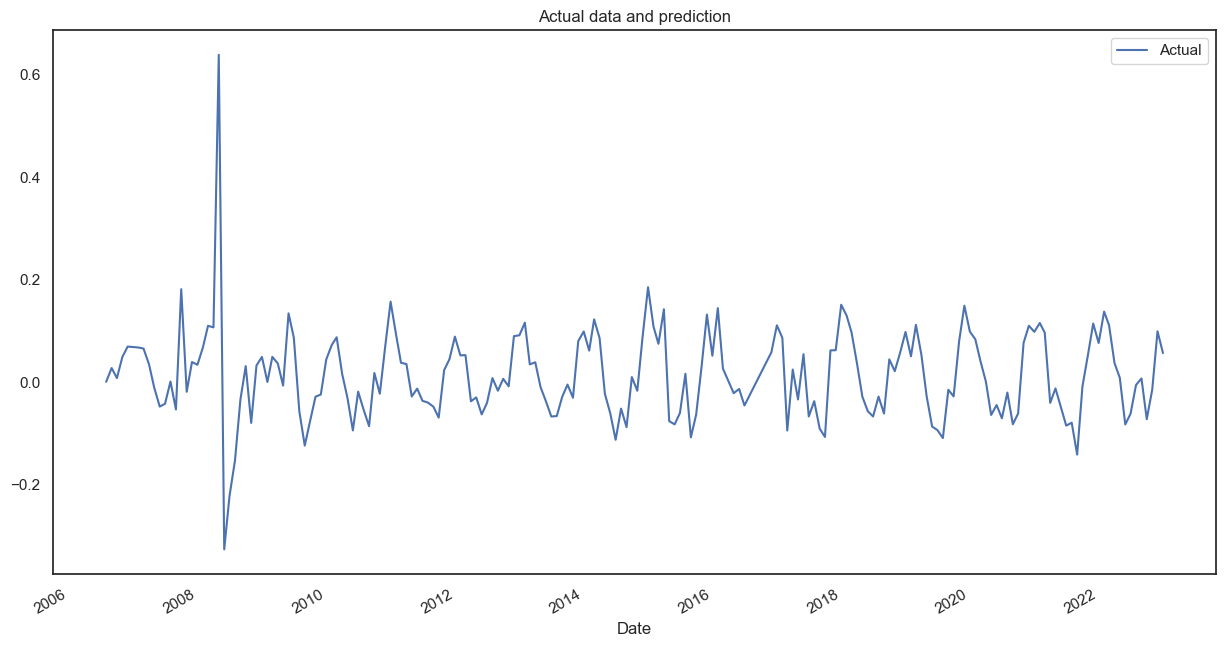

In [78]:
ax = tem_rol['value'].plot(figsize=(15,8))

plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual data and prediction')
plt.show();

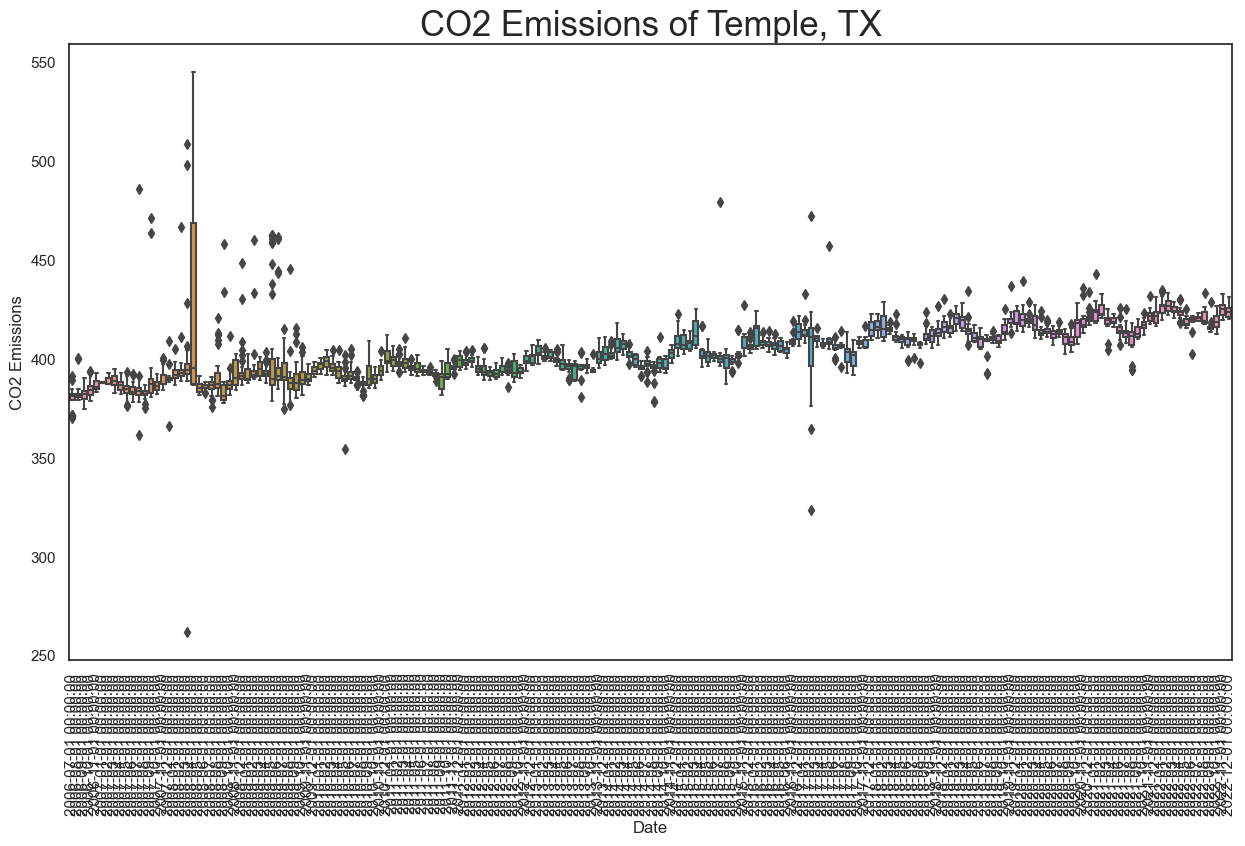

In [80]:
boxplot('value', tem_co2, title='CO2 Emissions of Temple, TX')